In [13]:
import copy
import pickle
from pathlib import Path

import glob2
import datetime

import numpy as np
from scipy.signal import find_peaks
from tqdm.notebook import tqdm
import tensorflow as tf
from skimage.transform import resize
from matplotlib import pyplot as plt

from src.detection.clustering import get_valid, get_clusters, get_delta
from utils.data_reading.catalogs.ISC import ISC_file
from utils.data_reading.sound_data.sound_file_manager import NpyFilesManager
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.bathymetry.bathymetry_grid import BathymetryGrid
from utils.physics.sound.sound_model import HomogeneousSoundModel
from utils.physics.sound.sound_velocity_grid import MonthlySoundVelocityGridOptimized
from utils.transformations.features_extractor import STFTFeaturesExtractor

In [2]:
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"

year = 2018
isc_file = f"/home/plerolland/Bureau/catalogs/ISC/eqk_isc_{year}.txt"

sound_model_h = HomogeneousSoundModel()
sound_model_g = MonthlySoundVelocityGridOptimized([f"../../data/sound_model/min-velocities_month-{i:02d}.nc" for i in range(1,13)], interpolate=True)
bathy_model = BathymetryGrid.create_from_NetCDF("../../data/geo/GEBCO_2023_sub_ice_topo.nc", lat_bounds=[-75, 35], lon_bounds=[-20, 180])

stations_c = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
stft_computer = STFTFeaturesExtractor(None, vmin=60, vmax=140, f_min=5, f_max=60)

MIN_P = 0.4
MIN_P_MATES = 0.2
NB = 3
TOLERANCE = datetime.timedelta(seconds=20)
TIME_DELTA_SEARCH = datetime.timedelta(seconds=5*86400)

TIME_RES = 0.5 # duration, in s, of a sample in the associator results
HALF_FOCUS_SIZE = 32  # window to compare for associator
MAX_SHIFT = 128  # max allowed shift resulting from associator

# output
detections_file = f"../../data/detections/{year}/detections.npy"
RES_FILE = f"../../data/detections/{year}/matchups_clusters_loc_adjusted.csv"

In [3]:
isc = ISC_file(isc_file)

# filter isc events
to_del = set()
for ID, event in isc.items.items():
    if bathy_model.get_nearest_values(event.get_pos()) > 0:
        to_del.add(ID)
    lat, lon = tuple(isc[ID].get_pos())
    if (lat>-5 and lon > 115) or (lat>-30 and lon > 130) or (lat>-45 and lon > 170) or (lat>-20 and lon > 85):
        to_del.add(ID)
for ID in to_del:
    del isc.items[ID]
print(f"{len(to_del)} terrestrial events removed from catalog ({len(isc.items)} remain)")

IDs = list(isc.items.keys())

14233 terrestrial events removed from catalog (1467 remain)


### Detections computation

In [4]:
if not Path(detections_file).is_file():
    print("starting detection")
    to_read = glob2.glob(f"../../data/detections/{year}/*.p")
    
    detections = {}
    for file in to_read:
        info = file.split("_")[-1][:-2].split("-")
        name, year_station = "-".join(info[:-1]), int(info[-1])
        station = stations_c.by_starting_year(year_station).by_names(name)[0]
        detections[station] = []
        with open(file, "rb") as f:
            while True:
                try:
                    detections[station].append(pickle.load(f))
                except EOFError:
                    break
                    
        detections[station] = np.array(detections[station])
        detections[station] = detections[station][np.argsort(detections[station][:,0])]
    
        # merge close detections
        to_del = set()
        i, j = 0, 0
        while j<len(detections[station]):
            delta = (np.abs(detections[station][i,0] - detections[station][j,0]))
            if delta.total_seconds() < 5:
                detections[station][i,0] += delta / 2
                to_del.add(j)
            else:
                i = j
            j+=1
        detections[station] = np.delete(detections[station], list(to_del), axis=0)
        
        print(f"{len(list(to_del))} lines deleted ; {len(detections[station])} left for station {station}")
    np.save(detections_file, detections)
else:
    detections = np.load(detections_file, allow_pickle=True).item()
embedding_managers = {s : NpyFilesManager(f"../../data/detections/{year}/embedding_{year}_{s.name}-{s.date_start.year}") for s in detections.keys()}

In [5]:
# merge all detections and sort them by date
stations = list(detections.keys())
merged_detections = []
for s, dets in detections.items():
    for det in dets:
        merged_detections.append((det[0], det[1], s))
merged_detections = np.array(merged_detections, dtype=np.object_)
merged_detections = merged_detections[np.argsort(merged_detections[:,0])]

In [6]:
allowed_delta = 30
delta = get_delta(isc, allowed_delta)
valid_ = get_valid(allowed_delta, delta, IDs)
clusters_ = get_clusters(IDs, valid_)

In [7]:
res = ""
for id, cluster in clusters_.items():
    if len(cluster)>1:
        for ID in cluster:
            res += f"{isc[ID].get_pos()[0]},{isc[ID].get_pos()[1]},{id}\n"
with open("res.csv", "w") as f:
    f.write(res)
    
date_min = [np.min([isc[ID].date for ID in cluster]) for cluster in clusters_.values()]
clusters_ = list(clusters_.values())
clusters_ = [clusters_[i] for i in np.argsort(date_min)]

In [8]:
MIN_PROBA = 0.4
merged_detections_kept = merged_detections[merged_detections[:,1]>MIN_PROBA]
print(f"{len(merged_detections_kept)} detections kept out of {len(merged_detections)}")

462378 detections kept out of 4884183


In [9]:
def get_embedding_diff_sliding(e1, e2):
    e1_center, e2_center = e1.shape[1]//2, e2.shape[1]//2
    e1 = np.array(e1[:, e1_center-HALF_FOCUS_SIZE:e1_center+HALF_FOCUS_SIZE+1])
    e2 = np.array([e2[:, e2_center+i-HALF_FOCUS_SIZE:e2_center+i+HALF_FOCUS_SIZE+1] for i in range(-MAX_SHIFT, MAX_SHIFT+1)])
    return np.sqrt(np.sum((e1[np.newaxis,:,:]-e2)**2, axis=(1,2))) / np.sqrt(HALF_FOCUS_SIZE*2*16*2)

def find_shift(e1, e2, max_diff=0.4):
    differences = get_embedding_diff_sliding(e1, e2)
    peaks, _ = find_peaks(-differences, height=-max_diff)
    peaks_s = np.round((peaks - len(differences)//2)*TIME_RES).astype(np.int32)
    if len(peaks_s)>0:
        idx = np.argmin(np.abs(peaks_s))
        peak, height = peaks_s[idx], differences[peaks[idx]]
    else:
        peak, height = 0, None
    
    return datetime.timedelta(seconds=int(peak)), height


def get_embedding(station, date):
    npts = MAX_SHIFT+2*HALF_FOCUS_SIZE
    dt = datetime.timedelta(seconds=npts * TIME_RES)
    data = embedding_managers[station].getSegment(date-dt, date+dt)
    data = resize(data, (16, 2*npts+1))
    return data

def find_candidates(detections, detection, d_h, seen_dates, tolerance, min_p=0):
    date, s1 = detection[0], detection[-1]
    embedding = get_embedding(s1, date)
    if date in seen_dates:
        return []
    candidates = {}
    for s2 in detections.keys():
        if s1 == s2:
            continue
        detections_s2 = detections[s2]
        idx_min = np.searchsorted(detections[s2][:,0], date + d_h[s1][s2] - tolerance, side='right')
        idx = idx_min  # note : iterating like this instead of finding max with searchsorted is way more efficent
        while idx < len(detections[s2]) and detections[s2][idx,0] < date + d_h[s1][s2] + tolerance:
            det = detections_s2[idx]
            if det[0] not in seen_dates and det[1]>min_p:
                embedding_2 = get_embedding(s2, det[0])
                shift, delta_embedding = find_shift(embedding, embedding_2)
                det[0] += shift
                if det[0] not in seen_dates and delta_embedding is not None:
                    candidates.setdefault(s2, []).append((det[0], det[1], delta_embedding, s2))
            idx += 1
        if s2 in candidates:
            candidates[s2] = np.array(candidates[s2])
    return candidates

def best_matchup(scores, nb, d_h, tolerance):
    scores_merged = []
    for s in scores.keys():
        for j, score in enumerate(scores[s]):
            scores_merged.append((s, j, score[2]))

    scores_merged.sort(key=lambda x: x[2])
    selected = []
    chosen_idxs = set()
    idx = 0
    while len(selected) != nb and idx < len(scores_merged):
        s, j, similarity = scores_merged[idx]
        if s not in chosen_idxs:
            consistent = True
            d = scores[s][j][0]
            for (s2, j2) in selected:
                d2 = scores[s2][j2][0]
                if not (d + d_h[s][s2] - tolerance < d2 < d + d_h[s][s2] + tolerance):
                    consistent = False  # given location constraint, this can't be true
            if consistent:
                selected.append((s, j))
                chosen_idxs.add(s)
        idx += 1
    return selected

def load_processed(res_file):
    if not Path(res_file).exists():
        return set(), set()
    with open(res_file, "r") as f:
        lines = f.readlines()
    seen_IDs = set()
    seen_dates = set()
    for line in lines:
        seen_IDs.add(int(line.split(",")[6]))
        dates = line.split(",")[9::2]
        for date in dates:
            date = date.strip()
            if len(date) == 0:
                continue
            seen_dates.add(datetime.datetime.strptime(date, "%Y%m%d_%H%M%S"))
    return seen_IDs, seen_dates

def constrain_coord(coords):
    coords[0] = (coords[0] + 90) % 180 - 90
    coords[1] = (coords[1] + 180) % 360 - 180

    if np.isclose(coords[1], 180) or np.isclose(coords[1], -180) or np.isclose(coords[0], 90) or np.isclose(coords[0], -90):
        return [None, None]

    return coords

def locate(matchup, sound_model, cost_allowed=None, initial_pos=None):
    det_times = [c[0] for c in matchup]
    det_pos = [c[-1].get_pos() for c in matchup]
    try:
        r = sound_model.localize_common_source(det_pos, det_times, initial_pos=initial_pos)
        if type(r) != list and np.count_nonzero(np.isnan(r.x))==0:
            r.x[1:] = constrain_coord(r.x[1:])
            if r.x[1] is not None and (not cost_allowed or np.sqrt(r.cost/len(det_times)) < cost_allowed):
                return True, r
            else:
                return False, r
    except:
        pass  # we return None
    return False, None

In [10]:
valid = get_valid(allowed_delta, delta, IDs)
clusters = get_clusters(IDs, valid)
date_min = [np.min([isc[ID].date for ID in cluster]) for cluster in clusters.values()]
cluster_centroids = [np.mean([isc[ID].get_pos() for ID in cluster], axis=0) for cluster in clusters.values()]
clusters = list(clusters.values())
clusters = [clusters[i] for i in np.argsort(date_min)]
print(f"clusters computed, found {len(clusters)} out of {len(IDs)} events")

seen_IDs, seen_dates = load_processed(RES_FILE)

clusters computed, found 776 out of 1467 events


[datetime.datetime(2018, 1, 1, 3, 33, 33, 354701) 0.8184]
[datetime.datetime(2018, 1, 1, 3, 34, 2, 735043) 0.1016]
det 2018-01-01 03:31:22.478632 0.5776 SSEIR
candidates [('MADE', array([[datetime.datetime(2018, 1, 1, 3, 39, 1, 346154), 0.8257,
        0.31106266,
      dtype=object)), ('NEAMS', array([[datetime.datetime(2018, 1, 1, 3, 33, 31, 354701), 0.8184, 0.0,
      dtype=object)), ('SWAMS', array([[datetime.datetime(2018, 1, 1, 3, 41, 30, 987179), 0.503,
        0.25662553,
      dtype=object)), ('WKER2', array([[datetime.datetime(2018, 1, 1, 3, 50, 16, 559829), 0.2063,
        0.20121467,
      dtype=object))]
closest station is NEAMS


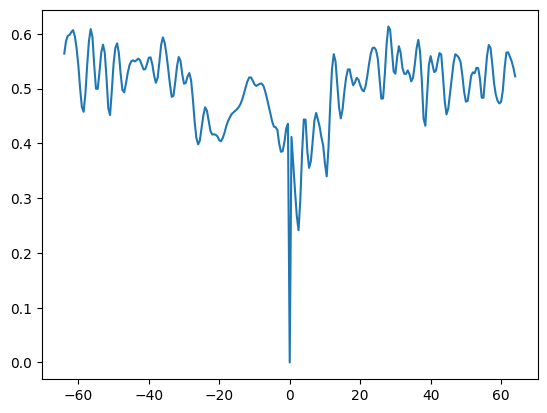

In [11]:
cluster = clusters[0]
centroid = np.mean([isc[ID].get_pos() for ID in cluster], axis=0)
dates = [isc[ID].date for ID in cluster]
date_min, date_max = np.min(dates)-TIME_DELTA_SEARCH, np.max(dates)+TIME_DELTA_SEARCH
date_mid = date_min + (date_max - date_min) / 2
expected = {s: sound_model_h.get_sound_travel_time(centroid, s.get_pos(), date=date_mid) for s in stations}
# d_h[s1][s2] = given a detection on s1, time to wait before getting it on s2 (can be negative)
d_h = {s1: {s2: datetime.timedelta(seconds=expected[s2] - expected[s1]) for s2 in stations} for s1 in
       stations}

idx0 = np.searchsorted(merged_detections_kept[:, 0], date_min, side='right')

idx0 = 63
# BEGIN analayse
diffs = {}
while len(diffs) == 0 or np.min(list(diffs.values())) > 0.3:
    idx0 += 1
    detection = merged_detections_kept[idx0]
    diffs = {}
    
    date, s1 = detection[0], detection[-1]
    embedding = get_embedding(s1, date)
    candidates = {}
    for s2 in detections.keys():
        if s1 == s2:
            continue
        idx_min = np.searchsorted(detections[s2][:,0], date + d_h[s1][s2] - TOLERANCE, side='right')
        idx = idx_min  # note : iterating like this instead of finding max with searchsorted is way more efficent
        while idx < len(detections[s2]) and detections[s2][idx,0] < date + d_h[s1][s2] + TOLERANCE:
            det = detections[s2][idx]
            #print("found",det, s2.name)
            if det[1]>0.01:  # todo changed P
                embedding_2 = get_embedding(s2, det[0])
                shift, delta_embedding = find_shift(embedding, embedding_2)
                shifted = det[0] + shift
                diff = get_embedding_diff_sliding(embedding, embedding_2)
                
                if s2.name=="NEAMS":
                    print(det)
                    if det[0].second == 33:
                        diff[len(diff)//2]=0
                    else:
                        break
                
                diffs[s2] = diff
                
                if delta_embedding is not None:
                    candidates.setdefault(s2, []).append((shifted, det[1], np.min(diff), s2))
            idx += 1
        if s2 in candidates:
            candidates[s2] = np.array(candidates[s2])


# END analyse
#print("cluster", cluster, centroid, date_mid)
min_s = list(diffs.keys())[np.argmin(np.min(np.array(list(diffs.values())),axis=1))]
print("det", detection[0], detection[1], detection[-1].name)
print("candidates", [(c.name, candidates[c]) for c in candidates])
print("closest station is",min_s.name)
plt.plot(np.arange(-MAX_SHIFT,MAX_SHIFT+1)/2, diffs[min_s])

In [12]:
print("starting matchup computation")
for i, cluster in enumerate(clusters):
    if cluster[0] in seen_IDs:
        continue
    if len(cluster) > 0:  # generalize to all clusters including singletons
        centroid = np.mean([isc[ID].get_pos() for ID in cluster], axis=0)
        dates = [isc[ID].date for ID in cluster]
        date_min, date_max = np.min(dates)-TIME_DELTA_SEARCH, np.max(dates)+TIME_DELTA_SEARCH
        date_mid = date_min + (date_max - date_min) / 2

        expected = {s: sound_model_h.get_sound_travel_time(centroid, s.get_pos(), date=date_mid) for s in stations}
        # d_h[s1][s2] = given a detection on s1, time to wait before getting it on s2 (can be negative)
        d_h = {s1: {s2: datetime.timedelta(seconds=expected[s2] - expected[s1]) for s2 in stations} for s1 in
               stations}

        # in bounds search
        idx_min = np.searchsorted(merged_detections_kept[:, 0], date_min, side='right')
        idx_max = np.searchsorted(merged_detections_kept[:, 0], date_max, side='left')
        for idx in tqdm(range(idx_min, idx_max), position=0, leave=True):
            detection = merged_detections_kept[idx]
            try:
                candidates = find_candidates(detections, detection, d_h, seen_dates=seen_dates, tolerance=TOLERANCE,
                                         min_p=MIN_P_MATES)
            except:
                print("unable to find candidates for iteration",i,idx)
            # print(len(candidates))
            if len(candidates) < NB:
                continue
            scores = {s: c for s, c in candidates.items()}
            best_m = best_matchup(scores, NB, d_h, TOLERANCE)
            if len(best_m) < NB:
                continue

            matchup = [list(detection[:-1]) + [0] + [detection[-1]]] + [candidates[s][j] for s, j in best_m]
            loc_worked, loc_res = locate(matchup, sound_model_h, 10)

            # if it didn't work because loc was not close enough, we try deleting a station
            if not loc_worked and type(loc_res) != list and len(matchup) > NB + 1:
                to_del = np.argmax(loc_res.fun)  # index of maximum residual
                matchup = matchup[:to_del] + matchup[to_del+1:]
                loc_worked, loc_res = locate(matchup, sound_model_h, 10)


            # in case it worked, go further
            if loc_worked:
                loc_worked, loc_res = locate(matchup, sound_model_g, 5, initial_pos=loc_res.x[1:])
                if loc_worked:
                    det_times = [date] + [c[0] for c in matchup]
                    date_event = np.min(det_times) + datetime.timedelta(seconds=loc_res.x[0])

                    # add other stations
                    changed = False
                    loc_res_updated = copy.deepcopy(loc_res)
                    matchup_updated = copy.deepcopy(matchup)

                    seen_stations = set([c[-1] for c in matchup])
                    for s, c in candidates.items():
                        if s in seen_stations:
                            continue
                        try:
                            expected_time = date_event + datetime.timedelta(
                                seconds=sound_model_h.get_sound_travel_time(s.get_pos(), loc_res_updated.x[1:]))
                        except:
                            continue
                        found = False
                        for chosen in c:
                            if np.abs(chosen[0] - expected_time).total_seconds() < 10:
                                found = True
                                break
                        if not found:
                            continue
                        matchup_updated = matchup_updated + [chosen]
                        loc_worked_new, loc_res_new = locate(matchup_updated, sound_model_h, 10)
                        if loc_worked_new:  # update location
                            changed = True
                            seen_stations.add(chosen[-1])
                            loc_res_updated = loc_res_new
                        else:  # rollback
                            matchup_updated = matchup_updated[:-1]

                    if changed:
                        loc_worked_new, loc_res_new = locate(matchup_updated, sound_model_g, 5, initial_pos=loc_res_updated.x[1:])
                        if loc_worked_new:
                            loc_res = loc_res_new
                            matchup = matchup_updated

                    d_from_cluster = np.sqrt(np.sum(np.square(np.array(loc_res.x[1:])-cluster_centroids[i])))
                    det_times = [date] + [c[0] for c in matchup]
                    for d in det_times:
                        seen_dates.add(d)  # to avoid using the same detection twice
                    date_event = np.min(det_times) + datetime.timedelta(seconds=loc_res.x[0])
                    try:
                        J = loc_res.jac
                        cov = np.linalg.inv(J.T.dot(J))
                        var = np.sqrt(np.diagonal(cov))
                    except:
                        var = [-1, -1, -1]

                    # note: we register one ISC event from the cluster
                    to_write = (f'{date_event.strftime("%Y%m%d_%H%M%S")},{loc_res.x[1]:.4f},{loc_res.x[2]:.4f},'
                                f'{var[0]:.4f},{var[1]:.4f},{var[2]:.4f},{cluster[0]},{d_from_cluster:.4f}')
                    for d, _, _, s in matchup:
                        to_write += f',{s.name}-{s.date_start.year},{d.strftime("%Y%m%d_%H%M%S")}'
                    with open(RES_FILE, "a") as f:
                        f.write(to_write + "\n")

starting matchup computation


  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/2266 [00:00<?, ?it/s]

  0%|          | 0/2524 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2907 [00:00<?, ?it/s]

  0%|          | 0/3276 [00:00<?, ?it/s]

  0%|          | 0/3332 [00:00<?, ?it/s]

  0%|          | 0/3351 [00:00<?, ?it/s]

  0%|          | 0/3985 [00:00<?, ?it/s]

unable to find candidates for iteration 9 3585
unable to find candidates for iteration 9 3586
unable to find candidates for iteration 9 3587
unable to find candidates for iteration 9 3588


  0%|          | 0/5069 [00:00<?, ?it/s]

unable to find candidates for iteration 10 3585
unable to find candidates for iteration 10 3586
unable to find candidates for iteration 10 3587
unable to find candidates for iteration 10 3588


  0%|          | 0/5311 [00:00<?, ?it/s]

unable to find candidates for iteration 11 3583
unable to find candidates for iteration 11 3585
unable to find candidates for iteration 11 3586
unable to find candidates for iteration 11 3587
unable to find candidates for iteration 11 3588
unable to find candidates for iteration 11 3675


  0%|          | 0/5663 [00:00<?, ?it/s]

unable to find candidates for iteration 12 3585
unable to find candidates for iteration 12 3586
unable to find candidates for iteration 12 3587
unable to find candidates for iteration 12 3588
unable to find candidates for iteration 12 3654


  0%|          | 0/6108 [00:00<?, ?it/s]

unable to find candidates for iteration 13 3585
unable to find candidates for iteration 13 3586
unable to find candidates for iteration 13 3587
unable to find candidates for iteration 13 3588
unable to find candidates for iteration 13 3710
unable to find candidates for iteration 13 3715


  0%|          | 0/6386 [00:00<?, ?it/s]

unable to find candidates for iteration 14 3585
unable to find candidates for iteration 14 3586
unable to find candidates for iteration 14 3587
unable to find candidates for iteration 14 3588


  0%|          | 0/6389 [00:00<?, ?it/s]

unable to find candidates for iteration 15 3585
unable to find candidates for iteration 15 3586
unable to find candidates for iteration 15 3587
unable to find candidates for iteration 15 3588
unable to find candidates for iteration 15 3710
unable to find candidates for iteration 15 3715


  0%|          | 0/20839 [00:00<?, ?it/s]

unable to find candidates for iteration 16 3585
unable to find candidates for iteration 16 3586
unable to find candidates for iteration 16 3587
unable to find candidates for iteration 16 3588
unable to find candidates for iteration 16 3664
unable to find candidates for iteration 16 3665
unable to find candidates for iteration 16 3666


  0%|          | 0/7142 [00:00<?, ?it/s]

unable to find candidates for iteration 17 3585
unable to find candidates for iteration 17 3586
unable to find candidates for iteration 17 3587
unable to find candidates for iteration 17 3588
unable to find candidates for iteration 17 3664
unable to find candidates for iteration 17 3665
unable to find candidates for iteration 17 3666
unable to find candidates for iteration 17 6135


  0%|          | 0/7288 [00:00<?, ?it/s]

unable to find candidates for iteration 18 3585
unable to find candidates for iteration 18 3586
unable to find candidates for iteration 18 3587
unable to find candidates for iteration 18 3588
unable to find candidates for iteration 18 3710
unable to find candidates for iteration 18 7442


  0%|          | 0/7434 [00:00<?, ?it/s]

unable to find candidates for iteration 19 3585
unable to find candidates for iteration 19 3586
unable to find candidates for iteration 19 3587
unable to find candidates for iteration 19 3588
unable to find candidates for iteration 19 3711
unable to find candidates for iteration 19 6129
unable to find candidates for iteration 19 7428
unable to find candidates for iteration 19 7429


  0%|          | 0/8680 [00:00<?, ?it/s]

unable to find candidates for iteration 20 3581
unable to find candidates for iteration 20 3585
unable to find candidates for iteration 20 3586
unable to find candidates for iteration 20 3587
unable to find candidates for iteration 20 3588
unable to find candidates for iteration 20 3665
unable to find candidates for iteration 20 3666


  0%|          | 0/8748 [00:00<?, ?it/s]

unable to find candidates for iteration 21 3585
unable to find candidates for iteration 21 3586
unable to find candidates for iteration 21 3587
unable to find candidates for iteration 21 3588
unable to find candidates for iteration 21 3711
unable to find candidates for iteration 21 7416
unable to find candidates for iteration 21 10711


  0%|          | 0/8788 [00:00<?, ?it/s]

unable to find candidates for iteration 22 3585
unable to find candidates for iteration 22 3586
unable to find candidates for iteration 22 3587
unable to find candidates for iteration 22 3588
unable to find candidates for iteration 22 3710
unable to find candidates for iteration 22 3715
unable to find candidates for iteration 22 7440
unable to find candidates for iteration 22 7442
unable to find candidates for iteration 22 10234


  0%|          | 0/8815 [00:00<?, ?it/s]

unable to find candidates for iteration 23 3585
unable to find candidates for iteration 23 3586
unable to find candidates for iteration 23 3587
unable to find candidates for iteration 23 3588
unable to find candidates for iteration 23 3701
unable to find candidates for iteration 23 7429
unable to find candidates for iteration 23 7430
unable to find candidates for iteration 23 7431


  0%|          | 0/8821 [00:00<?, ?it/s]

unable to find candidates for iteration 24 3585
unable to find candidates for iteration 24 3586
unable to find candidates for iteration 24 3587
unable to find candidates for iteration 24 3588
unable to find candidates for iteration 24 3710
unable to find candidates for iteration 24 3715
unable to find candidates for iteration 24 7445


  0%|          | 0/8831 [00:00<?, ?it/s]

unable to find candidates for iteration 25 3585
unable to find candidates for iteration 25 3586
unable to find candidates for iteration 25 3587
unable to find candidates for iteration 25 3588
unable to find candidates for iteration 25 3638
unable to find candidates for iteration 25 3643
unable to find candidates for iteration 25 3654
unable to find candidates for iteration 25 10760
unable to find candidates for iteration 25 10762


  0%|          | 0/8824 [00:00<?, ?it/s]

unable to find candidates for iteration 26 3585
unable to find candidates for iteration 26 3586
unable to find candidates for iteration 26 3587
unable to find candidates for iteration 26 3588
unable to find candidates for iteration 26 3711
unable to find candidates for iteration 26 10226


  0%|          | 0/8883 [00:00<?, ?it/s]

unable to find candidates for iteration 27 3585
unable to find candidates for iteration 27 3586
unable to find candidates for iteration 27 3587
unable to find candidates for iteration 27 3588
unable to find candidates for iteration 27 3711
unable to find candidates for iteration 27 7435
unable to find candidates for iteration 27 10226


  0%|          | 0/9071 [00:00<?, ?it/s]

unable to find candidates for iteration 28 3585
unable to find candidates for iteration 28 3586
unable to find candidates for iteration 28 3587
unable to find candidates for iteration 28 3588
unable to find candidates for iteration 28 3617
unable to find candidates for iteration 28 3654
unable to find candidates for iteration 28 10719


  0%|          | 0/9191 [00:00<?, ?it/s]

unable to find candidates for iteration 29 7440
unable to find candidates for iteration 29 10234


  0%|          | 0/9239 [00:00<?, ?it/s]

unable to find candidates for iteration 30 6131
unable to find candidates for iteration 30 10706


  0%|          | 0/9305 [00:00<?, ?it/s]

unable to find candidates for iteration 31 6131
unable to find candidates for iteration 31 10706


  0%|          | 0/9741 [00:00<?, ?it/s]

unable to find candidates for iteration 32 6123
unable to find candidates for iteration 32 7420


  0%|          | 0/9741 [00:00<?, ?it/s]

unable to find candidates for iteration 33 7410
unable to find candidates for iteration 33 7411
unable to find candidates for iteration 33 7416
unable to find candidates for iteration 33 10205
unable to find candidates for iteration 33 10698


  0%|          | 0/9845 [00:00<?, ?it/s]

unable to find candidates for iteration 34 6139
unable to find candidates for iteration 34 7380
unable to find candidates for iteration 34 10768


  0%|          | 0/9656 [00:00<?, ?it/s]

unable to find candidates for iteration 35 7801
unable to find candidates for iteration 35 10718


  0%|          | 0/9730 [00:00<?, ?it/s]

unable to find candidates for iteration 36 6139
unable to find candidates for iteration 36 7380
unable to find candidates for iteration 36 7383
unable to find candidates for iteration 36 7403
unable to find candidates for iteration 36 7795


  0%|          | 0/25978 [00:00<?, ?it/s]

unable to find candidates for iteration 37 7442
unable to find candidates for iteration 37 10234


  0%|          | 0/8802 [00:00<?, ?it/s]

unable to find candidates for iteration 38 10221
unable to find candidates for iteration 38 10702
unable to find candidates for iteration 38 10706


  0%|          | 0/8903 [00:00<?, ?it/s]

unable to find candidates for iteration 39 10723


  0%|          | 0/8992 [00:00<?, ?it/s]

unable to find candidates for iteration 40 10710


  0%|          | 0/8978 [00:00<?, ?it/s]

unable to find candidates for iteration 41 10226
unable to find candidates for iteration 41 10633
unable to find candidates for iteration 41 10654
unable to find candidates for iteration 41 10694
unable to find candidates for iteration 41 10697
unable to find candidates for iteration 41 10732


  0%|          | 0/8964 [00:00<?, ?it/s]

unable to find candidates for iteration 42 10682
unable to find candidates for iteration 42 10707
unable to find candidates for iteration 42 10708
unable to find candidates for iteration 42 10723


  0%|          | 0/8939 [00:00<?, ?it/s]

unable to find candidates for iteration 43 10619
unable to find candidates for iteration 43 10633
unable to find candidates for iteration 43 10651


  0%|          | 0/8916 [00:00<?, ?it/s]

unable to find candidates for iteration 44 10214
unable to find candidates for iteration 44 10674
unable to find candidates for iteration 44 10692
unable to find candidates for iteration 44 10713


  0%|          | 0/9116 [00:00<?, ?it/s]

unable to find candidates for iteration 45 10639
unable to find candidates for iteration 45 10640
unable to find candidates for iteration 45 10746


  0%|          | 0/9118 [00:00<?, ?it/s]

unable to find candidates for iteration 46 10645
unable to find candidates for iteration 46 10646
unable to find candidates for iteration 46 10718


  0%|          | 0/9974 [00:00<?, ?it/s]

  0%|          | 0/9966 [00:00<?, ?it/s]

  0%|          | 0/10186 [00:00<?, ?it/s]

  0%|          | 0/11443 [00:00<?, ?it/s]

  0%|          | 0/11835 [00:00<?, ?it/s]

unable to find candidates for iteration 51 15923
unable to find candidates for iteration 51 23475


  0%|          | 0/12301 [00:00<?, ?it/s]

unable to find candidates for iteration 52 15940
unable to find candidates for iteration 52 22804
unable to find candidates for iteration 52 23490


  0%|          | 0/12391 [00:00<?, ?it/s]

unable to find candidates for iteration 53 22510
unable to find candidates for iteration 53 22647


  0%|          | 0/12371 [00:00<?, ?it/s]

unable to find candidates for iteration 54 22619
unable to find candidates for iteration 54 22621
unable to find candidates for iteration 54 22623
unable to find candidates for iteration 54 23491


  0%|          | 0/12373 [00:00<?, ?it/s]

unable to find candidates for iteration 55 15925


  0%|          | 0/13483 [00:00<?, ?it/s]

  0%|          | 0/13370 [00:00<?, ?it/s]

unable to find candidates for iteration 57 23485


  0%|          | 0/13412 [00:00<?, ?it/s]

unable to find candidates for iteration 58 22276


  0%|          | 0/13434 [00:00<?, ?it/s]

unable to find candidates for iteration 59 23491


  0%|          | 0/14173 [00:00<?, ?it/s]

unable to find candidates for iteration 60 17814
unable to find candidates for iteration 60 24313
unable to find candidates for iteration 60 27220
unable to find candidates for iteration 60 27269
unable to find candidates for iteration 60 27277


  0%|          | 0/14173 [00:00<?, ?it/s]

unable to find candidates for iteration 61 15925
unable to find candidates for iteration 61 15940
unable to find candidates for iteration 61 22292
unable to find candidates for iteration 61 22391
unable to find candidates for iteration 61 23481
unable to find candidates for iteration 61 24248
unable to find candidates for iteration 61 27138
unable to find candidates for iteration 61 27140
unable to find candidates for iteration 61 27256


  0%|          | 0/14173 [00:00<?, ?it/s]

unable to find candidates for iteration 62 15940
unable to find candidates for iteration 62 23474
unable to find candidates for iteration 62 24248
unable to find candidates for iteration 62 24249
unable to find candidates for iteration 62 27138
unable to find candidates for iteration 62 27140
unable to find candidates for iteration 62 27256


  0%|          | 0/14155 [00:00<?, ?it/s]

unable to find candidates for iteration 63 15911
unable to find candidates for iteration 63 15924
unable to find candidates for iteration 63 24199
unable to find candidates for iteration 63 24246
unable to find candidates for iteration 63 27170
unable to find candidates for iteration 63 27171
unable to find candidates for iteration 63 27860
unable to find candidates for iteration 63 27861
unable to find candidates for iteration 63 27869


  0%|          | 0/14672 [00:00<?, ?it/s]

unable to find candidates for iteration 64 17826
unable to find candidates for iteration 64 27167
unable to find candidates for iteration 64 27200
unable to find candidates for iteration 64 27202
unable to find candidates for iteration 64 27230
unable to find candidates for iteration 64 27235


  0%|          | 0/14770 [00:00<?, ?it/s]

unable to find candidates for iteration 65 24310
unable to find candidates for iteration 65 24354
unable to find candidates for iteration 65 27254
unable to find candidates for iteration 65 27863


  0%|          | 0/32942 [00:00<?, ?it/s]

unable to find candidates for iteration 66 24354
unable to find candidates for iteration 66 27254
unable to find candidates for iteration 66 27863
unable to find candidates for iteration 66 36044
unable to find candidates for iteration 66 36051
unable to find candidates for iteration 66 47472
unable to find candidates for iteration 66 47493
unable to find candidates for iteration 66 47495
unable to find candidates for iteration 66 47496


  0%|          | 0/14928 [00:00<?, ?it/s]

unable to find candidates for iteration 67 23491


  0%|          | 0/35032 [00:00<?, ?it/s]

unable to find candidates for iteration 68 24318
unable to find candidates for iteration 68 27280
unable to find candidates for iteration 68 32592
unable to find candidates for iteration 68 47466
unable to find candidates for iteration 68 47473
unable to find candidates for iteration 68 47493
unable to find candidates for iteration 68 47495
unable to find candidates for iteration 68 47496


  0%|          | 0/15014 [00:00<?, ?it/s]

unable to find candidates for iteration 69 22275
unable to find candidates for iteration 69 24323


  0%|          | 0/14588 [00:00<?, ?it/s]

unable to find candidates for iteration 70 22292
unable to find candidates for iteration 70 24224
unable to find candidates for iteration 70 24276
unable to find candidates for iteration 70 27161
unable to find candidates for iteration 70 27203
unable to find candidates for iteration 70 27204
unable to find candidates for iteration 70 27235
unable to find candidates for iteration 70 27243
unable to find candidates for iteration 70 27863
unable to find candidates for iteration 70 28818
unable to find candidates for iteration 70 32594
unable to find candidates for iteration 70 32595


  0%|          | 0/14590 [00:00<?, ?it/s]

unable to find candidates for iteration 71 22534
unable to find candidates for iteration 71 24306
unable to find candidates for iteration 71 27259
unable to find candidates for iteration 71 27269
unable to find candidates for iteration 71 27272
unable to find candidates for iteration 71 27274
unable to find candidates for iteration 71 32592
unable to find candidates for iteration 71 32604


  0%|          | 0/15544 [00:00<?, ?it/s]

unable to find candidates for iteration 72 24207
unable to find candidates for iteration 72 24280
unable to find candidates for iteration 72 27198
unable to find candidates for iteration 72 27200
unable to find candidates for iteration 72 27860
unable to find candidates for iteration 72 27861
unable to find candidates for iteration 72 32605


  0%|          | 0/15437 [00:00<?, ?it/s]

unable to find candidates for iteration 73 24304
unable to find candidates for iteration 73 24305
unable to find candidates for iteration 73 27216
unable to find candidates for iteration 73 27269
unable to find candidates for iteration 73 27272
unable to find candidates for iteration 73 27857
unable to find candidates for iteration 73 37144
unable to find candidates for iteration 73 37145
unable to find candidates for iteration 73 37212


  0%|          | 0/14855 [00:00<?, ?it/s]

unable to find candidates for iteration 74 27162
unable to find candidates for iteration 74 27855
unable to find candidates for iteration 74 28810
unable to find candidates for iteration 74 36984
unable to find candidates for iteration 74 37094
unable to find candidates for iteration 74 37097
unable to find candidates for iteration 74 38673


  0%|          | 0/14663 [00:00<?, ?it/s]

unable to find candidates for iteration 75 27280
unable to find candidates for iteration 75 32596
unable to find candidates for iteration 75 37196
unable to find candidates for iteration 75 37197
unable to find candidates for iteration 75 37271
unable to find candidates for iteration 75 37288
unable to find candidates for iteration 75 38400


  0%|          | 0/14675 [00:00<?, ?it/s]

unable to find candidates for iteration 76 28824
unable to find candidates for iteration 76 32594
unable to find candidates for iteration 76 32595
unable to find candidates for iteration 76 37189
unable to find candidates for iteration 76 37191
unable to find candidates for iteration 76 37273
unable to find candidates for iteration 76 38410
unable to find candidates for iteration 76 38413


  0%|          | 0/14722 [00:00<?, ?it/s]

unable to find candidates for iteration 77 27169
unable to find candidates for iteration 77 27170
unable to find candidates for iteration 77 36062
unable to find candidates for iteration 77 36770
unable to find candidates for iteration 77 37003
unable to find candidates for iteration 77 37005
unable to find candidates for iteration 77 37101
unable to find candidates for iteration 77 37148
unable to find candidates for iteration 77 38659


  0%|          | 0/16553 [00:00<?, ?it/s]

unable to find candidates for iteration 78 27116
unable to find candidates for iteration 78 27186
unable to find candidates for iteration 78 27235
unable to find candidates for iteration 78 27860
unable to find candidates for iteration 78 28801
unable to find candidates for iteration 78 32597
unable to find candidates for iteration 78 36573
unable to find candidates for iteration 78 36919
unable to find candidates for iteration 78 37033
unable to find candidates for iteration 78 37035
unable to find candidates for iteration 78 37097
unable to find candidates for iteration 78 37098
unable to find candidates for iteration 78 38613


  0%|          | 0/14350 [00:00<?, ?it/s]

unable to find candidates for iteration 79 27179
unable to find candidates for iteration 79 27180
unable to find candidates for iteration 79 27230
unable to find candidates for iteration 79 27235
unable to find candidates for iteration 79 27861
unable to find candidates for iteration 79 28801
unable to find candidates for iteration 79 28845
unable to find candidates for iteration 79 36617
unable to find candidates for iteration 79 37007
unable to find candidates for iteration 79 37010
unable to find candidates for iteration 79 37038
unable to find candidates for iteration 79 37094
unable to find candidates for iteration 79 37097
unable to find candidates for iteration 79 37107
unable to find candidates for iteration 79 38592
unable to find candidates for iteration 79 38613
unable to find candidates for iteration 79 38617


  0%|          | 0/14033 [00:00<?, ?it/s]

unable to find candidates for iteration 80 27853
unable to find candidates for iteration 80 28810
unable to find candidates for iteration 80 36569
unable to find candidates for iteration 80 36979
unable to find candidates for iteration 80 37026
unable to find candidates for iteration 80 37028
unable to find candidates for iteration 80 37094
unable to find candidates for iteration 80 37097
unable to find candidates for iteration 80 38611
unable to find candidates for iteration 80 38630
unable to find candidates for iteration 80 38632
unable to find candidates for iteration 80 38633


  0%|          | 0/14344 [00:00<?, ?it/s]

unable to find candidates for iteration 81 28801
unable to find candidates for iteration 81 32597
unable to find candidates for iteration 81 32610
unable to find candidates for iteration 81 34776
unable to find candidates for iteration 81 36573
unable to find candidates for iteration 81 36623
unable to find candidates for iteration 81 36919
unable to find candidates for iteration 81 37031
unable to find candidates for iteration 81 37033
unable to find candidates for iteration 81 37097
unable to find candidates for iteration 81 37098
unable to find candidates for iteration 81 38583


  0%|          | 0/14360 [00:00<?, ?it/s]

unable to find candidates for iteration 82 28801
unable to find candidates for iteration 82 36054
unable to find candidates for iteration 82 36573
unable to find candidates for iteration 82 36623
unable to find candidates for iteration 82 36625
unable to find candidates for iteration 82 37026
unable to find candidates for iteration 82 37028
unable to find candidates for iteration 82 37097
unable to find candidates for iteration 82 37098
unable to find candidates for iteration 82 38526
unable to find candidates for iteration 82 38529
unable to find candidates for iteration 82 38580
unable to find candidates for iteration 82 38582


  0%|          | 0/14367 [00:00<?, ?it/s]

unable to find candidates for iteration 83 34766
unable to find candidates for iteration 83 37148
unable to find candidates for iteration 83 37197
unable to find candidates for iteration 83 37198
unable to find candidates for iteration 83 37290
unable to find candidates for iteration 83 37292
unable to find candidates for iteration 83 38400


  0%|          | 0/13937 [00:00<?, ?it/s]

unable to find candidates for iteration 84 36613
unable to find candidates for iteration 84 36650
unable to find candidates for iteration 84 37001
unable to find candidates for iteration 84 37003
unable to find candidates for iteration 84 37094
unable to find candidates for iteration 84 37097
unable to find candidates for iteration 84 37107
unable to find candidates for iteration 84 38599
unable to find candidates for iteration 84 38618
unable to find candidates for iteration 84 38620


  0%|          | 0/14924 [00:00<?, ?it/s]

unable to find candidates for iteration 85 32610
unable to find candidates for iteration 85 34785
unable to find candidates for iteration 85 36569
unable to find candidates for iteration 85 36606
unable to find candidates for iteration 85 36984
unable to find candidates for iteration 85 36986
unable to find candidates for iteration 85 37031
unable to find candidates for iteration 85 37033
unable to find candidates for iteration 85 37094
unable to find candidates for iteration 85 37097
unable to find candidates for iteration 85 37644
unable to find candidates for iteration 85 38608
unable to find candidates for iteration 85 38630
unable to find candidates for iteration 85 43692


  0%|          | 0/14900 [00:00<?, ?it/s]

unable to find candidates for iteration 86 34746
unable to find candidates for iteration 86 34765
unable to find candidates for iteration 86 34766
unable to find candidates for iteration 86 36708
unable to find candidates for iteration 86 36711
unable to find candidates for iteration 86 37112
unable to find candidates for iteration 86 37113
unable to find candidates for iteration 86 37122
unable to find candidates for iteration 86 38441
unable to find candidates for iteration 86 38503
unable to find candidates for iteration 86 38505
unable to find candidates for iteration 86 38506
unable to find candidates for iteration 86 43724


  0%|          | 0/14466 [00:00<?, ?it/s]

unable to find candidates for iteration 87 34772
unable to find candidates for iteration 87 36919
unable to find candidates for iteration 87 37010
unable to find candidates for iteration 87 37038
unable to find candidates for iteration 87 37094
unable to find candidates for iteration 87 37097
unable to find candidates for iteration 87 37107
unable to find candidates for iteration 87 38589
unable to find candidates for iteration 87 38613


  0%|          | 0/14731 [00:00<?, ?it/s]

unable to find candidates for iteration 88 36044
unable to find candidates for iteration 88 36051
unable to find candidates for iteration 88 36761
unable to find candidates for iteration 88 36763
unable to find candidates for iteration 88 37177
unable to find candidates for iteration 88 37226
unable to find candidates for iteration 88 37241
unable to find candidates for iteration 88 37333
unable to find candidates for iteration 88 37645
unable to find candidates for iteration 88 38465
unable to find candidates for iteration 88 38466
unable to find candidates for iteration 88 38545
unable to find candidates for iteration 88 38548
unable to find candidates for iteration 88 38588


  0%|          | 0/14552 [00:00<?, ?it/s]

unable to find candidates for iteration 89 36849
unable to find candidates for iteration 89 36851
unable to find candidates for iteration 89 36863
unable to find candidates for iteration 89 37213
unable to find candidates for iteration 89 37224
unable to find candidates for iteration 89 37251
unable to find candidates for iteration 89 37363
unable to find candidates for iteration 89 37662
unable to find candidates for iteration 89 37678
unable to find candidates for iteration 89 38362
unable to find candidates for iteration 89 38369
unable to find candidates for iteration 89 38370
unable to find candidates for iteration 89 43715
unable to find candidates for iteration 89 43723
unable to find candidates for iteration 89 43738


  0%|          | 0/14538 [00:00<?, ?it/s]

unable to find candidates for iteration 90 36569
unable to find candidates for iteration 90 36583
unable to find candidates for iteration 90 36952
unable to find candidates for iteration 90 37033
unable to find candidates for iteration 90 37035
unable to find candidates for iteration 90 37081
unable to find candidates for iteration 90 37091
unable to find candidates for iteration 90 37092
unable to find candidates for iteration 90 38641
unable to find candidates for iteration 90 38642
unable to find candidates for iteration 90 38652
unable to find candidates for iteration 90 43692
unable to find candidates for iteration 90 44376
unable to find candidates for iteration 90 44399
unable to find candidates for iteration 90 47493
unable to find candidates for iteration 90 47495
unable to find candidates for iteration 90 47496
unable to find candidates for iteration 90 47555
unable to find candidates for iteration 90 47567


  0%|          | 0/14535 [00:00<?, ?it/s]

unable to find candidates for iteration 91 36569
unable to find candidates for iteration 91 36984
unable to find candidates for iteration 91 37094
unable to find candidates for iteration 91 37097
unable to find candidates for iteration 91 38608
unable to find candidates for iteration 91 38630
unable to find candidates for iteration 91 38632
unable to find candidates for iteration 91 38633
unable to find candidates for iteration 91 43692
unable to find candidates for iteration 91 43724
unable to find candidates for iteration 91 44372
unable to find candidates for iteration 91 47149
unable to find candidates for iteration 91 47493
unable to find candidates for iteration 91 47495
unable to find candidates for iteration 91 47496
unable to find candidates for iteration 91 47551
unable to find candidates for iteration 91 47583


  0%|          | 0/35965 [00:00<?, ?it/s]

unable to find candidates for iteration 92 36635
unable to find candidates for iteration 92 37035
unable to find candidates for iteration 92 37098
unable to find candidates for iteration 92 37099
unable to find candidates for iteration 92 38561
unable to find candidates for iteration 92 38563
unable to find candidates for iteration 92 38569
unable to find candidates for iteration 92 38593
unable to find candidates for iteration 92 38595
unable to find candidates for iteration 92 38678
unable to find candidates for iteration 92 47153
unable to find candidates for iteration 92 47160
unable to find candidates for iteration 92 47493
unable to find candidates for iteration 92 47495
unable to find candidates for iteration 92 47496
unable to find candidates for iteration 92 47509
unable to find candidates for iteration 92 47518
unable to find candidates for iteration 92 47545
unable to find candidates for iteration 92 47548
unable to find candidates for iteration 92 62609


  0%|          | 0/14435 [00:00<?, ?it/s]

unable to find candidates for iteration 93 36802
unable to find candidates for iteration 93 37196
unable to find candidates for iteration 93 37197
unable to find candidates for iteration 93 37271
unable to find candidates for iteration 93 37288
unable to find candidates for iteration 93 37672
unable to find candidates for iteration 93 38400
unable to find candidates for iteration 93 43708
unable to find candidates for iteration 93 43728
unable to find candidates for iteration 93 47466
unable to find candidates for iteration 93 47493
unable to find candidates for iteration 93 47495
unable to find candidates for iteration 93 47496


  0%|          | 0/14327 [00:00<?, ?it/s]

unable to find candidates for iteration 94 34752
unable to find candidates for iteration 94 36784
unable to find candidates for iteration 94 36787
unable to find candidates for iteration 94 37081
unable to find candidates for iteration 94 37087
unable to find candidates for iteration 94 37149
unable to find candidates for iteration 94 37150
unable to find candidates for iteration 94 37651
unable to find candidates for iteration 94 38442
unable to find candidates for iteration 94 47468
unable to find candidates for iteration 94 47486
unable to find candidates for iteration 94 47493
unable to find candidates for iteration 94 47495
unable to find candidates for iteration 94 47496


  0%|          | 0/13947 [00:00<?, ?it/s]

unable to find candidates for iteration 95 36817
unable to find candidates for iteration 95 36830
unable to find candidates for iteration 95 37178
unable to find candidates for iteration 95 37205
unable to find candidates for iteration 95 38393
unable to find candidates for iteration 95 38394
unable to find candidates for iteration 95 44376
unable to find candidates for iteration 95 45633
unable to find candidates for iteration 95 45676
unable to find candidates for iteration 95 47493
unable to find candidates for iteration 95 47495
unable to find candidates for iteration 95 47496
unable to find candidates for iteration 95 47503
unable to find candidates for iteration 95 48334


  0%|          | 0/12887 [00:00<?, ?it/s]

unable to find candidates for iteration 96 38407
unable to find candidates for iteration 96 38410
unable to find candidates for iteration 96 38460
unable to find candidates for iteration 96 45676
unable to find candidates for iteration 96 47465
unable to find candidates for iteration 96 47493
unable to find candidates for iteration 96 47495
unable to find candidates for iteration 96 47496
unable to find candidates for iteration 96 47503


  0%|          | 0/12418 [00:00<?, ?it/s]

unable to find candidates for iteration 97 38630
unable to find candidates for iteration 97 43692
unable to find candidates for iteration 97 47493
unable to find candidates for iteration 97 47495
unable to find candidates for iteration 97 47496
unable to find candidates for iteration 97 47531
unable to find candidates for iteration 97 47551
unable to find candidates for iteration 97 47576
unable to find candidates for iteration 97 47577
unable to find candidates for iteration 97 47578
unable to find candidates for iteration 97 47583
unable to find candidates for iteration 97 47632
unable to find candidates for iteration 97 48284
unable to find candidates for iteration 97 48308
unable to find candidates for iteration 97 50010


  0%|          | 0/12218 [00:00<?, ?it/s]

unable to find candidates for iteration 98 43706
unable to find candidates for iteration 98 45644
unable to find candidates for iteration 98 45678
unable to find candidates for iteration 98 45953
unable to find candidates for iteration 98 47493
unable to find candidates for iteration 98 47495
unable to find candidates for iteration 98 47496
unable to find candidates for iteration 98 47503
unable to find candidates for iteration 98 47667
unable to find candidates for iteration 98 48323


  0%|          | 0/12080 [00:00<?, ?it/s]

unable to find candidates for iteration 99 40459
unable to find candidates for iteration 99 45646
unable to find candidates for iteration 99 45649
unable to find candidates for iteration 99 45675
unable to find candidates for iteration 99 47186
unable to find candidates for iteration 99 47193
unable to find candidates for iteration 99 47493
unable to find candidates for iteration 99 47495
unable to find candidates for iteration 99 47496
unable to find candidates for iteration 99 47503
unable to find candidates for iteration 99 50008


  0%|          | 0/35330 [00:00<?, ?it/s]

unable to find candidates for iteration 100 43728
unable to find candidates for iteration 100 44382
unable to find candidates for iteration 100 45667
unable to find candidates for iteration 100 45678
unable to find candidates for iteration 100 47185
unable to find candidates for iteration 100 47466
unable to find candidates for iteration 100 47473
unable to find candidates for iteration 100 47493
unable to find candidates for iteration 100 47495
unable to find candidates for iteration 100 47496
unable to find candidates for iteration 100 48329
unable to find candidates for iteration 100 48544
unable to find candidates for iteration 100 48551
unable to find candidates for iteration 100 62622


  0%|          | 0/12570 [00:00<?, ?it/s]

unable to find candidates for iteration 101 44362
unable to find candidates for iteration 101 44377
unable to find candidates for iteration 101 45637
unable to find candidates for iteration 101 45639
unable to find candidates for iteration 101 45662
unable to find candidates for iteration 101 47493
unable to find candidates for iteration 101 47495
unable to find candidates for iteration 101 47496
unable to find candidates for iteration 101 47555
unable to find candidates for iteration 101 47567
unable to find candidates for iteration 101 47573
unable to find candidates for iteration 101 48284
unable to find candidates for iteration 101 48298
unable to find candidates for iteration 101 48300
unable to find candidates for iteration 101 48518
unable to find candidates for iteration 101 49998
unable to find candidates for iteration 101 50000


  0%|          | 0/37385 [00:00<?, ?it/s]

unable to find candidates for iteration 102 41922
unable to find candidates for iteration 102 43702
unable to find candidates for iteration 102 45670
unable to find candidates for iteration 102 47147
unable to find candidates for iteration 102 47493
unable to find candidates for iteration 102 47495
unable to find candidates for iteration 102 47496
unable to find candidates for iteration 102 47612
unable to find candidates for iteration 102 48308
unable to find candidates for iteration 102 77495


  0%|          | 0/12700 [00:00<?, ?it/s]

unable to find candidates for iteration 103 43701
unable to find candidates for iteration 103 44362
unable to find candidates for iteration 103 44407
unable to find candidates for iteration 103 45637
unable to find candidates for iteration 103 45660
unable to find candidates for iteration 103 47493
unable to find candidates for iteration 103 47495
unable to find candidates for iteration 103 47496
unable to find candidates for iteration 103 47555
unable to find candidates for iteration 103 47567
unable to find candidates for iteration 103 47568
unable to find candidates for iteration 103 47569
unable to find candidates for iteration 103 47570
unable to find candidates for iteration 103 48284
unable to find candidates for iteration 103 48285
unable to find candidates for iteration 103 48298
unable to find candidates for iteration 103 48518
unable to find candidates for iteration 103 49998
unable to find candidates for iteration 103 50000
unable to find candidates for iteration 103 54915


  0%|          | 0/12785 [00:00<?, ?it/s]

unable to find candidates for iteration 104 45911
unable to find candidates for iteration 104 45917
unable to find candidates for iteration 104 47172
unable to find candidates for iteration 104 47475
unable to find candidates for iteration 104 47493
unable to find candidates for iteration 104 47495
unable to find candidates for iteration 104 47496
unable to find candidates for iteration 104 47498
unable to find candidates for iteration 104 47499
unable to find candidates for iteration 104 47522
unable to find candidates for iteration 104 50005
unable to find candidates for iteration 104 54927


  0%|          | 0/12800 [00:00<?, ?it/s]

unable to find candidates for iteration 105 44372
unable to find candidates for iteration 105 47492
unable to find candidates for iteration 105 47493
unable to find candidates for iteration 105 47494
unable to find candidates for iteration 105 47495
unable to find candidates for iteration 105 47496
unable to find candidates for iteration 105 47521
unable to find candidates for iteration 105 47523
unable to find candidates for iteration 105 47538
unable to find candidates for iteration 105 47628
unable to find candidates for iteration 105 48518
unable to find candidates for iteration 105 48545
unable to find candidates for iteration 105 50003
unable to find candidates for iteration 105 54915


  0%|          | 0/12705 [00:00<?, ?it/s]

unable to find candidates for iteration 106 43716
unable to find candidates for iteration 106 44414
unable to find candidates for iteration 106 45612
unable to find candidates for iteration 106 45637
unable to find candidates for iteration 106 47472
unable to find candidates for iteration 106 47493
unable to find candidates for iteration 106 47495
unable to find candidates for iteration 106 47496
unable to find candidates for iteration 106 47517
unable to find candidates for iteration 106 47548


  0%|          | 0/12625 [00:00<?, ?it/s]

unable to find candidates for iteration 107 45611
unable to find candidates for iteration 107 45612
unable to find candidates for iteration 107 45618
unable to find candidates for iteration 107 47493
unable to find candidates for iteration 107 47495
unable to find candidates for iteration 107 47496
unable to find candidates for iteration 107 47548


  0%|          | 0/12731 [00:00<?, ?it/s]

unable to find candidates for iteration 108 47492
unable to find candidates for iteration 108 47493
unable to find candidates for iteration 108 47494
unable to find candidates for iteration 108 47495
unable to find candidates for iteration 108 47496
unable to find candidates for iteration 108 47591
unable to find candidates for iteration 108 47593
unable to find candidates for iteration 108 50003
unable to find candidates for iteration 108 50018
unable to find candidates for iteration 108 58709


  0%|          | 0/12734 [00:00<?, ?it/s]

unable to find candidates for iteration 109 47493
unable to find candidates for iteration 109 47495
unable to find candidates for iteration 109 47496
unable to find candidates for iteration 109 47555
unable to find candidates for iteration 109 47565
unable to find candidates for iteration 109 47567
unable to find candidates for iteration 109 47568
unable to find candidates for iteration 109 47569
unable to find candidates for iteration 109 48284
unable to find candidates for iteration 109 48298
unable to find candidates for iteration 109 48518
unable to find candidates for iteration 109 49998
unable to find candidates for iteration 109 50000
unable to find candidates for iteration 109 54915


  0%|          | 0/12945 [00:00<?, ?it/s]

unable to find candidates for iteration 110 47153
unable to find candidates for iteration 110 47493
unable to find candidates for iteration 110 47495
unable to find candidates for iteration 110 47496
unable to find candidates for iteration 110 47514
unable to find candidates for iteration 110 47548
unable to find candidates for iteration 110 47550
unable to find candidates for iteration 110 47554
unable to find candidates for iteration 110 47570
unable to find candidates for iteration 110 48545
unable to find candidates for iteration 110 54915
unable to find candidates for iteration 110 58671


  0%|          | 0/13439 [00:00<?, ?it/s]

unable to find candidates for iteration 111 48284
unable to find candidates for iteration 111 48298
unable to find candidates for iteration 111 48300
unable to find candidates for iteration 111 48516
unable to find candidates for iteration 111 49998
unable to find candidates for iteration 111 50000
unable to find candidates for iteration 111 54915


  0%|          | 0/13650 [00:00<?, ?it/s]

unable to find candidates for iteration 112 50027


  0%|          | 0/13889 [00:00<?, ?it/s]

unable to find candidates for iteration 113 54915


  0%|          | 0/14013 [00:00<?, ?it/s]

unable to find candidates for iteration 114 62660


  0%|          | 0/14661 [00:00<?, ?it/s]

unable to find candidates for iteration 115 54915
unable to find candidates for iteration 115 58671


  0%|          | 0/15236 [00:00<?, ?it/s]

  0%|          | 0/15240 [00:00<?, ?it/s]

  0%|          | 0/13970 [00:00<?, ?it/s]

unable to find candidates for iteration 118 54915
unable to find candidates for iteration 118 58700
unable to find candidates for iteration 118 65121


  0%|          | 0/13705 [00:00<?, ?it/s]

  0%|          | 0/13578 [00:00<?, ?it/s]

unable to find candidates for iteration 120 58699


  0%|          | 0/13278 [00:00<?, ?it/s]

unable to find candidates for iteration 121 58379
unable to find candidates for iteration 121 58405
unable to find candidates for iteration 121 58681
unable to find candidates for iteration 121 62605
unable to find candidates for iteration 121 62609


  0%|          | 0/13168 [00:00<?, ?it/s]

unable to find candidates for iteration 122 58681


  0%|          | 0/12950 [00:00<?, ?it/s]

unable to find candidates for iteration 123 63015
unable to find candidates for iteration 123 63026


  0%|          | 0/12613 [00:00<?, ?it/s]

unable to find candidates for iteration 124 58395
unable to find candidates for iteration 124 63015
unable to find candidates for iteration 124 63026


  0%|          | 0/12779 [00:00<?, ?it/s]

unable to find candidates for iteration 125 58397
unable to find candidates for iteration 125 63004
unable to find candidates for iteration 125 63006
unable to find candidates for iteration 125 65087


  0%|          | 0/12662 [00:00<?, ?it/s]

unable to find candidates for iteration 126 58362
unable to find candidates for iteration 126 58393
unable to find candidates for iteration 126 58667
unable to find candidates for iteration 126 58687
unable to find candidates for iteration 126 65087
unable to find candidates for iteration 126 65115


  0%|          | 0/12661 [00:00<?, ?it/s]

unable to find candidates for iteration 127 63013
unable to find candidates for iteration 127 63015
unable to find candidates for iteration 127 65120
unable to find candidates for iteration 127 65121


  0%|          | 0/12628 [00:00<?, ?it/s]

unable to find candidates for iteration 128 62614
unable to find candidates for iteration 128 65100
unable to find candidates for iteration 128 65118


  0%|          | 0/13078 [00:00<?, ?it/s]

unable to find candidates for iteration 129 65087
unable to find candidates for iteration 129 65116


  0%|          | 0/13464 [00:00<?, ?it/s]

unable to find candidates for iteration 130 63009


  0%|          | 0/13073 [00:00<?, ?it/s]

unable to find candidates for iteration 131 62631
unable to find candidates for iteration 131 65113


  0%|          | 0/12777 [00:00<?, ?it/s]

unable to find candidates for iteration 132 62622
unable to find candidates for iteration 132 63015
unable to find candidates for iteration 132 63026


  0%|          | 0/12825 [00:00<?, ?it/s]

unable to find candidates for iteration 133 63015
unable to find candidates for iteration 133 63026


  0%|          | 0/12829 [00:00<?, ?it/s]

unable to find candidates for iteration 134 63015
unable to find candidates for iteration 134 63026
unable to find candidates for iteration 134 65092


  0%|          | 0/12869 [00:00<?, ?it/s]

  0%|          | 0/12260 [00:00<?, ?it/s]

unable to find candidates for iteration 136 72545
unable to find candidates for iteration 136 72548
unable to find candidates for iteration 136 72689


  0%|          | 0/12285 [00:00<?, ?it/s]

unable to find candidates for iteration 137 72590
unable to find candidates for iteration 137 72639
unable to find candidates for iteration 137 72673
unable to find candidates for iteration 137 72674
unable to find candidates for iteration 137 72675
unable to find candidates for iteration 137 77399
unable to find candidates for iteration 137 77402
unable to find candidates for iteration 137 77448
unable to find candidates for iteration 137 77452


  0%|          | 0/12308 [00:00<?, ?it/s]

unable to find candidates for iteration 138 72780
unable to find candidates for iteration 138 77666
unable to find candidates for iteration 138 77668
unable to find candidates for iteration 138 77690


  0%|          | 0/12166 [00:00<?, ?it/s]

unable to find candidates for iteration 139 72628
unable to find candidates for iteration 139 72699
unable to find candidates for iteration 139 72701
unable to find candidates for iteration 139 72703
unable to find candidates for iteration 139 76973
unable to find candidates for iteration 139 76974
unable to find candidates for iteration 139 77381
unable to find candidates for iteration 139 77388
unable to find candidates for iteration 139 77503


  0%|          | 0/11840 [00:00<?, ?it/s]

unable to find candidates for iteration 140 72783
unable to find candidates for iteration 140 76926
unable to find candidates for iteration 140 76931
unable to find candidates for iteration 140 76933
unable to find candidates for iteration 140 76939
unable to find candidates for iteration 140 76949
unable to find candidates for iteration 140 77662
unable to find candidates for iteration 140 77747


  0%|          | 0/12081 [00:00<?, ?it/s]

unable to find candidates for iteration 141 72554
unable to find candidates for iteration 141 72561
unable to find candidates for iteration 141 72612
unable to find candidates for iteration 141 72650
unable to find candidates for iteration 141 72652
unable to find candidates for iteration 141 72655
unable to find candidates for iteration 141 76937
unable to find candidates for iteration 141 76952
unable to find candidates for iteration 141 77315
unable to find candidates for iteration 141 77317
unable to find candidates for iteration 141 77363
unable to find candidates for iteration 141 77364
unable to find candidates for iteration 141 77401
unable to find candidates for iteration 141 77404


  0%|          | 0/12247 [00:00<?, ?it/s]

unable to find candidates for iteration 142 72676
unable to find candidates for iteration 142 72678
unable to find candidates for iteration 142 76931
unable to find candidates for iteration 142 76964
unable to find candidates for iteration 142 76966
unable to find candidates for iteration 142 77445
unable to find candidates for iteration 142 77447
unable to find candidates for iteration 142 77461
unable to find candidates for iteration 142 77465


  0%|          | 0/12448 [00:00<?, ?it/s]

unable to find candidates for iteration 143 72377
unable to find candidates for iteration 143 72383
unable to find candidates for iteration 143 72552
unable to find candidates for iteration 143 72556
unable to find candidates for iteration 143 72646
unable to find candidates for iteration 143 72684
unable to find candidates for iteration 143 72796
unable to find candidates for iteration 143 75189
unable to find candidates for iteration 143 76945
unable to find candidates for iteration 143 77195
unable to find candidates for iteration 143 77304
unable to find candidates for iteration 143 77306
unable to find candidates for iteration 143 77329
unable to find candidates for iteration 143 77396


  0%|          | 0/12984 [00:00<?, ?it/s]

unable to find candidates for iteration 144 72377
unable to find candidates for iteration 144 72497
unable to find candidates for iteration 144 72535
unable to find candidates for iteration 144 72537
unable to find candidates for iteration 144 72639
unable to find candidates for iteration 144 72818


  0%|          | 0/13622 [00:00<?, ?it/s]

unable to find candidates for iteration 145 72746
unable to find candidates for iteration 145 72781
unable to find candidates for iteration 145 75170


  0%|          | 0/16449 [00:00<?, ?it/s]

unable to find candidates for iteration 146 75906
unable to find candidates for iteration 146 82187


  0%|          | 0/44436 [00:00<?, ?it/s]

unable to find candidates for iteration 147 75906
unable to find candidates for iteration 147 82187
unable to find candidates for iteration 147 87943
unable to find candidates for iteration 147 94029
unable to find candidates for iteration 147 94035
unable to find candidates for iteration 147 94070
unable to find candidates for iteration 147 94075


  0%|          | 0/16567 [00:00<?, ?it/s]

unable to find candidates for iteration 148 75887
unable to find candidates for iteration 148 75899
unable to find candidates for iteration 148 76931
unable to find candidates for iteration 148 76939
unable to find candidates for iteration 148 82216
unable to find candidates for iteration 148 87916


  0%|          | 0/16573 [00:00<?, ?it/s]

unable to find candidates for iteration 149 76947
unable to find candidates for iteration 149 76960
unable to find candidates for iteration 149 76961
unable to find candidates for iteration 149 82212
unable to find candidates for iteration 149 82213
unable to find candidates for iteration 149 87849
unable to find candidates for iteration 149 87916


  0%|          | 0/17704 [00:00<?, ?it/s]

unable to find candidates for iteration 150 77056
unable to find candidates for iteration 150 82208
unable to find candidates for iteration 150 87099
unable to find candidates for iteration 150 87916


  0%|          | 0/19849 [00:00<?, ?it/s]

unable to find candidates for iteration 151 77045
unable to find candidates for iteration 151 77046
unable to find candidates for iteration 151 82180
unable to find candidates for iteration 151 82195
unable to find candidates for iteration 151 82383
unable to find candidates for iteration 151 87041
unable to find candidates for iteration 151 87094
unable to find candidates for iteration 151 93656
unable to find candidates for iteration 151 93768
unable to find candidates for iteration 151 93797
unable to find candidates for iteration 151 93952
unable to find candidates for iteration 151 93969
unable to find candidates for iteration 151 94225
unable to find candidates for iteration 151 94230


  0%|          | 0/20002 [00:00<?, ?it/s]

unable to find candidates for iteration 152 81388
unable to find candidates for iteration 152 87066
unable to find candidates for iteration 152 87856
unable to find candidates for iteration 152 87919
unable to find candidates for iteration 152 94334
unable to find candidates for iteration 152 94377
unable to find candidates for iteration 152 94383
unable to find candidates for iteration 152 94412
unable to find candidates for iteration 152 94418
unable to find candidates for iteration 152 94619


  0%|          | 0/20885 [00:00<?, ?it/s]

unable to find candidates for iteration 153 81373
unable to find candidates for iteration 153 81385
unable to find candidates for iteration 153 82206
unable to find candidates for iteration 153 94351
unable to find candidates for iteration 153 94358
unable to find candidates for iteration 153 94413
unable to find candidates for iteration 153 94419
unable to find candidates for iteration 153 94427
unable to find candidates for iteration 153 94626
unable to find candidates for iteration 153 94631
unable to find candidates for iteration 153 94711
unable to find candidates for iteration 153 94728
unable to find candidates for iteration 153 99177


  0%|          | 0/51195 [00:00<?, ?it/s]

unable to find candidates for iteration 154 81379
unable to find candidates for iteration 154 82120
unable to find candidates for iteration 154 82216
unable to find candidates for iteration 154 87033
unable to find candidates for iteration 154 87861
unable to find candidates for iteration 154 87916
unable to find candidates for iteration 154 94464
unable to find candidates for iteration 154 94467
unable to find candidates for iteration 154 94469
unable to find candidates for iteration 154 94599
unable to find candidates for iteration 154 94617
unable to find candidates for iteration 154 94643
unable to find candidates for iteration 154 94649
unable to find candidates for iteration 154 94746
unable to find candidates for iteration 154 94790
unable to find candidates for iteration 154 94794
unable to find candidates for iteration 154 94876
unable to find candidates for iteration 154 94989
unable to find candidates for iteration 154 107847
unable to find candidates for iteration 154 11870

  0%|          | 0/21127 [00:00<?, ?it/s]

unable to find candidates for iteration 155 81379
unable to find candidates for iteration 155 82092
unable to find candidates for iteration 155 82216
unable to find candidates for iteration 155 82493
unable to find candidates for iteration 155 82572
unable to find candidates for iteration 155 87033
unable to find candidates for iteration 155 87916
unable to find candidates for iteration 155 89224
unable to find candidates for iteration 155 94458
unable to find candidates for iteration 155 94460
unable to find candidates for iteration 155 94464
unable to find candidates for iteration 155 94467
unable to find candidates for iteration 155 94610
unable to find candidates for iteration 155 94612
unable to find candidates for iteration 155 94616
unable to find candidates for iteration 155 94617
unable to find candidates for iteration 155 94643
unable to find candidates for iteration 155 94746
unable to find candidates for iteration 155 94762
unable to find candidates for iteration 155 94790


  0%|          | 0/21437 [00:00<?, ?it/s]

unable to find candidates for iteration 156 79565
unable to find candidates for iteration 156 79576
unable to find candidates for iteration 156 81621
unable to find candidates for iteration 156 82179
unable to find candidates for iteration 156 82180
unable to find candidates for iteration 156 82567
unable to find candidates for iteration 156 87918
unable to find candidates for iteration 156 89215
unable to find candidates for iteration 156 93603
unable to find candidates for iteration 156 93606
unable to find candidates for iteration 156 93771
unable to find candidates for iteration 156 93774
unable to find candidates for iteration 156 93798
unable to find candidates for iteration 156 93802
unable to find candidates for iteration 156 93889
unable to find candidates for iteration 156 93963
unable to find candidates for iteration 156 93968
unable to find candidates for iteration 156 94074
unable to find candidates for iteration 156 94092
unable to find candidates for iteration 156 94099


  0%|          | 0/22322 [00:00<?, ?it/s]

unable to find candidates for iteration 157 82216
unable to find candidates for iteration 157 82482
unable to find candidates for iteration 157 82539
unable to find candidates for iteration 157 87820
unable to find candidates for iteration 157 87916
unable to find candidates for iteration 157 93336
unable to find candidates for iteration 157 93340
unable to find candidates for iteration 157 93485
unable to find candidates for iteration 157 94133
unable to find candidates for iteration 157 94158
unable to find candidates for iteration 157 94277
unable to find candidates for iteration 157 94360
unable to find candidates for iteration 157 94465
unable to find candidates for iteration 157 94569
unable to find candidates for iteration 157 94582
unable to find candidates for iteration 157 94587
unable to find candidates for iteration 157 94605
unable to find candidates for iteration 157 94621
unable to find candidates for iteration 157 94628
unable to find candidates for iteration 157 94640


  0%|          | 0/22684 [00:00<?, ?it/s]

unable to find candidates for iteration 158 81369
unable to find candidates for iteration 158 82092
unable to find candidates for iteration 158 82109
unable to find candidates for iteration 158 82216
unable to find candidates for iteration 158 82511
unable to find candidates for iteration 158 82512
unable to find candidates for iteration 158 82552
unable to find candidates for iteration 158 87916
unable to find candidates for iteration 158 89159
unable to find candidates for iteration 158 89224
unable to find candidates for iteration 158 93248
unable to find candidates for iteration 158 93348
unable to find candidates for iteration 158 93491
unable to find candidates for iteration 158 94150
unable to find candidates for iteration 158 94299
unable to find candidates for iteration 158 94475
unable to find candidates for iteration 158 94479
unable to find candidates for iteration 158 94575
unable to find candidates for iteration 158 94582
unable to find candidates for iteration 158 94587


  0%|          | 0/27377 [00:00<?, ?it/s]

unable to find candidates for iteration 159 79541
unable to find candidates for iteration 159 79576
unable to find candidates for iteration 159 82184
unable to find candidates for iteration 159 82553
unable to find candidates for iteration 159 82555
unable to find candidates for iteration 159 82567
unable to find candidates for iteration 159 82585
unable to find candidates for iteration 159 87103
unable to find candidates for iteration 159 87918
unable to find candidates for iteration 159 89169
unable to find candidates for iteration 159 93560
unable to find candidates for iteration 159 93563
unable to find candidates for iteration 159 93643
unable to find candidates for iteration 159 93645
unable to find candidates for iteration 159 93796
unable to find candidates for iteration 159 93798
unable to find candidates for iteration 159 93956
unable to find candidates for iteration 159 93958
unable to find candidates for iteration 159 93963
unable to find candidates for iteration 159 94074


  0%|          | 0/22418 [00:00<?, ?it/s]

unable to find candidates for iteration 160 79576
unable to find candidates for iteration 160 82184
unable to find candidates for iteration 160 82473
unable to find candidates for iteration 160 82553
unable to find candidates for iteration 160 82555
unable to find candidates for iteration 160 82567
unable to find candidates for iteration 160 82585
unable to find candidates for iteration 160 86791
unable to find candidates for iteration 160 87103
unable to find candidates for iteration 160 87918
unable to find candidates for iteration 160 89169
unable to find candidates for iteration 160 93560
unable to find candidates for iteration 160 93563
unable to find candidates for iteration 160 93628
unable to find candidates for iteration 160 93643
unable to find candidates for iteration 160 93645
unable to find candidates for iteration 160 93798
unable to find candidates for iteration 160 93880
unable to find candidates for iteration 160 93956
unable to find candidates for iteration 160 93963


  0%|          | 0/22440 [00:00<?, ?it/s]

unable to find candidates for iteration 161 79541
unable to find candidates for iteration 161 79576
unable to find candidates for iteration 161 82184
unable to find candidates for iteration 161 82185
unable to find candidates for iteration 161 82553
unable to find candidates for iteration 161 82555
unable to find candidates for iteration 161 82567
unable to find candidates for iteration 161 82585
unable to find candidates for iteration 161 87103
unable to find candidates for iteration 161 87918
unable to find candidates for iteration 161 89169
unable to find candidates for iteration 161 93558
unable to find candidates for iteration 161 93560
unable to find candidates for iteration 161 93563
unable to find candidates for iteration 161 93643
unable to find candidates for iteration 161 93645
unable to find candidates for iteration 161 93796
unable to find candidates for iteration 161 93798
unable to find candidates for iteration 161 93956
unable to find candidates for iteration 161 93958


  0%|          | 0/22537 [00:00<?, ?it/s]

unable to find candidates for iteration 162 82092
unable to find candidates for iteration 162 82216
unable to find candidates for iteration 162 82493
unable to find candidates for iteration 162 82572
unable to find candidates for iteration 162 86811
unable to find candidates for iteration 162 87033
unable to find candidates for iteration 162 87853
unable to find candidates for iteration 162 87916
unable to find candidates for iteration 162 89159
unable to find candidates for iteration 162 89184
unable to find candidates for iteration 162 89224
unable to find candidates for iteration 162 93261
unable to find candidates for iteration 162 93262
unable to find candidates for iteration 162 93265
unable to find candidates for iteration 162 93266
unable to find candidates for iteration 162 93366
unable to find candidates for iteration 162 93509
unable to find candidates for iteration 162 93777
unable to find candidates for iteration 162 93779
unable to find candidates for iteration 162 94379


  0%|          | 0/22557 [00:00<?, ?it/s]

unable to find candidates for iteration 163 82216
unable to find candidates for iteration 163 82430
unable to find candidates for iteration 163 82493
unable to find candidates for iteration 163 86811
unable to find candidates for iteration 163 87033
unable to find candidates for iteration 163 87853
unable to find candidates for iteration 163 87916
unable to find candidates for iteration 163 89159
unable to find candidates for iteration 163 89224
unable to find candidates for iteration 163 93265
unable to find candidates for iteration 163 93266
unable to find candidates for iteration 163 93270
unable to find candidates for iteration 163 93519
unable to find candidates for iteration 163 93549
unable to find candidates for iteration 163 93552
unable to find candidates for iteration 163 93586
unable to find candidates for iteration 163 93766
unable to find candidates for iteration 163 93770
unable to find candidates for iteration 163 94373
unable to find candidates for iteration 163 94454


  0%|          | 0/22575 [00:00<?, ?it/s]

unable to find candidates for iteration 164 82092
unable to find candidates for iteration 164 82216
unable to find candidates for iteration 164 82493
unable to find candidates for iteration 164 86811
unable to find candidates for iteration 164 86833
unable to find candidates for iteration 164 86998
unable to find candidates for iteration 164 87033
unable to find candidates for iteration 164 87853
unable to find candidates for iteration 164 87861
unable to find candidates for iteration 164 87916
unable to find candidates for iteration 164 89159
unable to find candidates for iteration 164 89184
unable to find candidates for iteration 164 89224
unable to find candidates for iteration 164 93261
unable to find candidates for iteration 164 93549
unable to find candidates for iteration 164 93770
unable to find candidates for iteration 164 94373
unable to find candidates for iteration 164 94379
unable to find candidates for iteration 164 94449
unable to find candidates for iteration 164 94453


  0%|          | 0/22556 [00:00<?, ?it/s]

unable to find candidates for iteration 165 81622
unable to find candidates for iteration 165 81627
unable to find candidates for iteration 165 82221
unable to find candidates for iteration 165 82552
unable to find candidates for iteration 165 87833
unable to find candidates for iteration 165 87916
unable to find candidates for iteration 165 93355
unable to find candidates for iteration 165 93412
unable to find candidates for iteration 165 93491
unable to find candidates for iteration 165 93495
unable to find candidates for iteration 165 93533
unable to find candidates for iteration 165 93536
unable to find candidates for iteration 165 93685
unable to find candidates for iteration 165 93902
unable to find candidates for iteration 165 93964
unable to find candidates for iteration 165 93969
unable to find candidates for iteration 165 94010
unable to find candidates for iteration 165 94015
unable to find candidates for iteration 165 94073
unable to find candidates for iteration 165 94134


  0%|          | 0/22421 [00:00<?, ?it/s]

unable to find candidates for iteration 166 82193
unable to find candidates for iteration 166 82214
unable to find candidates for iteration 166 87130
unable to find candidates for iteration 166 87916
unable to find candidates for iteration 166 93416
unable to find candidates for iteration 166 93514
unable to find candidates for iteration 166 93566
unable to find candidates for iteration 166 93570
unable to find candidates for iteration 166 93803
unable to find candidates for iteration 166 93807
unable to find candidates for iteration 166 94004
unable to find candidates for iteration 166 94050
unable to find candidates for iteration 166 94051
unable to find candidates for iteration 166 94212
unable to find candidates for iteration 166 94218
unable to find candidates for iteration 166 94311
unable to find candidates for iteration 166 94321
unable to find candidates for iteration 166 94582
unable to find candidates for iteration 166 94587
unable to find candidates for iteration 166 94627


  0%|          | 0/22426 [00:00<?, ?it/s]

unable to find candidates for iteration 167 81670
unable to find candidates for iteration 167 82457
unable to find candidates for iteration 167 82552
unable to find candidates for iteration 167 82572
unable to find candidates for iteration 167 87110
unable to find candidates for iteration 167 87916
unable to find candidates for iteration 167 89172
unable to find candidates for iteration 167 93392
unable to find candidates for iteration 167 93619
unable to find candidates for iteration 167 93669
unable to find candidates for iteration 167 93785
unable to find candidates for iteration 167 93986
unable to find candidates for iteration 167 93993
unable to find candidates for iteration 167 94063
unable to find candidates for iteration 167 94205
unable to find candidates for iteration 167 94306
unable to find candidates for iteration 167 94311
unable to find candidates for iteration 167 94582
unable to find candidates for iteration 167 94587
unable to find candidates for iteration 167 94605


  0%|          | 0/22497 [00:00<?, ?it/s]

unable to find candidates for iteration 168 81365
unable to find candidates for iteration 168 81647
unable to find candidates for iteration 168 82112
unable to find candidates for iteration 168 82113
unable to find candidates for iteration 168 82177
unable to find candidates for iteration 168 82537
unable to find candidates for iteration 168 86858
unable to find candidates for iteration 168 87918
unable to find candidates for iteration 168 89214
unable to find candidates for iteration 168 93392
unable to find candidates for iteration 168 93396
unable to find candidates for iteration 168 93638
unable to find candidates for iteration 168 93709
unable to find candidates for iteration 168 93783
unable to find candidates for iteration 168 93922
unable to find candidates for iteration 168 93990
unable to find candidates for iteration 168 94535
unable to find candidates for iteration 168 94679
unable to find candidates for iteration 168 94684
unable to find candidates for iteration 168 94699


  0%|          | 0/22492 [00:00<?, ?it/s]

unable to find candidates for iteration 169 82178
unable to find candidates for iteration 169 82237
unable to find candidates for iteration 169 86824
unable to find candidates for iteration 169 87046
unable to find candidates for iteration 169 87918
unable to find candidates for iteration 169 87940
unable to find candidates for iteration 169 93226
unable to find candidates for iteration 169 93230
unable to find candidates for iteration 169 93376
unable to find candidates for iteration 169 93455
unable to find candidates for iteration 169 93457
unable to find candidates for iteration 169 93735
unable to find candidates for iteration 169 93738
unable to find candidates for iteration 169 93786
unable to find candidates for iteration 169 93790
unable to find candidates for iteration 169 93942
unable to find candidates for iteration 169 94029
unable to find candidates for iteration 169 94033
unable to find candidates for iteration 169 94035
unable to find candidates for iteration 169 94715


  0%|          | 0/22578 [00:00<?, ?it/s]

unable to find candidates for iteration 170 81623
unable to find candidates for iteration 170 81651
unable to find candidates for iteration 170 82109
unable to find candidates for iteration 170 82193
unable to find candidates for iteration 170 86820
unable to find candidates for iteration 170 87916
unable to find candidates for iteration 170 89192
unable to find candidates for iteration 170 93416
unable to find candidates for iteration 170 93421
unable to find candidates for iteration 170 93556
unable to find candidates for iteration 170 93712
unable to find candidates for iteration 170 94482
unable to find candidates for iteration 170 94530
unable to find candidates for iteration 170 94637
unable to find candidates for iteration 170 94641
unable to find candidates for iteration 170 94643
unable to find candidates for iteration 170 94680
unable to find candidates for iteration 170 94685
unable to find candidates for iteration 170 94812
unable to find candidates for iteration 170 94928


  0%|          | 0/22689 [00:00<?, ?it/s]

unable to find candidates for iteration 171 82123
unable to find candidates for iteration 171 82180
unable to find candidates for iteration 171 87918
unable to find candidates for iteration 171 89217
unable to find candidates for iteration 171 93191
unable to find candidates for iteration 171 93205
unable to find candidates for iteration 171 93208
unable to find candidates for iteration 171 93360
unable to find candidates for iteration 171 93473
unable to find candidates for iteration 171 93806
unable to find candidates for iteration 171 93810
unable to find candidates for iteration 171 93912
unable to find candidates for iteration 171 93974
unable to find candidates for iteration 171 93981
unable to find candidates for iteration 171 94085
unable to find candidates for iteration 171 94091
unable to find candidates for iteration 171 94396
unable to find candidates for iteration 171 94764
unable to find candidates for iteration 171 94775
unable to find candidates for iteration 171 94779


  0%|          | 0/24168 [00:00<?, ?it/s]

unable to find candidates for iteration 172 87094
unable to find candidates for iteration 172 87957
unable to find candidates for iteration 172 93175
unable to find candidates for iteration 172 93324
unable to find candidates for iteration 172 93363
unable to find candidates for iteration 172 93515
unable to find candidates for iteration 172 93521
unable to find candidates for iteration 172 93768
unable to find candidates for iteration 172 93800
unable to find candidates for iteration 172 93952
unable to find candidates for iteration 172 93958
unable to find candidates for iteration 172 93975
unable to find candidates for iteration 172 93982
unable to find candidates for iteration 172 94244
unable to find candidates for iteration 172 94523
unable to find candidates for iteration 172 94529
unable to find candidates for iteration 172 94571
unable to find candidates for iteration 172 94576
unable to find candidates for iteration 172 94584
unable to find candidates for iteration 172 94589


  0%|          | 0/24247 [00:00<?, ?it/s]

unable to find candidates for iteration 173 87033
unable to find candidates for iteration 173 87820
unable to find candidates for iteration 173 87911
unable to find candidates for iteration 173 87916
unable to find candidates for iteration 173 89155
unable to find candidates for iteration 173 93466
unable to find candidates for iteration 173 93533
unable to find candidates for iteration 173 93779
unable to find candidates for iteration 173 93782
unable to find candidates for iteration 173 94460
unable to find candidates for iteration 173 94560
unable to find candidates for iteration 173 94588
unable to find candidates for iteration 173 94592
unable to find candidates for iteration 173 94603
unable to find candidates for iteration 173 94610
unable to find candidates for iteration 173 94612
unable to find candidates for iteration 173 94623
unable to find candidates for iteration 173 94630
unable to find candidates for iteration 173 94643
unable to find candidates for iteration 173 94649


  0%|          | 0/24245 [00:00<?, ?it/s]

unable to find candidates for iteration 174 87033
unable to find candidates for iteration 174 87820
unable to find candidates for iteration 174 87911
unable to find candidates for iteration 174 87916
unable to find candidates for iteration 174 89155
unable to find candidates for iteration 174 93466
unable to find candidates for iteration 174 93533
unable to find candidates for iteration 174 93777
unable to find candidates for iteration 174 93779
unable to find candidates for iteration 174 94447
unable to find candidates for iteration 174 94460
unable to find candidates for iteration 174 94467
unable to find candidates for iteration 174 94560
unable to find candidates for iteration 174 94592
unable to find candidates for iteration 174 94603
unable to find candidates for iteration 174 94610
unable to find candidates for iteration 174 94612
unable to find candidates for iteration 174 94630
unable to find candidates for iteration 174 94643
unable to find candidates for iteration 174 94649


  0%|          | 0/24245 [00:00<?, ?it/s]

unable to find candidates for iteration 175 86833
unable to find candidates for iteration 175 87033
unable to find candidates for iteration 175 87911
unable to find candidates for iteration 175 87916
unable to find candidates for iteration 175 89155
unable to find candidates for iteration 175 93533
unable to find candidates for iteration 175 93536
unable to find candidates for iteration 175 93770
unable to find candidates for iteration 175 94453
unable to find candidates for iteration 175 94458
unable to find candidates for iteration 175 94467
unable to find candidates for iteration 175 94472
unable to find candidates for iteration 175 94574
unable to find candidates for iteration 175 94597
unable to find candidates for iteration 175 94603
unable to find candidates for iteration 175 94616
unable to find candidates for iteration 175 94617
unable to find candidates for iteration 175 94622
unable to find candidates for iteration 175 94630
unable to find candidates for iteration 175 94636


  0%|          | 0/24204 [00:00<?, ?it/s]

unable to find candidates for iteration 176 87033
unable to find candidates for iteration 176 87911
unable to find candidates for iteration 176 87916
unable to find candidates for iteration 176 89155
unable to find candidates for iteration 176 93466
unable to find candidates for iteration 176 93533
unable to find candidates for iteration 176 94453
unable to find candidates for iteration 176 94467
unable to find candidates for iteration 176 94592
unable to find candidates for iteration 176 94597
unable to find candidates for iteration 176 94610
unable to find candidates for iteration 176 94616
unable to find candidates for iteration 176 94617
unable to find candidates for iteration 176 94630
unable to find candidates for iteration 176 94636
unable to find candidates for iteration 176 94649
unable to find candidates for iteration 176 94713
unable to find candidates for iteration 176 94731
unable to find candidates for iteration 176 94790
unable to find candidates for iteration 176 94794


  0%|          | 0/22788 [00:00<?, ?it/s]

unable to find candidates for iteration 177 93230
unable to find candidates for iteration 177 93376
unable to find candidates for iteration 177 93455
unable to find candidates for iteration 177 93457
unable to find candidates for iteration 177 93731
unable to find candidates for iteration 177 93786
unable to find candidates for iteration 177 93938
unable to find candidates for iteration 177 94020
unable to find candidates for iteration 177 94022
unable to find candidates for iteration 177 94026
unable to find candidates for iteration 177 94715
unable to find candidates for iteration 177 94728
unable to find candidates for iteration 177 94862
unable to find candidates for iteration 177 95020
unable to find candidates for iteration 177 95026
unable to find candidates for iteration 177 95029
unable to find candidates for iteration 177 96043
unable to find candidates for iteration 177 96052
unable to find candidates for iteration 177 99070
unable to find candidates for iteration 177 107595

  0%|          | 0/22695 [00:00<?, ?it/s]

unable to find candidates for iteration 178 93456
unable to find candidates for iteration 178 93546
unable to find candidates for iteration 178 93764
unable to find candidates for iteration 178 94467
unable to find candidates for iteration 178 94472
unable to find candidates for iteration 178 94474
unable to find candidates for iteration 178 94599
unable to find candidates for iteration 178 94606
unable to find candidates for iteration 178 94616
unable to find candidates for iteration 178 94617
unable to find candidates for iteration 178 94622
unable to find candidates for iteration 178 94633
unable to find candidates for iteration 178 94636
unable to find candidates for iteration 178 94639
unable to find candidates for iteration 178 94649
unable to find candidates for iteration 178 94768
unable to find candidates for iteration 178 94794
unable to find candidates for iteration 178 94885
unable to find candidates for iteration 178 95005
unable to find candidates for iteration 178 107556

  0%|          | 0/22931 [00:00<?, ?it/s]

unable to find candidates for iteration 179 93425
unable to find candidates for iteration 179 93430
unable to find candidates for iteration 179 93631
unable to find candidates for iteration 179 93820
unable to find candidates for iteration 179 93823
unable to find candidates for iteration 179 93986
unable to find candidates for iteration 179 94015
unable to find candidates for iteration 179 94181
unable to find candidates for iteration 179 94205
unable to find candidates for iteration 179 94288
unable to find candidates for iteration 179 94582
unable to find candidates for iteration 179 94587
unable to find candidates for iteration 179 94605
unable to find candidates for iteration 179 94610
unable to find candidates for iteration 179 94616
unable to find candidates for iteration 179 94627
unable to find candidates for iteration 179 94633
unable to find candidates for iteration 179 94768
unable to find candidates for iteration 179 94774
unable to find candidates for iteration 179 94785


  0%|          | 0/22788 [00:00<?, ?it/s]

unable to find candidates for iteration 180 93200
unable to find candidates for iteration 180 93205
unable to find candidates for iteration 180 93208
unable to find candidates for iteration 180 93355
unable to find candidates for iteration 180 93360
unable to find candidates for iteration 180 93482
unable to find candidates for iteration 180 93798
unable to find candidates for iteration 180 93880
unable to find candidates for iteration 180 93884
unable to find candidates for iteration 180 93963
unable to find candidates for iteration 180 94074
unable to find candidates for iteration 180 94078
unable to find candidates for iteration 180 94128
unable to find candidates for iteration 180 94480
unable to find candidates for iteration 180 94779
unable to find candidates for iteration 180 94786
unable to find candidates for iteration 180 94805
unable to find candidates for iteration 180 94976
unable to find candidates for iteration 180 94989
unable to find candidates for iteration 180 95069


  0%|          | 0/22741 [00:00<?, ?it/s]

unable to find candidates for iteration 181 93456
unable to find candidates for iteration 181 93546
unable to find candidates for iteration 181 93549
unable to find candidates for iteration 181 93777
unable to find candidates for iteration 181 93779
unable to find candidates for iteration 181 94379
unable to find candidates for iteration 181 94444
unable to find candidates for iteration 181 94447
unable to find candidates for iteration 181 94449
unable to find candidates for iteration 181 94600
unable to find candidates for iteration 181 94610
unable to find candidates for iteration 181 94616
unable to find candidates for iteration 181 94626
unable to find candidates for iteration 181 94627
unable to find candidates for iteration 181 94630
unable to find candidates for iteration 181 94631
unable to find candidates for iteration 181 94633
unable to find candidates for iteration 181 94746
unable to find candidates for iteration 181 94762
unable to find candidates for iteration 181 94769


  0%|          | 0/22741 [00:00<?, ?it/s]

unable to find candidates for iteration 182 93456
unable to find candidates for iteration 182 93546
unable to find candidates for iteration 182 93549
unable to find candidates for iteration 182 93779
unable to find candidates for iteration 182 93782
unable to find candidates for iteration 182 94386
unable to find candidates for iteration 182 94437
unable to find candidates for iteration 182 94439
unable to find candidates for iteration 182 94574
unable to find candidates for iteration 182 94603
unable to find candidates for iteration 182 94610
unable to find candidates for iteration 182 94619
unable to find candidates for iteration 182 94622
unable to find candidates for iteration 182 94623
unable to find candidates for iteration 182 94626
unable to find candidates for iteration 182 94627
unable to find candidates for iteration 182 94630
unable to find candidates for iteration 182 94740
unable to find candidates for iteration 182 94746
unable to find candidates for iteration 182 94757


  0%|          | 0/23464 [00:00<?, ?it/s]

unable to find candidates for iteration 183 94211
unable to find candidates for iteration 183 94227
unable to find candidates for iteration 183 94232
unable to find candidates for iteration 183 94552
unable to find candidates for iteration 183 94553
unable to find candidates for iteration 183 94557
unable to find candidates for iteration 183 94567
unable to find candidates for iteration 183 94569
unable to find candidates for iteration 183 94583
unable to find candidates for iteration 183 94587
unable to find candidates for iteration 183 94605
unable to find candidates for iteration 183 94713
unable to find candidates for iteration 183 94726
unable to find candidates for iteration 183 94731
unable to find candidates for iteration 183 94968
unable to find candidates for iteration 183 99091
unable to find candidates for iteration 183 99128
unable to find candidates for iteration 183 99225
unable to find candidates for iteration 183 99238
unable to find candidates for iteration 183 107556

  0%|          | 0/61086 [00:00<?, ?it/s]

unable to find candidates for iteration 184 94346
unable to find candidates for iteration 184 94386
unable to find candidates for iteration 184 94397
unable to find candidates for iteration 184 94418
unable to find candidates for iteration 184 94525
unable to find candidates for iteration 184 94540
unable to find candidates for iteration 184 94545
unable to find candidates for iteration 184 94587
unable to find candidates for iteration 184 94605
unable to find candidates for iteration 184 94619
unable to find candidates for iteration 184 94715
unable to find candidates for iteration 184 94719
unable to find candidates for iteration 184 94862
unable to find candidates for iteration 184 94876
unable to find candidates for iteration 184 95987
unable to find candidates for iteration 184 99124
unable to find candidates for iteration 184 99217
unable to find candidates for iteration 184 99246
unable to find candidates for iteration 184 104531
unable to find candidates for iteration 184 10518

  0%|          | 0/22116 [00:00<?, ?it/s]

unable to find candidates for iteration 185 99060
unable to find candidates for iteration 185 99130
unable to find candidates for iteration 185 99162
unable to find candidates for iteration 185 104543
unable to find candidates for iteration 185 104646
unable to find candidates for iteration 185 105366
unable to find candidates for iteration 185 105367
unable to find candidates for iteration 185 105435
unable to find candidates for iteration 185 105470
unable to find candidates for iteration 185 107595
unable to find candidates for iteration 185 107865
unable to find candidates for iteration 185 109891
unable to find candidates for iteration 185 109922


  0%|          | 0/21907 [00:00<?, ?it/s]

unable to find candidates for iteration 186 99084
unable to find candidates for iteration 186 99111
unable to find candidates for iteration 186 104539
unable to find candidates for iteration 186 104574
unable to find candidates for iteration 186 104637
unable to find candidates for iteration 186 104642
unable to find candidates for iteration 186 105430
unable to find candidates for iteration 186 105467
unable to find candidates for iteration 186 107595
unable to find candidates for iteration 186 107830
unable to find candidates for iteration 186 107865
unable to find candidates for iteration 186 109947


  0%|          | 0/58019 [00:00<?, ?it/s]

unable to find candidates for iteration 187 104554
unable to find candidates for iteration 187 104774
unable to find candidates for iteration 187 105231
unable to find candidates for iteration 187 105237
unable to find candidates for iteration 187 122217
unable to find candidates for iteration 187 122220
unable to find candidates for iteration 187 138596
unable to find candidates for iteration 187 138621
unable to find candidates for iteration 187 142313
unable to find candidates for iteration 187 142348
unable to find candidates for iteration 187 142555
unable to find candidates for iteration 187 142556


  0%|          | 0/21509 [00:00<?, ?it/s]

unable to find candidates for iteration 188 99096
unable to find candidates for iteration 188 99104
unable to find candidates for iteration 188 104528
unable to find candidates for iteration 188 104578
unable to find candidates for iteration 188 104584
unable to find candidates for iteration 188 104586
unable to find candidates for iteration 188 104604
unable to find candidates for iteration 188 105376
unable to find candidates for iteration 188 105426
unable to find candidates for iteration 188 107841
unable to find candidates for iteration 188 107851
unable to find candidates for iteration 188 109925
unable to find candidates for iteration 188 114880
unable to find candidates for iteration 188 114917
unable to find candidates for iteration 188 118716


  0%|          | 0/21395 [00:00<?, ?it/s]

unable to find candidates for iteration 189 104533
unable to find candidates for iteration 189 104603
unable to find candidates for iteration 189 104616
unable to find candidates for iteration 189 105380
unable to find candidates for iteration 189 107580
unable to find candidates for iteration 189 107597
unable to find candidates for iteration 189 107838
unable to find candidates for iteration 189 107839
unable to find candidates for iteration 189 107899
unable to find candidates for iteration 189 109904
unable to find candidates for iteration 189 109927
unable to find candidates for iteration 189 114714
unable to find candidates for iteration 189 114774
unable to find candidates for iteration 189 114804
unable to find candidates for iteration 189 114842
unable to find candidates for iteration 189 114878


  0%|          | 0/21104 [00:00<?, ?it/s]

unable to find candidates for iteration 190 99084
unable to find candidates for iteration 190 99111
unable to find candidates for iteration 190 104531
unable to find candidates for iteration 190 104568
unable to find candidates for iteration 190 104583
unable to find candidates for iteration 190 104585
unable to find candidates for iteration 190 105410
unable to find candidates for iteration 190 107890
unable to find candidates for iteration 190 109905
unable to find candidates for iteration 190 109921
unable to find candidates for iteration 190 109928
unable to find candidates for iteration 190 114705
unable to find candidates for iteration 190 114764
unable to find candidates for iteration 190 114766
unable to find candidates for iteration 190 114786
unable to find candidates for iteration 190 114827
unable to find candidates for iteration 190 114871


  0%|          | 0/20628 [00:00<?, ?it/s]

unable to find candidates for iteration 191 99084
unable to find candidates for iteration 191 99111
unable to find candidates for iteration 191 99320
unable to find candidates for iteration 191 104531
unable to find candidates for iteration 191 104568
unable to find candidates for iteration 191 104571
unable to find candidates for iteration 191 104585
unable to find candidates for iteration 191 105410
unable to find candidates for iteration 191 109905
unable to find candidates for iteration 191 109921
unable to find candidates for iteration 191 109930
unable to find candidates for iteration 191 114705
unable to find candidates for iteration 191 114764
unable to find candidates for iteration 191 114804
unable to find candidates for iteration 191 114827
unable to find candidates for iteration 191 114863
unable to find candidates for iteration 191 118716


  0%|          | 0/20001 [00:00<?, ?it/s]

unable to find candidates for iteration 192 104459
unable to find candidates for iteration 192 104499
unable to find candidates for iteration 192 104501
unable to find candidates for iteration 192 105186
unable to find candidates for iteration 192 105229
unable to find candidates for iteration 192 107508
unable to find candidates for iteration 192 107915
unable to find candidates for iteration 192 114837
unable to find candidates for iteration 192 114839
unable to find candidates for iteration 192 114842
unable to find candidates for iteration 192 114843
unable to find candidates for iteration 192 114942
unable to find candidates for iteration 192 114964
unable to find candidates for iteration 192 114970
unable to find candidates for iteration 192 115078


  0%|          | 0/20006 [00:00<?, ?it/s]

unable to find candidates for iteration 193 104524
unable to find candidates for iteration 193 104531
unable to find candidates for iteration 193 104533
unable to find candidates for iteration 193 104548
unable to find candidates for iteration 193 105364
unable to find candidates for iteration 193 107581
unable to find candidates for iteration 193 107866
unable to find candidates for iteration 193 109893
unable to find candidates for iteration 193 114689
unable to find candidates for iteration 193 114691
unable to find candidates for iteration 193 114796
unable to find candidates for iteration 193 114808


  0%|          | 0/20747 [00:00<?, ?it/s]

unable to find candidates for iteration 194 104539
unable to find candidates for iteration 194 104543
unable to find candidates for iteration 194 104574
unable to find candidates for iteration 194 104639
unable to find candidates for iteration 194 104641
unable to find candidates for iteration 194 104645
unable to find candidates for iteration 194 105430
unable to find candidates for iteration 194 105467
unable to find candidates for iteration 194 107595
unable to find candidates for iteration 194 107830
unable to find candidates for iteration 194 107865
unable to find candidates for iteration 194 109922
unable to find candidates for iteration 194 109932
unable to find candidates for iteration 194 114708
unable to find candidates for iteration 194 114832
unable to find candidates for iteration 194 114837


  0%|          | 0/20748 [00:00<?, ?it/s]

unable to find candidates for iteration 195 103900
unable to find candidates for iteration 195 104514
unable to find candidates for iteration 195 104527
unable to find candidates for iteration 195 104533
unable to find candidates for iteration 195 105335
unable to find candidates for iteration 195 107574
unable to find candidates for iteration 195 109907
unable to find candidates for iteration 195 114675
unable to find candidates for iteration 195 114742
unable to find candidates for iteration 195 114785


  0%|          | 0/20752 [00:00<?, ?it/s]

unable to find candidates for iteration 196 103222
unable to find candidates for iteration 196 105220
unable to find candidates for iteration 196 107556
unable to find candidates for iteration 196 114870
unable to find candidates for iteration 196 114901
unable to find candidates for iteration 196 114905
unable to find candidates for iteration 196 114984
unable to find candidates for iteration 196 115097
unable to find candidates for iteration 196 115104
unable to find candidates for iteration 196 115201


  0%|          | 0/20841 [00:00<?, ?it/s]

unable to find candidates for iteration 197 104505
unable to find candidates for iteration 197 104525
unable to find candidates for iteration 197 104541
unable to find candidates for iteration 197 105304
unable to find candidates for iteration 197 105323
unable to find candidates for iteration 197 105324
unable to find candidates for iteration 197 107561
unable to find candidates for iteration 197 109919
unable to find candidates for iteration 197 114689
unable to find candidates for iteration 197 114742
unable to find candidates for iteration 197 114795
unable to find candidates for iteration 197 114825
unable to find candidates for iteration 197 114829
unable to find candidates for iteration 197 114856
unable to find candidates for iteration 197 114865


  0%|          | 0/20837 [00:00<?, ?it/s]

unable to find candidates for iteration 198 104497
unable to find candidates for iteration 198 104509
unable to find candidates for iteration 198 104528
unable to find candidates for iteration 198 107561
unable to find candidates for iteration 198 107568
unable to find candidates for iteration 198 109481
unable to find candidates for iteration 198 114681
unable to find candidates for iteration 198 114742
unable to find candidates for iteration 198 114790
unable to find candidates for iteration 198 114804
unable to find candidates for iteration 198 114826


  0%|          | 0/20798 [00:00<?, ?it/s]

unable to find candidates for iteration 199 104499
unable to find candidates for iteration 199 104511
unable to find candidates for iteration 199 104531
unable to find candidates for iteration 199 105261
unable to find candidates for iteration 199 105319
unable to find candidates for iteration 199 105332
unable to find candidates for iteration 199 107561
unable to find candidates for iteration 199 107812
unable to find candidates for iteration 199 114681
unable to find candidates for iteration 199 114742
unable to find candidates for iteration 199 114753
unable to find candidates for iteration 199 114790
unable to find candidates for iteration 199 114796
unable to find candidates for iteration 199 118712


  0%|          | 0/20786 [00:00<?, ?it/s]

unable to find candidates for iteration 200 104509
unable to find candidates for iteration 200 104528
unable to find candidates for iteration 200 107544
unable to find candidates for iteration 200 107561
unable to find candidates for iteration 200 107568
unable to find candidates for iteration 200 109481
unable to find candidates for iteration 200 114681
unable to find candidates for iteration 200 114742
unable to find candidates for iteration 200 114790
unable to find candidates for iteration 200 114826


  0%|          | 0/20824 [00:00<?, ?it/s]

unable to find candidates for iteration 201 104468
unable to find candidates for iteration 201 105198
unable to find candidates for iteration 201 105293
unable to find candidates for iteration 201 107891
unable to find candidates for iteration 201 107935
unable to find candidates for iteration 201 109506
unable to find candidates for iteration 201 109885
unable to find candidates for iteration 201 114870
unable to find candidates for iteration 201 114874
unable to find candidates for iteration 201 114877
unable to find candidates for iteration 201 114955
unable to find candidates for iteration 201 114977
unable to find candidates for iteration 201 118720
unable to find candidates for iteration 201 121450


  0%|          | 0/20883 [00:00<?, ?it/s]

unable to find candidates for iteration 202 104537
unable to find candidates for iteration 202 104574
unable to find candidates for iteration 202 104626
unable to find candidates for iteration 202 104628
unable to find candidates for iteration 202 104636
unable to find candidates for iteration 202 105346
unable to find candidates for iteration 202 105393
unable to find candidates for iteration 202 107830
unable to find candidates for iteration 202 107905
unable to find candidates for iteration 202 107929
unable to find candidates for iteration 202 114717
unable to find candidates for iteration 202 114780
unable to find candidates for iteration 202 114794
unable to find candidates for iteration 202 114850
unable to find candidates for iteration 202 114871
unable to find candidates for iteration 202 114878
unable to find candidates for iteration 202 121313
unable to find candidates for iteration 202 121315
unable to find candidates for iteration 202 121352


  0%|          | 0/19641 [00:00<?, ?it/s]

unable to find candidates for iteration 203 107881
unable to find candidates for iteration 203 111121
unable to find candidates for iteration 203 115150
unable to find candidates for iteration 203 115160
unable to find candidates for iteration 203 115280
unable to find candidates for iteration 203 115286
unable to find candidates for iteration 203 115335
unable to find candidates for iteration 203 121349


  0%|          | 0/19630 [00:00<?, ?it/s]

unable to find candidates for iteration 204 107881
unable to find candidates for iteration 204 109889
unable to find candidates for iteration 204 115150
unable to find candidates for iteration 204 115183
unable to find candidates for iteration 204 115280
unable to find candidates for iteration 204 115286
unable to find candidates for iteration 204 115335
unable to find candidates for iteration 204 121349


  0%|          | 0/20025 [00:00<?, ?it/s]

unable to find candidates for iteration 205 109513
unable to find candidates for iteration 205 109871
unable to find candidates for iteration 205 109894
unable to find candidates for iteration 205 114788
unable to find candidates for iteration 205 114827
unable to find candidates for iteration 205 114946
unable to find candidates for iteration 205 114949
unable to find candidates for iteration 205 115033
unable to find candidates for iteration 205 121268
unable to find candidates for iteration 205 121270


  0%|          | 0/19975 [00:00<?, ?it/s]

unable to find candidates for iteration 206 109889
unable to find candidates for iteration 206 111154
unable to find candidates for iteration 206 114666
unable to find candidates for iteration 206 114723
unable to find candidates for iteration 206 114774
unable to find candidates for iteration 206 114849
unable to find candidates for iteration 206 121436
unable to find candidates for iteration 206 126525


  0%|          | 0/19393 [00:00<?, ?it/s]

unable to find candidates for iteration 207 114723
unable to find candidates for iteration 207 114774
unable to find candidates for iteration 207 114849


  0%|          | 0/19099 [00:00<?, ?it/s]

unable to find candidates for iteration 208 114796
unable to find candidates for iteration 208 114883
unable to find candidates for iteration 208 115401
unable to find candidates for iteration 208 118720
unable to find candidates for iteration 208 121409
unable to find candidates for iteration 208 121475
unable to find candidates for iteration 208 126510
unable to find candidates for iteration 208 126512


  0%|          | 0/17955 [00:00<?, ?it/s]

unable to find candidates for iteration 209 114731
unable to find candidates for iteration 209 114768
unable to find candidates for iteration 209 114772
unable to find candidates for iteration 209 114861
unable to find candidates for iteration 209 114869
unable to find candidates for iteration 209 121349
unable to find candidates for iteration 209 121445


  0%|          | 0/17093 [00:00<?, ?it/s]

unable to find candidates for iteration 210 118705
unable to find candidates for iteration 210 121308
unable to find candidates for iteration 210 121310
unable to find candidates for iteration 210 121311
unable to find candidates for iteration 210 121439


  0%|          | 0/16583 [00:00<?, ?it/s]

unable to find candidates for iteration 211 121472
unable to find candidates for iteration 211 126536
unable to find candidates for iteration 211 126539


  0%|          | 0/16398 [00:00<?, ?it/s]

unable to find candidates for iteration 212 121301
unable to find candidates for iteration 212 121305


  0%|          | 0/17052 [00:00<?, ?it/s]

unable to find candidates for iteration 213 121320
unable to find candidates for iteration 213 121324
unable to find candidates for iteration 213 126306
unable to find candidates for iteration 213 132206


  0%|          | 0/17397 [00:00<?, ?it/s]

unable to find candidates for iteration 214 121315
unable to find candidates for iteration 214 121318
unable to find candidates for iteration 214 132181
unable to find candidates for iteration 214 132206


  0%|          | 0/17479 [00:00<?, ?it/s]

unable to find candidates for iteration 215 121515
unable to find candidates for iteration 215 126536
unable to find candidates for iteration 215 126539
unable to find candidates for iteration 215 126542
unable to find candidates for iteration 215 130790
unable to find candidates for iteration 215 132228


  0%|          | 0/18032 [00:00<?, ?it/s]

unable to find candidates for iteration 216 125091
unable to find candidates for iteration 216 126539
unable to find candidates for iteration 216 126542
unable to find candidates for iteration 216 130790
unable to find candidates for iteration 216 132210


  0%|          | 0/17932 [00:00<?, ?it/s]

unable to find candidates for iteration 217 121326
unable to find candidates for iteration 217 121327
unable to find candidates for iteration 217 121352
unable to find candidates for iteration 217 127919
unable to find candidates for iteration 217 127937
unable to find candidates for iteration 217 127955
unable to find candidates for iteration 217 130702
unable to find candidates for iteration 217 132214


  0%|          | 0/17433 [00:00<?, ?it/s]

unable to find candidates for iteration 218 125035
unable to find candidates for iteration 218 130712
unable to find candidates for iteration 218 132181
unable to find candidates for iteration 218 135463
unable to find candidates for iteration 218 135489
unable to find candidates for iteration 218 138562
unable to find candidates for iteration 218 138563


  0%|          | 0/37778 [00:00<?, ?it/s]

unable to find candidates for iteration 219 125103
unable to find candidates for iteration 219 127818
unable to find candidates for iteration 219 127820
unable to find candidates for iteration 219 127821
unable to find candidates for iteration 219 127823
unable to find candidates for iteration 219 130711
unable to find candidates for iteration 219 130790
unable to find candidates for iteration 219 135487
unable to find candidates for iteration 219 138611
unable to find candidates for iteration 219 142346
unable to find candidates for iteration 219 142348
unable to find candidates for iteration 219 142555
unable to find candidates for iteration 219 142556


  0%|          | 0/17718 [00:00<?, ?it/s]

unable to find candidates for iteration 220 132178
unable to find candidates for iteration 220 135460
unable to find candidates for iteration 220 135463
unable to find candidates for iteration 220 135489
unable to find candidates for iteration 220 138536
unable to find candidates for iteration 220 138561


  0%|          | 0/17717 [00:00<?, ?it/s]

unable to find candidates for iteration 221 132178
unable to find candidates for iteration 221 132180
unable to find candidates for iteration 221 135460
unable to find candidates for iteration 221 135463
unable to find candidates for iteration 221 135489
unable to find candidates for iteration 221 138536
unable to find candidates for iteration 221 138561


  0%|          | 0/18525 [00:00<?, ?it/s]

unable to find candidates for iteration 222 126481
unable to find candidates for iteration 222 132205
unable to find candidates for iteration 222 132206
unable to find candidates for iteration 222 135460
unable to find candidates for iteration 222 135489
unable to find candidates for iteration 222 138557
unable to find candidates for iteration 222 138558
unable to find candidates for iteration 222 138559
unable to find candidates for iteration 222 142308
unable to find candidates for iteration 222 142520
unable to find candidates for iteration 222 142559


  0%|          | 0/18690 [00:00<?, ?it/s]

unable to find candidates for iteration 223 130790
unable to find candidates for iteration 223 132235
unable to find candidates for iteration 223 138560
unable to find candidates for iteration 223 142348
unable to find candidates for iteration 223 142555


  0%|          | 0/18890 [00:00<?, ?it/s]

unable to find candidates for iteration 224 132201
unable to find candidates for iteration 224 132216
unable to find candidates for iteration 224 135488
unable to find candidates for iteration 224 135489
unable to find candidates for iteration 224 138532
unable to find candidates for iteration 224 138569
unable to find candidates for iteration 224 142328
unable to find candidates for iteration 224 142557


  0%|          | 0/19464 [00:00<?, ?it/s]

unable to find candidates for iteration 225 126456
unable to find candidates for iteration 225 127878
unable to find candidates for iteration 225 127881
unable to find candidates for iteration 225 127883
unable to find candidates for iteration 225 130714
unable to find candidates for iteration 225 130790
unable to find candidates for iteration 225 132194
unable to find candidates for iteration 225 132235
unable to find candidates for iteration 225 138612
unable to find candidates for iteration 225 138613
unable to find candidates for iteration 225 138616
unable to find candidates for iteration 225 142346
unable to find candidates for iteration 225 142503
unable to find candidates for iteration 225 142524
unable to find candidates for iteration 225 142555


  0%|          | 0/19576 [00:00<?, ?it/s]

unable to find candidates for iteration 226 126531
unable to find candidates for iteration 226 127834
unable to find candidates for iteration 226 127836
unable to find candidates for iteration 226 127955
unable to find candidates for iteration 226 130704
unable to find candidates for iteration 226 130707
unable to find candidates for iteration 226 130773
unable to find candidates for iteration 226 130790
unable to find candidates for iteration 226 132227
unable to find candidates for iteration 226 132228
unable to find candidates for iteration 226 135487
unable to find candidates for iteration 226 138592
unable to find candidates for iteration 226 138593
unable to find candidates for iteration 226 142351
unable to find candidates for iteration 226 142531


  0%|          | 0/19578 [00:00<?, ?it/s]

unable to find candidates for iteration 227 126439
unable to find candidates for iteration 227 126525
unable to find candidates for iteration 227 127842
unable to find candidates for iteration 227 127844
unable to find candidates for iteration 227 127846
unable to find candidates for iteration 227 130707
unable to find candidates for iteration 227 130790
unable to find candidates for iteration 227 132227
unable to find candidates for iteration 227 135487
unable to find candidates for iteration 227 138592
unable to find candidates for iteration 227 139581
unable to find candidates for iteration 227 139585


  0%|          | 0/67367 [00:00<?, ?it/s]

unable to find candidates for iteration 228 130711
unable to find candidates for iteration 228 130768
unable to find candidates for iteration 228 130790
unable to find candidates for iteration 228 132234
unable to find candidates for iteration 228 135487
unable to find candidates for iteration 228 138598
unable to find candidates for iteration 228 138600
unable to find candidates for iteration 228 139660
unable to find candidates for iteration 228 142309
unable to find candidates for iteration 228 142341
unable to find candidates for iteration 228 142371
unable to find candidates for iteration 228 142524
unable to find candidates for iteration 228 142552
unable to find candidates for iteration 228 142555
unable to find candidates for iteration 228 144848
unable to find candidates for iteration 228 144892


  0%|          | 0/21679 [00:00<?, ?it/s]

unable to find candidates for iteration 229 132178
unable to find candidates for iteration 229 132180
unable to find candidates for iteration 229 132205
unable to find candidates for iteration 229 132206
unable to find candidates for iteration 229 133579
unable to find candidates for iteration 229 135460
unable to find candidates for iteration 229 135489
unable to find candidates for iteration 229 138558
unable to find candidates for iteration 229 138559
unable to find candidates for iteration 229 142308
unable to find candidates for iteration 229 142520
unable to find candidates for iteration 229 142552
unable to find candidates for iteration 229 142559
unable to find candidates for iteration 229 144915
unable to find candidates for iteration 229 144922
unable to find candidates for iteration 229 144926
unable to find candidates for iteration 229 144938
unable to find candidates for iteration 229 144955
unable to find candidates for iteration 229 144956
unable to find candidates for i

  0%|          | 0/21834 [00:00<?, ?it/s]

unable to find candidates for iteration 230 132219
unable to find candidates for iteration 230 135487
unable to find candidates for iteration 230 138558
unable to find candidates for iteration 230 138559
unable to find candidates for iteration 230 138560
unable to find candidates for iteration 230 139713
unable to find candidates for iteration 230 142367
unable to find candidates for iteration 230 142555
unable to find candidates for iteration 230 144859
unable to find candidates for iteration 230 144886
unable to find candidates for iteration 230 144896
unable to find candidates for iteration 230 144902
unable to find candidates for iteration 230 151139
unable to find candidates for iteration 230 151326


  0%|          | 0/21748 [00:00<?, ?it/s]

unable to find candidates for iteration 231 133574
unable to find candidates for iteration 231 135487
unable to find candidates for iteration 231 138598
unable to find candidates for iteration 231 138610
unable to find candidates for iteration 231 139680
unable to find candidates for iteration 231 142494
unable to find candidates for iteration 231 143755
unable to find candidates for iteration 231 144983
unable to find candidates for iteration 231 144999
unable to find candidates for iteration 231 151095
unable to find candidates for iteration 231 151145
unable to find candidates for iteration 231 152228


  0%|          | 0/21673 [00:00<?, ?it/s]

unable to find candidates for iteration 232 135488
unable to find candidates for iteration 232 138570
unable to find candidates for iteration 232 138572
unable to find candidates for iteration 232 139617
unable to find candidates for iteration 232 142325
unable to find candidates for iteration 232 142334
unable to find candidates for iteration 232 142524
unable to find candidates for iteration 232 142557
unable to find candidates for iteration 232 143733
unable to find candidates for iteration 232 143735
unable to find candidates for iteration 232 151179
unable to find candidates for iteration 232 152158
unable to find candidates for iteration 232 152187
unable to find candidates for iteration 232 152188


  0%|          | 0/21441 [00:00<?, ?it/s]

unable to find candidates for iteration 233 133573
unable to find candidates for iteration 233 138612
unable to find candidates for iteration 233 138613
unable to find candidates for iteration 233 142346
unable to find candidates for iteration 233 142524
unable to find candidates for iteration 233 142555
unable to find candidates for iteration 233 143732
unable to find candidates for iteration 233 151033
unable to find candidates for iteration 233 152197
unable to find candidates for iteration 233 152231


  0%|          | 0/18512 [00:00<?, ?it/s]

unable to find candidates for iteration 234 138609
unable to find candidates for iteration 234 142348
unable to find candidates for iteration 234 142517
unable to find candidates for iteration 234 142555
unable to find candidates for iteration 234 143748
unable to find candidates for iteration 234 144904
unable to find candidates for iteration 234 145004
unable to find candidates for iteration 234 151062


  0%|          | 0/18483 [00:00<?, ?it/s]

unable to find candidates for iteration 235 138609
unable to find candidates for iteration 235 138631
unable to find candidates for iteration 235 142348
unable to find candidates for iteration 235 142555
unable to find candidates for iteration 235 143748
unable to find candidates for iteration 235 144904
unable to find candidates for iteration 235 144907
unable to find candidates for iteration 235 145004
unable to find candidates for iteration 235 148991


  0%|          | 0/18241 [00:00<?, ?it/s]

unable to find candidates for iteration 236 142308
unable to find candidates for iteration 236 142520
unable to find candidates for iteration 236 142559
unable to find candidates for iteration 236 143696
unable to find candidates for iteration 236 144005
unable to find candidates for iteration 236 144915
unable to find candidates for iteration 236 144919
unable to find candidates for iteration 236 144921
unable to find candidates for iteration 236 144926
unable to find candidates for iteration 236 144938
unable to find candidates for iteration 236 144955
unable to find candidates for iteration 236 144956
unable to find candidates for iteration 236 144965
unable to find candidates for iteration 236 152151


  0%|          | 0/17954 [00:00<?, ?it/s]

unable to find candidates for iteration 237 142315
unable to find candidates for iteration 237 142374
unable to find candidates for iteration 237 142557
unable to find candidates for iteration 237 143654
unable to find candidates for iteration 237 144866
unable to find candidates for iteration 237 144894
unable to find candidates for iteration 237 144926
unable to find candidates for iteration 237 148950
unable to find candidates for iteration 237 148951
unable to find candidates for iteration 237 148952
unable to find candidates for iteration 237 149022
unable to find candidates for iteration 237 152133


  0%|          | 0/17954 [00:00<?, ?it/s]

unable to find candidates for iteration 238 142315
unable to find candidates for iteration 238 142557
unable to find candidates for iteration 238 143654
unable to find candidates for iteration 238 144105
unable to find candidates for iteration 238 144866
unable to find candidates for iteration 238 144883
unable to find candidates for iteration 238 144926
unable to find candidates for iteration 238 148950
unable to find candidates for iteration 238 148951
unable to find candidates for iteration 238 148952
unable to find candidates for iteration 238 149022
unable to find candidates for iteration 238 152133


  0%|          | 0/17573 [00:00<?, ?it/s]

unable to find candidates for iteration 239 142346
unable to find candidates for iteration 239 142555
unable to find candidates for iteration 239 143724
unable to find candidates for iteration 239 144979
unable to find candidates for iteration 239 149030
unable to find candidates for iteration 239 152228


  0%|          | 0/17561 [00:00<?, ?it/s]

unable to find candidates for iteration 240 142346
unable to find candidates for iteration 240 142503
unable to find candidates for iteration 240 142555
unable to find candidates for iteration 240 144890
unable to find candidates for iteration 240 144995
unable to find candidates for iteration 240 149028
unable to find candidates for iteration 240 152233


  0%|          | 0/17284 [00:00<?, ?it/s]

unable to find candidates for iteration 241 144919
unable to find candidates for iteration 241 144924
unable to find candidates for iteration 241 144983
unable to find candidates for iteration 241 148928
unable to find candidates for iteration 241 148968
unable to find candidates for iteration 241 152158
unable to find candidates for iteration 241 152160


  0%|          | 0/17214 [00:00<?, ?it/s]

unable to find candidates for iteration 242 144096
unable to find candidates for iteration 242 144854
unable to find candidates for iteration 242 149016
unable to find candidates for iteration 242 152172
unable to find candidates for iteration 242 152204


  0%|          | 0/17158 [00:00<?, ?it/s]

unable to find candidates for iteration 243 144805
unable to find candidates for iteration 243 149026
unable to find candidates for iteration 243 149027


  0%|          | 0/17156 [00:00<?, ?it/s]

unable to find candidates for iteration 244 144904
unable to find candidates for iteration 244 144907
unable to find candidates for iteration 244 149026
unable to find candidates for iteration 244 149027


  0%|          | 0/16989 [00:00<?, ?it/s]

unable to find candidates for iteration 245 149002
unable to find candidates for iteration 245 149029
unable to find candidates for iteration 245 152217


  0%|          | 0/16813 [00:00<?, ?it/s]

unable to find candidates for iteration 246 148957
unable to find candidates for iteration 246 150048
unable to find candidates for iteration 246 152158
unable to find candidates for iteration 246 152160
unable to find candidates for iteration 246 152169
unable to find candidates for iteration 246 158915


  0%|          | 0/15368 [00:00<?, ?it/s]

unable to find candidates for iteration 247 152158
unable to find candidates for iteration 247 152164


  0%|          | 0/15416 [00:00<?, ?it/s]

unable to find candidates for iteration 248 152227
unable to find candidates for iteration 248 158923
unable to find candidates for iteration 248 158963


  0%|          | 0/16330 [00:00<?, ?it/s]

  0%|          | 0/14447 [00:00<?, ?it/s]

  0%|          | 0/13969 [00:00<?, ?it/s]

unable to find candidates for iteration 251 158929


  0%|          | 0/13867 [00:00<?, ?it/s]

  0%|          | 0/14069 [00:00<?, ?it/s]

  0%|          | 0/14072 [00:00<?, ?it/s]

  0%|          | 0/14205 [00:00<?, ?it/s]

unable to find candidates for iteration 255 158931


  0%|          | 0/14356 [00:00<?, ?it/s]

unable to find candidates for iteration 256 162477
unable to find candidates for iteration 256 162484
unable to find candidates for iteration 256 162507
unable to find candidates for iteration 256 162569


  0%|          | 0/14671 [00:00<?, ?it/s]

unable to find candidates for iteration 257 158902
unable to find candidates for iteration 257 158923
unable to find candidates for iteration 257 162462
unable to find candidates for iteration 257 162477
unable to find candidates for iteration 257 162480
unable to find candidates for iteration 257 162488
unable to find candidates for iteration 257 162491
unable to find candidates for iteration 257 162560


  0%|          | 0/15270 [00:00<?, ?it/s]

unable to find candidates for iteration 258 162685
unable to find candidates for iteration 258 162688
unable to find candidates for iteration 258 170920


  0%|          | 0/19907 [00:00<?, ?it/s]

unable to find candidates for iteration 259 162469
unable to find candidates for iteration 259 162473
unable to find candidates for iteration 259 162477
unable to find candidates for iteration 259 162480


  0%|          | 0/15433 [00:00<?, ?it/s]

unable to find candidates for iteration 260 162572
unable to find candidates for iteration 260 162709
unable to find candidates for iteration 260 162712
unable to find candidates for iteration 260 162734


  0%|          | 0/17350 [00:00<?, ?it/s]

unable to find candidates for iteration 261 158975
unable to find candidates for iteration 261 162743
unable to find candidates for iteration 261 162787
unable to find candidates for iteration 261 162790
unable to find candidates for iteration 261 170947


  0%|          | 0/14981 [00:00<?, ?it/s]

unable to find candidates for iteration 262 162662
unable to find candidates for iteration 262 162704
unable to find candidates for iteration 262 162751


  0%|          | 0/14909 [00:00<?, ?it/s]

unable to find candidates for iteration 263 162611
unable to find candidates for iteration 263 162612
unable to find candidates for iteration 263 162655
unable to find candidates for iteration 263 162794


  0%|          | 0/14862 [00:00<?, ?it/s]

unable to find candidates for iteration 264 162453
unable to find candidates for iteration 264 162508
unable to find candidates for iteration 264 162539


  0%|          | 0/17401 [00:00<?, ?it/s]

unable to find candidates for iteration 265 162709
unable to find candidates for iteration 265 174207


  0%|          | 0/11795 [00:00<?, ?it/s]

  0%|          | 0/11824 [00:00<?, ?it/s]

unable to find candidates for iteration 267 170879
unable to find candidates for iteration 267 173473
unable to find candidates for iteration 267 174186


  0%|          | 0/11999 [00:00<?, ?it/s]

unable to find candidates for iteration 268 173304
unable to find candidates for iteration 268 173326
unable to find candidates for iteration 268 173392
unable to find candidates for iteration 268 175179


  0%|          | 0/11923 [00:00<?, ?it/s]

unable to find candidates for iteration 269 173326
unable to find candidates for iteration 269 173391
unable to find candidates for iteration 269 175179


  0%|          | 0/11837 [00:00<?, ?it/s]

unable to find candidates for iteration 270 173292
unable to find candidates for iteration 270 173310
unable to find candidates for iteration 270 173313
unable to find candidates for iteration 270 174232
unable to find candidates for iteration 270 175175


  0%|          | 0/13820 [00:00<?, ?it/s]

unable to find candidates for iteration 271 173251
unable to find candidates for iteration 271 174190


  0%|          | 0/14163 [00:00<?, ?it/s]

unable to find candidates for iteration 272 173462
unable to find candidates for iteration 272 174196


  0%|          | 0/14357 [00:00<?, ?it/s]

unable to find candidates for iteration 273 170947
unable to find candidates for iteration 273 173358
unable to find candidates for iteration 273 173401
unable to find candidates for iteration 273 173485


  0%|          | 0/14337 [00:00<?, ?it/s]

unable to find candidates for iteration 274 173265
unable to find candidates for iteration 274 173280
unable to find candidates for iteration 274 173319
unable to find candidates for iteration 274 174576


  0%|          | 0/14067 [00:00<?, ?it/s]

unable to find candidates for iteration 275 170924
unable to find candidates for iteration 275 173292
unable to find candidates for iteration 275 173305
unable to find candidates for iteration 275 173397


  0%|          | 0/14479 [00:00<?, ?it/s]

unable to find candidates for iteration 276 173455
unable to find candidates for iteration 276 174216
unable to find candidates for iteration 276 174223


  0%|          | 0/14608 [00:00<?, ?it/s]

unable to find candidates for iteration 277 173304
unable to find candidates for iteration 277 173388
unable to find candidates for iteration 277 174210
unable to find candidates for iteration 277 179583


  0%|          | 0/14797 [00:00<?, ?it/s]

unable to find candidates for iteration 278 173227
unable to find candidates for iteration 278 179533


  0%|          | 0/15451 [00:00<?, ?it/s]

unable to find candidates for iteration 279 175233
unable to find candidates for iteration 279 179533


  0%|          | 0/27344 [00:00<?, ?it/s]

unable to find candidates for iteration 280 179597
unable to find candidates for iteration 280 192692
unable to find candidates for iteration 280 193622
unable to find candidates for iteration 280 193623
unable to find candidates for iteration 280 194433
unable to find candidates for iteration 280 194435
unable to find candidates for iteration 280 194436
unable to find candidates for iteration 280 194485
unable to find candidates for iteration 280 200317
unable to find candidates for iteration 280 200358


  0%|          | 0/15521 [00:00<?, ?it/s]

unable to find candidates for iteration 281 179597


  0%|          | 0/15562 [00:00<?, ?it/s]

unable to find candidates for iteration 282 179549
unable to find candidates for iteration 282 179586


  0%|          | 0/15564 [00:00<?, ?it/s]

unable to find candidates for iteration 283 179597


  0%|          | 0/18045 [00:00<?, ?it/s]

unable to find candidates for iteration 284 179597
unable to find candidates for iteration 284 192691
unable to find candidates for iteration 284 193577


  0%|          | 0/15738 [00:00<?, ?it/s]

unable to find candidates for iteration 285 179567
unable to find candidates for iteration 285 179598


  0%|          | 0/15814 [00:00<?, ?it/s]

unable to find candidates for iteration 286 179561
unable to find candidates for iteration 286 179568
unable to find candidates for iteration 286 190186
unable to find candidates for iteration 286 190187


  0%|          | 0/16544 [00:00<?, ?it/s]

unable to find candidates for iteration 287 179586
unable to find candidates for iteration 287 179597
unable to find candidates for iteration 287 190178


  0%|          | 0/17834 [00:00<?, ?it/s]

unable to find candidates for iteration 288 179511
unable to find candidates for iteration 288 179549
unable to find candidates for iteration 288 179573
unable to find candidates for iteration 288 190232
unable to find candidates for iteration 288 190234
unable to find candidates for iteration 288 193675
unable to find candidates for iteration 288 194326
unable to find candidates for iteration 288 194327
unable to find candidates for iteration 288 194329


  0%|          | 0/17544 [00:00<?, ?it/s]

unable to find candidates for iteration 289 179558
unable to find candidates for iteration 289 179575
unable to find candidates for iteration 289 186647
unable to find candidates for iteration 289 188853
unable to find candidates for iteration 289 188854
unable to find candidates for iteration 289 188878
unable to find candidates for iteration 289 193673
unable to find candidates for iteration 289 193698
unable to find candidates for iteration 289 193731
unable to find candidates for iteration 289 194336


  0%|          | 0/17166 [00:00<?, ?it/s]

unable to find candidates for iteration 290 183919
unable to find candidates for iteration 290 183920
unable to find candidates for iteration 290 188853
unable to find candidates for iteration 290 188854
unable to find candidates for iteration 290 190217
unable to find candidates for iteration 290 190218
unable to find candidates for iteration 290 192696
unable to find candidates for iteration 290 193697
unable to find candidates for iteration 290 193727
unable to find candidates for iteration 290 194331
unable to find candidates for iteration 290 194333


  0%|          | 0/18797 [00:00<?, ?it/s]

unable to find candidates for iteration 291 183882
unable to find candidates for iteration 291 183991
unable to find candidates for iteration 291 188861
unable to find candidates for iteration 291 194351
unable to find candidates for iteration 291 194364
unable to find candidates for iteration 291 194365
unable to find candidates for iteration 291 200222
unable to find candidates for iteration 291 200330


  0%|          | 0/18865 [00:00<?, ?it/s]

unable to find candidates for iteration 292 183900
unable to find candidates for iteration 292 186664
unable to find candidates for iteration 292 188832
unable to find candidates for iteration 292 188880
unable to find candidates for iteration 292 190234
unable to find candidates for iteration 292 190235
unable to find candidates for iteration 292 192694
unable to find candidates for iteration 292 193284
unable to find candidates for iteration 292 194326
unable to find candidates for iteration 292 194327
unable to find candidates for iteration 292 194329
unable to find candidates for iteration 292 200174
unable to find candidates for iteration 292 200181
unable to find candidates for iteration 292 200249


  0%|          | 0/18863 [00:00<?, ?it/s]

unable to find candidates for iteration 293 183884
unable to find candidates for iteration 293 186639
unable to find candidates for iteration 293 190262
unable to find candidates for iteration 293 190264
unable to find candidates for iteration 293 190270
unable to find candidates for iteration 293 193281
unable to find candidates for iteration 293 193357
unable to find candidates for iteration 293 193647
unable to find candidates for iteration 293 193648
unable to find candidates for iteration 293 194323
unable to find candidates for iteration 293 194324
unable to find candidates for iteration 293 194326
unable to find candidates for iteration 293 197257
unable to find candidates for iteration 293 197260
unable to find candidates for iteration 293 200074
unable to find candidates for iteration 293 200134


  0%|          | 0/113317 [00:00<?, ?it/s]

unable to find candidates for iteration 294 190270
unable to find candidates for iteration 294 190280
unable to find candidates for iteration 294 190281
unable to find candidates for iteration 294 192720
unable to find candidates for iteration 294 193603
unable to find candidates for iteration 294 193660
unable to find candidates for iteration 294 194396
unable to find candidates for iteration 294 194397
unable to find candidates for iteration 294 200134
unable to find candidates for iteration 294 200288
unable to find candidates for iteration 294 200315
unable to find candidates for iteration 294 254779


  0%|          | 0/17799 [00:00<?, ?it/s]

unable to find candidates for iteration 295 190214
unable to find candidates for iteration 295 190268
unable to find candidates for iteration 295 190269
unable to find candidates for iteration 295 194331
unable to find candidates for iteration 295 194333
unable to find candidates for iteration 295 197257
unable to find candidates for iteration 295 200074
unable to find candidates for iteration 295 200126


  0%|          | 0/17458 [00:00<?, ?it/s]

unable to find candidates for iteration 296 186644
unable to find candidates for iteration 296 190270
unable to find candidates for iteration 296 190281
unable to find candidates for iteration 296 190283
unable to find candidates for iteration 296 192765
unable to find candidates for iteration 296 193611
unable to find candidates for iteration 296 193672
unable to find candidates for iteration 296 194372
unable to find candidates for iteration 296 194373
unable to find candidates for iteration 296 194375
unable to find candidates for iteration 296 197244
unable to find candidates for iteration 296 200131
unable to find candidates for iteration 296 200268
unable to find candidates for iteration 296 200285


  0%|          | 0/17123 [00:00<?, ?it/s]

unable to find candidates for iteration 297 186656
unable to find candidates for iteration 297 188818
unable to find candidates for iteration 297 188835
unable to find candidates for iteration 297 188867
unable to find candidates for iteration 297 190250
unable to find candidates for iteration 297 190251
unable to find candidates for iteration 297 191187
unable to find candidates for iteration 297 192726
unable to find candidates for iteration 297 192732
unable to find candidates for iteration 297 192734
unable to find candidates for iteration 297 192744
unable to find candidates for iteration 297 194379
unable to find candidates for iteration 297 194383
unable to find candidates for iteration 297 197250
unable to find candidates for iteration 297 200163
unable to find candidates for iteration 297 200261


  0%|          | 0/17123 [00:00<?, ?it/s]

unable to find candidates for iteration 298 188819
unable to find candidates for iteration 298 188820
unable to find candidates for iteration 298 188835
unable to find candidates for iteration 298 188867
unable to find candidates for iteration 298 190059
unable to find candidates for iteration 298 190248
unable to find candidates for iteration 298 190250
unable to find candidates for iteration 298 192729
unable to find candidates for iteration 298 193636
unable to find candidates for iteration 298 193687
unable to find candidates for iteration 298 194377
unable to find candidates for iteration 298 194379
unable to find candidates for iteration 298 197250
unable to find candidates for iteration 298 198546
unable to find candidates for iteration 298 198593
unable to find candidates for iteration 298 200159
unable to find candidates for iteration 298 200164


  0%|          | 0/16173 [00:00<?, ?it/s]

unable to find candidates for iteration 299 188812
unable to find candidates for iteration 299 188813
unable to find candidates for iteration 299 190247
unable to find candidates for iteration 299 190248
unable to find candidates for iteration 299 190252
unable to find candidates for iteration 299 193634
unable to find candidates for iteration 299 193661
unable to find candidates for iteration 299 193664
unable to find candidates for iteration 299 193677
unable to find candidates for iteration 299 194390
unable to find candidates for iteration 299 194391
unable to find candidates for iteration 299 194393
unable to find candidates for iteration 299 198546
unable to find candidates for iteration 299 198593
unable to find candidates for iteration 299 198600
unable to find candidates for iteration 299 200167
unable to find candidates for iteration 299 200179
unable to find candidates for iteration 299 200208
unable to find candidates for iteration 299 200261
unable to find candidates for i

  0%|          | 0/15505 [00:00<?, ?it/s]

unable to find candidates for iteration 300 190237
unable to find candidates for iteration 300 190238
unable to find candidates for iteration 300 190252
unable to find candidates for iteration 300 193281
unable to find candidates for iteration 300 193671
unable to find candidates for iteration 300 194319
unable to find candidates for iteration 300 194321
unable to find candidates for iteration 300 197200
unable to find candidates for iteration 300 198558
unable to find candidates for iteration 300 198596
unable to find candidates for iteration 300 200100
unable to find candidates for iteration 300 200166
unable to find candidates for iteration 300 200249


  0%|          | 0/15383 [00:00<?, ?it/s]

unable to find candidates for iteration 301 191208
unable to find candidates for iteration 301 192765
unable to find candidates for iteration 301 193609
unable to find candidates for iteration 301 193672
unable to find candidates for iteration 301 194373
unable to find candidates for iteration 301 194375
unable to find candidates for iteration 301 197244
unable to find candidates for iteration 301 198382
unable to find candidates for iteration 301 198517
unable to find candidates for iteration 301 200131
unable to find candidates for iteration 301 200268


  0%|          | 0/15613 [00:00<?, ?it/s]

unable to find candidates for iteration 302 193650
unable to find candidates for iteration 302 193651
unable to find candidates for iteration 302 194315
unable to find candidates for iteration 302 194318
unable to find candidates for iteration 302 194455
unable to find candidates for iteration 302 197213
unable to find candidates for iteration 302 198411
unable to find candidates for iteration 302 198541
unable to find candidates for iteration 302 198596
unable to find candidates for iteration 302 200146
unable to find candidates for iteration 302 200187


  0%|          | 0/15799 [00:00<?, ?it/s]

unable to find candidates for iteration 303 192731
unable to find candidates for iteration 303 193357
unable to find candidates for iteration 303 193634
unable to find candidates for iteration 303 194344
unable to find candidates for iteration 303 197259
unable to find candidates for iteration 303 198439
unable to find candidates for iteration 303 198500
unable to find candidates for iteration 303 198593
unable to find candidates for iteration 303 198616
unable to find candidates for iteration 303 200120


  0%|          | 0/15928 [00:00<?, ?it/s]

unable to find candidates for iteration 304 194324
unable to find candidates for iteration 304 194326
unable to find candidates for iteration 304 198512
unable to find candidates for iteration 304 198562
unable to find candidates for iteration 304 200175
unable to find candidates for iteration 304 204411
unable to find candidates for iteration 304 205691
unable to find candidates for iteration 304 205723


  0%|          | 0/16022 [00:00<?, ?it/s]

unable to find candidates for iteration 305 193626
unable to find candidates for iteration 305 193627
unable to find candidates for iteration 305 193628
unable to find candidates for iteration 305 193695
unable to find candidates for iteration 305 194350
unable to find candidates for iteration 305 194424
unable to find candidates for iteration 305 197260
unable to find candidates for iteration 305 198411
unable to find candidates for iteration 305 198517
unable to find candidates for iteration 305 198593
unable to find candidates for iteration 305 200120
unable to find candidates for iteration 305 200273
unable to find candidates for iteration 305 200360
unable to find candidates for iteration 305 205681
unable to find candidates for iteration 305 205707


  0%|          | 0/14899 [00:00<?, ?it/s]

unable to find candidates for iteration 306 197166
unable to find candidates for iteration 306 198583
unable to find candidates for iteration 306 198600
unable to find candidates for iteration 306 198661
unable to find candidates for iteration 306 198734
unable to find candidates for iteration 306 200238
unable to find candidates for iteration 306 200250
unable to find candidates for iteration 306 200390
unable to find candidates for iteration 306 205755


  0%|          | 0/17582 [00:00<?, ?it/s]

unable to find candidates for iteration 307 197188
unable to find candidates for iteration 307 197190
unable to find candidates for iteration 307 197202
unable to find candidates for iteration 307 198437
unable to find candidates for iteration 307 198512
unable to find candidates for iteration 307 198568
unable to find candidates for iteration 307 198571
unable to find candidates for iteration 307 200118
unable to find candidates for iteration 307 200180
unable to find candidates for iteration 307 200184
unable to find candidates for iteration 307 200245
unable to find candidates for iteration 307 204411
unable to find candidates for iteration 307 204413
unable to find candidates for iteration 307 205723


  0%|          | 0/19392 [00:00<?, ?it/s]

unable to find candidates for iteration 308 197225
unable to find candidates for iteration 308 198356
unable to find candidates for iteration 308 198413
unable to find candidates for iteration 308 198596
unable to find candidates for iteration 308 200136
unable to find candidates for iteration 308 200159
unable to find candidates for iteration 308 200288
unable to find candidates for iteration 308 200322
unable to find candidates for iteration 308 204448


  0%|          | 0/19334 [00:00<?, ?it/s]

unable to find candidates for iteration 309 198406
unable to find candidates for iteration 309 198539
unable to find candidates for iteration 309 198596
unable to find candidates for iteration 309 200074
unable to find candidates for iteration 309 200141
unable to find candidates for iteration 309 204404
unable to find candidates for iteration 309 204406
unable to find candidates for iteration 309 214757
unable to find candidates for iteration 309 214758
unable to find candidates for iteration 309 214760


  0%|          | 0/19111 [00:00<?, ?it/s]

unable to find candidates for iteration 310 198359
unable to find candidates for iteration 310 198407
unable to find candidates for iteration 310 198418
unable to find candidates for iteration 310 198517
unable to find candidates for iteration 310 200131
unable to find candidates for iteration 310 200147
unable to find candidates for iteration 310 200285
unable to find candidates for iteration 310 200310
unable to find candidates for iteration 310 200729
unable to find candidates for iteration 310 200838
unable to find candidates for iteration 310 204446
unable to find candidates for iteration 310 205701
unable to find candidates for iteration 310 214846
unable to find candidates for iteration 310 214847
unable to find candidates for iteration 310 214850


  0%|          | 0/18141 [00:00<?, ?it/s]

unable to find candidates for iteration 311 200136
unable to find candidates for iteration 311 200157
unable to find candidates for iteration 311 200288
unable to find candidates for iteration 311 200726
unable to find candidates for iteration 311 204448
unable to find candidates for iteration 311 205703
unable to find candidates for iteration 311 214852
unable to find candidates for iteration 311 214854
unable to find candidates for iteration 311 214944


  0%|          | 0/17424 [00:00<?, ?it/s]

unable to find candidates for iteration 312 200339
unable to find candidates for iteration 312 200884
unable to find candidates for iteration 312 204429
unable to find candidates for iteration 312 205749
unable to find candidates for iteration 312 205750
unable to find candidates for iteration 312 214260


  0%|          | 0/17269 [00:00<?, ?it/s]

unable to find candidates for iteration 313 200884
unable to find candidates for iteration 313 200885
unable to find candidates for iteration 313 204417
unable to find candidates for iteration 313 204418
unable to find candidates for iteration 313 205695
unable to find candidates for iteration 313 205709
unable to find candidates for iteration 313 205710
unable to find candidates for iteration 313 205728
unable to find candidates for iteration 313 214126
unable to find candidates for iteration 313 214127
unable to find candidates for iteration 313 216353


  0%|          | 0/18496 [00:00<?, ?it/s]

unable to find candidates for iteration 314 204408
unable to find candidates for iteration 314 204411
unable to find candidates for iteration 314 204480
unable to find candidates for iteration 314 216367


  0%|          | 0/18751 [00:00<?, ?it/s]

unable to find candidates for iteration 315 204376
unable to find candidates for iteration 315 205729


  0%|          | 0/18771 [00:00<?, ?it/s]

unable to find candidates for iteration 316 204429
unable to find candidates for iteration 316 204431
unable to find candidates for iteration 316 208808
unable to find candidates for iteration 316 208809
unable to find candidates for iteration 316 214292


  0%|          | 0/19289 [00:00<?, ?it/s]

unable to find candidates for iteration 317 204429
unable to find candidates for iteration 317 205744
unable to find candidates for iteration 317 208792
unable to find candidates for iteration 317 214245
unable to find candidates for iteration 317 214246
unable to find candidates for iteration 317 214247
unable to find candidates for iteration 317 214265
unable to find candidates for iteration 317 216364


  0%|          | 0/19290 [00:00<?, ?it/s]

unable to find candidates for iteration 318 204457
unable to find candidates for iteration 318 205724
unable to find candidates for iteration 318 205725
unable to find candidates for iteration 318 208795
unable to find candidates for iteration 318 214089
unable to find candidates for iteration 318 214098
unable to find candidates for iteration 318 214171
unable to find candidates for iteration 318 214172
unable to find candidates for iteration 318 214174
unable to find candidates for iteration 318 214175
unable to find candidates for iteration 318 214206
unable to find candidates for iteration 318 214262


  0%|          | 0/19304 [00:00<?, ?it/s]

unable to find candidates for iteration 319 208745
unable to find candidates for iteration 319 214035
unable to find candidates for iteration 319 214037


  0%|          | 0/19387 [00:00<?, ?it/s]

unable to find candidates for iteration 320 214234
unable to find candidates for iteration 320 214235
unable to find candidates for iteration 320 214236


  0%|          | 0/20149 [00:00<?, ?it/s]

unable to find candidates for iteration 321 214190
unable to find candidates for iteration 321 214250
unable to find candidates for iteration 321 214252
unable to find candidates for iteration 321 214254
unable to find candidates for iteration 321 216389


  0%|          | 0/20133 [00:00<?, ?it/s]

unable to find candidates for iteration 322 214099
unable to find candidates for iteration 322 214114
unable to find candidates for iteration 322 214115


  0%|          | 0/20287 [00:00<?, ?it/s]

unable to find candidates for iteration 323 214220
unable to find candidates for iteration 323 214230
unable to find candidates for iteration 323 214232
unable to find candidates for iteration 323 214233
unable to find candidates for iteration 323 214269
unable to find candidates for iteration 323 216384


  0%|          | 0/20404 [00:00<?, ?it/s]

unable to find candidates for iteration 324 214351
unable to find candidates for iteration 324 214352
unable to find candidates for iteration 324 214354
unable to find candidates for iteration 324 214412
unable to find candidates for iteration 324 216438
unable to find candidates for iteration 324 216440
unable to find candidates for iteration 324 218865
unable to find candidates for iteration 324 218867
unable to find candidates for iteration 324 227333


  0%|          | 0/20330 [00:00<?, ?it/s]

unable to find candidates for iteration 325 214137
unable to find candidates for iteration 325 214139
unable to find candidates for iteration 325 214180
unable to find candidates for iteration 325 216377
unable to find candidates for iteration 325 217323
unable to find candidates for iteration 325 218796
unable to find candidates for iteration 325 218798
unable to find candidates for iteration 325 218800
unable to find candidates for iteration 325 219109
unable to find candidates for iteration 325 227279


  0%|          | 0/17806 [00:00<?, ?it/s]

unable to find candidates for iteration 326 214030
unable to find candidates for iteration 326 214032
unable to find candidates for iteration 326 214035
unable to find candidates for iteration 326 214095
unable to find candidates for iteration 326 214099
unable to find candidates for iteration 326 216357
unable to find candidates for iteration 326 217347
unable to find candidates for iteration 326 218696
unable to find candidates for iteration 326 218698
unable to find candidates for iteration 326 227279


  0%|          | 0/17838 [00:00<?, ?it/s]

unable to find candidates for iteration 327 214258
unable to find candidates for iteration 327 214260
unable to find candidates for iteration 327 214274
unable to find candidates for iteration 327 217317
unable to find candidates for iteration 327 217359
unable to find candidates for iteration 327 218578
unable to find candidates for iteration 327 218755
unable to find candidates for iteration 327 218757
unable to find candidates for iteration 327 218759
unable to find candidates for iteration 327 227281


  0%|          | 0/16122 [00:00<?, ?it/s]

unable to find candidates for iteration 328 218729
unable to find candidates for iteration 328 218731
unable to find candidates for iteration 328 218733
unable to find candidates for iteration 328 227278
unable to find candidates for iteration 328 227279


  0%|          | 0/15998 [00:00<?, ?it/s]

unable to find candidates for iteration 329 218802
unable to find candidates for iteration 329 218804
unable to find candidates for iteration 329 218806
unable to find candidates for iteration 329 219142
unable to find candidates for iteration 329 227278
unable to find candidates for iteration 329 227279


  0%|          | 0/15692 [00:00<?, ?it/s]

unable to find candidates for iteration 330 218854
unable to find candidates for iteration 330 218856
unable to find candidates for iteration 330 219157
unable to find candidates for iteration 330 227276
unable to find candidates for iteration 330 227279


  0%|          | 0/13822 [00:00<?, ?it/s]

unable to find candidates for iteration 331 227280
unable to find candidates for iteration 331 227291


  0%|          | 0/13824 [00:00<?, ?it/s]

unable to find candidates for iteration 332 227279


  0%|          | 0/13827 [00:00<?, ?it/s]

unable to find candidates for iteration 333 227278
unable to find candidates for iteration 333 227279


  0%|          | 0/13817 [00:00<?, ?it/s]

unable to find candidates for iteration 334 227280
unable to find candidates for iteration 334 232445


  0%|          | 0/13916 [00:00<?, ?it/s]

unable to find candidates for iteration 335 227281
unable to find candidates for iteration 335 232447


  0%|          | 0/14060 [00:00<?, ?it/s]

unable to find candidates for iteration 336 227279


  0%|          | 0/14060 [00:00<?, ?it/s]

unable to find candidates for iteration 337 227281


  0%|          | 0/13784 [00:00<?, ?it/s]

unable to find candidates for iteration 338 227281


  0%|          | 0/13736 [00:00<?, ?it/s]

unable to find candidates for iteration 339 227281


  0%|          | 0/13136 [00:00<?, ?it/s]

unable to find candidates for iteration 340 227281
unable to find candidates for iteration 340 227298


  0%|          | 0/11923 [00:00<?, ?it/s]

unable to find candidates for iteration 341 227278
unable to find candidates for iteration 341 227279


  0%|          | 0/11906 [00:00<?, ?it/s]

unable to find candidates for iteration 342 235241
unable to find candidates for iteration 342 236209


  0%|          | 0/11785 [00:00<?, ?it/s]

unable to find candidates for iteration 343 236114


  0%|          | 0/11214 [00:00<?, ?it/s]

unable to find candidates for iteration 344 236114


  0%|          | 0/11011 [00:00<?, ?it/s]

unable to find candidates for iteration 345 232987
unable to find candidates for iteration 345 236151


  0%|          | 0/10580 [00:00<?, ?it/s]

unable to find candidates for iteration 346 236087
unable to find candidates for iteration 346 236114
unable to find candidates for iteration 346 241653


  0%|          | 0/10284 [00:00<?, ?it/s]

unable to find candidates for iteration 347 232990
unable to find candidates for iteration 347 235210
unable to find candidates for iteration 347 235211
unable to find candidates for iteration 347 241616


  0%|          | 0/10299 [00:00<?, ?it/s]

unable to find candidates for iteration 348 235162
unable to find candidates for iteration 348 235172
unable to find candidates for iteration 348 236114
unable to find candidates for iteration 348 236136


  0%|          | 0/10236 [00:00<?, ?it/s]

unable to find candidates for iteration 349 235191
unable to find candidates for iteration 349 236115


  0%|          | 0/11876 [00:00<?, ?it/s]

unable to find candidates for iteration 350 235185
unable to find candidates for iteration 350 235191
unable to find candidates for iteration 350 236115
unable to find candidates for iteration 350 244606


  0%|          | 0/12170 [00:00<?, ?it/s]

unable to find candidates for iteration 351 236114
unable to find candidates for iteration 351 244604


  0%|          | 0/11883 [00:00<?, ?it/s]

unable to find candidates for iteration 352 236114
unable to find candidates for iteration 352 241648
unable to find candidates for iteration 352 244552
unable to find candidates for iteration 352 244589


  0%|          | 0/11553 [00:00<?, ?it/s]

unable to find candidates for iteration 353 236087
unable to find candidates for iteration 353 236114
unable to find candidates for iteration 353 241651
unable to find candidates for iteration 353 241653
unable to find candidates for iteration 353 243815


  0%|          | 0/11058 [00:00<?, ?it/s]

unable to find candidates for iteration 354 241650
unable to find candidates for iteration 354 243726
unable to find candidates for iteration 354 243768
unable to find candidates for iteration 354 244548


  0%|          | 0/11081 [00:00<?, ?it/s]

unable to find candidates for iteration 355 241591
unable to find candidates for iteration 355 241617
unable to find candidates for iteration 355 243783
unable to find candidates for iteration 355 244562


  0%|          | 0/11036 [00:00<?, ?it/s]

  0%|          | 0/11073 [00:00<?, ?it/s]

unable to find candidates for iteration 357 243778
unable to find candidates for iteration 357 243818
unable to find candidates for iteration 357 244560


  0%|          | 0/12448 [00:00<?, ?it/s]

unable to find candidates for iteration 358 243795
unable to find candidates for iteration 358 243798
unable to find candidates for iteration 358 243809
unable to find candidates for iteration 358 244601
unable to find candidates for iteration 358 244602
unable to find candidates for iteration 358 244797
unable to find candidates for iteration 358 244833


  0%|          | 0/12451 [00:00<?, ?it/s]

unable to find candidates for iteration 359 241626
unable to find candidates for iteration 359 243760
unable to find candidates for iteration 359 243803
unable to find candidates for iteration 359 244593
unable to find candidates for iteration 359 244840


  0%|          | 0/12515 [00:00<?, ?it/s]

unable to find candidates for iteration 360 241641
unable to find candidates for iteration 360 243774
unable to find candidates for iteration 360 243798
unable to find candidates for iteration 360 243812
unable to find candidates for iteration 360 244602


  0%|          | 0/12948 [00:00<?, ?it/s]

unable to find candidates for iteration 361 241596
unable to find candidates for iteration 361 243760
unable to find candidates for iteration 361 243803
unable to find candidates for iteration 361 244549
unable to find candidates for iteration 361 244840


  0%|          | 0/13005 [00:00<?, ?it/s]

unable to find candidates for iteration 362 243784
unable to find candidates for iteration 362 243798
unable to find candidates for iteration 362 243799
unable to find candidates for iteration 362 244615
unable to find candidates for iteration 362 244837
unable to find candidates for iteration 362 247974
unable to find candidates for iteration 362 247976
unable to find candidates for iteration 362 247981
unable to find candidates for iteration 362 247982


  0%|          | 0/13128 [00:00<?, ?it/s]

unable to find candidates for iteration 363 243704
unable to find candidates for iteration 363 243799
unable to find candidates for iteration 363 243800
unable to find candidates for iteration 363 244526
unable to find candidates for iteration 363 244527
unable to find candidates for iteration 363 244590
unable to find candidates for iteration 363 247952


  0%|          | 0/13134 [00:00<?, ?it/s]

unable to find candidates for iteration 364 243767
unable to find candidates for iteration 364 243770
unable to find candidates for iteration 364 243784
unable to find candidates for iteration 364 243803
unable to find candidates for iteration 364 243810
unable to find candidates for iteration 364 244549
unable to find candidates for iteration 364 244584
unable to find candidates for iteration 364 244793
unable to find candidates for iteration 364 244826
unable to find candidates for iteration 364 244840


  0%|          | 0/13307 [00:00<?, ?it/s]

unable to find candidates for iteration 365 243758
unable to find candidates for iteration 365 243770
unable to find candidates for iteration 365 243799
unable to find candidates for iteration 365 244615
unable to find candidates for iteration 365 244837


  0%|          | 0/13738 [00:00<?, ?it/s]

unable to find candidates for iteration 366 243785
unable to find candidates for iteration 366 243798
unable to find candidates for iteration 366 244578
unable to find candidates for iteration 366 247964
unable to find candidates for iteration 366 254779


  0%|          | 0/13476 [00:00<?, ?it/s]

unable to find candidates for iteration 367 243747
unable to find candidates for iteration 367 243748
unable to find candidates for iteration 367 243749
unable to find candidates for iteration 367 243803
unable to find candidates for iteration 367 243817
unable to find candidates for iteration 367 244566
unable to find candidates for iteration 367 244825
unable to find candidates for iteration 367 244840
unable to find candidates for iteration 367 247980


  0%|          | 0/13095 [00:00<?, ?it/s]

unable to find candidates for iteration 368 244593
unable to find candidates for iteration 368 244840


  0%|          | 0/13539 [00:00<?, ?it/s]

unable to find candidates for iteration 369 247951
unable to find candidates for iteration 369 247986
unable to find candidates for iteration 369 254779


  0%|          | 0/13607 [00:00<?, ?it/s]

  0%|          | 0/13735 [00:00<?, ?it/s]

  0%|          | 0/14102 [00:00<?, ?it/s]

unable to find candidates for iteration 372 254960
unable to find candidates for iteration 372 259363


  0%|          | 0/14867 [00:00<?, ?it/s]

unable to find candidates for iteration 373 254779
unable to find candidates for iteration 373 254930
unable to find candidates for iteration 373 254948
unable to find candidates for iteration 373 261771


  0%|          | 0/14869 [00:00<?, ?it/s]

unable to find candidates for iteration 374 254779
unable to find candidates for iteration 374 254930
unable to find candidates for iteration 374 254948
unable to find candidates for iteration 374 261743
unable to find candidates for iteration 374 261766
unable to find candidates for iteration 374 261771


  0%|          | 0/14846 [00:00<?, ?it/s]

unable to find candidates for iteration 375 254939
unable to find candidates for iteration 375 259431
unable to find candidates for iteration 375 261799


  0%|          | 0/14625 [00:00<?, ?it/s]

unable to find candidates for iteration 376 254925
unable to find candidates for iteration 376 261799


  0%|          | 0/14613 [00:00<?, ?it/s]

unable to find candidates for iteration 377 259436
unable to find candidates for iteration 377 261796


  0%|          | 0/14612 [00:00<?, ?it/s]

unable to find candidates for iteration 378 254925
unable to find candidates for iteration 378 261796


  0%|          | 0/14606 [00:00<?, ?it/s]

unable to find candidates for iteration 379 259415
unable to find candidates for iteration 379 261811
unable to find candidates for iteration 379 261830


  0%|          | 0/14180 [00:00<?, ?it/s]

unable to find candidates for iteration 380 254930
unable to find candidates for iteration 380 261811


  0%|          | 0/14063 [00:00<?, ?it/s]

unable to find candidates for iteration 381 254930
unable to find candidates for iteration 381 261798


  0%|          | 0/14116 [00:00<?, ?it/s]

unable to find candidates for iteration 382 259343


  0%|          | 0/14116 [00:00<?, ?it/s]

  0%|          | 0/14080 [00:00<?, ?it/s]

unable to find candidates for iteration 384 254946


  0%|          | 0/13721 [00:00<?, ?it/s]

unable to find candidates for iteration 385 259339


  0%|          | 0/13487 [00:00<?, ?it/s]

unable to find candidates for iteration 386 259430


  0%|          | 0/13396 [00:00<?, ?it/s]

unable to find candidates for iteration 387 254950
unable to find candidates for iteration 387 261744
unable to find candidates for iteration 387 261794


  0%|          | 0/13203 [00:00<?, ?it/s]

unable to find candidates for iteration 388 254788
unable to find candidates for iteration 388 254916
unable to find candidates for iteration 388 254945
unable to find candidates for iteration 388 261883


  0%|          | 0/13232 [00:00<?, ?it/s]

unable to find candidates for iteration 389 254779
unable to find candidates for iteration 389 254930
unable to find candidates for iteration 389 261743
unable to find candidates for iteration 389 261771


  0%|          | 0/12925 [00:00<?, ?it/s]

unable to find candidates for iteration 390 259431
unable to find candidates for iteration 390 261799


  0%|          | 0/23275 [00:00<?, ?it/s]

unable to find candidates for iteration 391 261782
unable to find candidates for iteration 391 261791


  0%|          | 0/13737 [00:00<?, ?it/s]

unable to find candidates for iteration 392 261883


  0%|          | 0/12696 [00:00<?, ?it/s]

unable to find candidates for iteration 393 261883


  0%|          | 0/28097 [00:00<?, ?it/s]

  0%|          | 0/27693 [00:00<?, ?it/s]

unable to find candidates for iteration 395 261772
unable to find candidates for iteration 395 261781
unable to find candidates for iteration 395 274428
unable to find candidates for iteration 395 286112


  0%|          | 0/11292 [00:00<?, ?it/s]

unable to find candidates for iteration 396 270158


  0%|          | 0/10427 [00:00<?, ?it/s]

unable to find candidates for iteration 397 261871
unable to find candidates for iteration 397 270147


  0%|          | 0/8927 [00:00<?, ?it/s]

  0%|          | 0/12273 [00:00<?, ?it/s]

unable to find candidates for iteration 399 270219
unable to find candidates for iteration 399 274487


  0%|          | 0/12841 [00:00<?, ?it/s]

unable to find candidates for iteration 400 270193


  0%|          | 0/14878 [00:00<?, ?it/s]

  0%|          | 0/14033 [00:00<?, ?it/s]

unable to find candidates for iteration 402 274395
unable to find candidates for iteration 402 274437


  0%|          | 0/14168 [00:00<?, ?it/s]

unable to find candidates for iteration 403 278162


  0%|          | 0/14304 [00:00<?, ?it/s]

unable to find candidates for iteration 404 268838
unable to find candidates for iteration 404 270182
unable to find candidates for iteration 404 278159
unable to find candidates for iteration 404 278162


  0%|          | 0/14133 [00:00<?, ?it/s]

unable to find candidates for iteration 405 270218
unable to find candidates for iteration 405 270219
unable to find candidates for iteration 405 274436
unable to find candidates for iteration 405 278153
unable to find candidates for iteration 405 278211


  0%|          | 0/27547 [00:00<?, ?it/s]

unable to find candidates for iteration 406 274501
unable to find candidates for iteration 406 278192
unable to find candidates for iteration 406 278199
unable to find candidates for iteration 406 286114
unable to find candidates for iteration 406 295579
unable to find candidates for iteration 406 295584
unable to find candidates for iteration 406 295589
unable to find candidates for iteration 406 295596


  0%|          | 0/20970 [00:00<?, ?it/s]

unable to find candidates for iteration 407 274466
unable to find candidates for iteration 407 286100
unable to find candidates for iteration 407 286116
unable to find candidates for iteration 407 286117


  0%|          | 0/13573 [00:00<?, ?it/s]

unable to find candidates for iteration 408 274437
unable to find candidates for iteration 408 278170


  0%|          | 0/13472 [00:00<?, ?it/s]

unable to find candidates for iteration 409 274384


  0%|          | 0/13434 [00:00<?, ?it/s]

unable to find candidates for iteration 410 274385


  0%|          | 0/13422 [00:00<?, ?it/s]

unable to find candidates for iteration 411 274388
unable to find candidates for iteration 411 276230


  0%|          | 0/13410 [00:00<?, ?it/s]

unable to find candidates for iteration 412 274436
unable to find candidates for iteration 412 276185
unable to find candidates for iteration 412 276270


  0%|          | 0/13398 [00:00<?, ?it/s]

unable to find candidates for iteration 413 274427
unable to find candidates for iteration 413 276185


  0%|          | 0/13396 [00:00<?, ?it/s]

unable to find candidates for iteration 414 276212


  0%|          | 0/13343 [00:00<?, ?it/s]

unable to find candidates for iteration 415 276261
unable to find candidates for iteration 415 276280


  0%|          | 0/13424 [00:00<?, ?it/s]

unable to find candidates for iteration 416 276283
unable to find candidates for iteration 416 276297
unable to find candidates for iteration 416 276349
unable to find candidates for iteration 416 276406
unable to find candidates for iteration 416 278166
unable to find candidates for iteration 416 278192
unable to find candidates for iteration 416 278239


  0%|          | 0/13429 [00:00<?, ?it/s]

unable to find candidates for iteration 417 276283
unable to find candidates for iteration 417 276297
unable to find candidates for iteration 417 276349
unable to find candidates for iteration 417 276406
unable to find candidates for iteration 417 278166
unable to find candidates for iteration 417 278192
unable to find candidates for iteration 417 278239


  0%|          | 0/13493 [00:00<?, ?it/s]

unable to find candidates for iteration 418 276283


  0%|          | 0/15239 [00:00<?, ?it/s]

unable to find candidates for iteration 419 274430
unable to find candidates for iteration 419 276297
unable to find candidates for iteration 419 286112
unable to find candidates for iteration 419 286116
unable to find candidates for iteration 419 286117


  0%|          | 0/15571 [00:00<?, ?it/s]

unable to find candidates for iteration 420 274430
unable to find candidates for iteration 420 276297
unable to find candidates for iteration 420 286112
unable to find candidates for iteration 420 286116
unable to find candidates for iteration 420 286117


  0%|          | 0/15118 [00:00<?, ?it/s]

unable to find candidates for iteration 421 274431
unable to find candidates for iteration 421 276297
unable to find candidates for iteration 421 286029
unable to find candidates for iteration 421 286112
unable to find candidates for iteration 421 286134
unable to find candidates for iteration 421 286135
unable to find candidates for iteration 421 286173


  0%|          | 0/15157 [00:00<?, ?it/s]

unable to find candidates for iteration 422 274427
unable to find candidates for iteration 422 276297
unable to find candidates for iteration 422 278153
unable to find candidates for iteration 422 286133
unable to find candidates for iteration 422 286134
unable to find candidates for iteration 422 286135
unable to find candidates for iteration 422 286173


  0%|          | 0/25682 [00:00<?, ?it/s]

unable to find candidates for iteration 423 274430
unable to find candidates for iteration 423 274808
unable to find candidates for iteration 423 286112
unable to find candidates for iteration 423 286116
unable to find candidates for iteration 423 286117
unable to find candidates for iteration 423 295604
unable to find candidates for iteration 423 295605


  0%|          | 0/14992 [00:00<?, ?it/s]

unable to find candidates for iteration 424 274430
unable to find candidates for iteration 424 274808
unable to find candidates for iteration 424 276297
unable to find candidates for iteration 424 286112
unable to find candidates for iteration 424 286117


  0%|          | 0/14310 [00:00<?, ?it/s]

unable to find candidates for iteration 425 274554
unable to find candidates for iteration 425 274898
unable to find candidates for iteration 425 278165
unable to find candidates for iteration 425 286195
unable to find candidates for iteration 425 286196


  0%|          | 0/11239 [00:00<?, ?it/s]

unable to find candidates for iteration 426 286102
unable to find candidates for iteration 426 286189
unable to find candidates for iteration 426 286265


  0%|          | 0/10623 [00:00<?, ?it/s]

unable to find candidates for iteration 427 286214
unable to find candidates for iteration 427 286215


  0%|          | 0/10176 [00:00<?, ?it/s]

unable to find candidates for iteration 428 286200


  0%|          | 0/9979 [00:00<?, ?it/s]

unable to find candidates for iteration 429 286099
unable to find candidates for iteration 429 286109
unable to find candidates for iteration 429 286112
unable to find candidates for iteration 429 286122
unable to find candidates for iteration 429 286138
unable to find candidates for iteration 429 286140
unable to find candidates for iteration 429 286161
unable to find candidates for iteration 429 286173


  0%|          | 0/9010 [00:00<?, ?it/s]

unable to find candidates for iteration 430 286200


  0%|          | 0/8860 [00:00<?, ?it/s]

unable to find candidates for iteration 431 286200


  0%|          | 0/7680 [00:00<?, ?it/s]

unable to find candidates for iteration 432 286102
unable to find candidates for iteration 432 286265


  0%|          | 0/7692 [00:00<?, ?it/s]

unable to find candidates for iteration 433 286208
unable to find candidates for iteration 433 286209


  0%|          | 0/8537 [00:00<?, ?it/s]

unable to find candidates for iteration 434 286214
unable to find candidates for iteration 434 286215


  0%|          | 0/8584 [00:00<?, ?it/s]

unable to find candidates for iteration 435 286214
unable to find candidates for iteration 435 286215


  0%|          | 0/8081 [00:00<?, ?it/s]

unable to find candidates for iteration 436 286124


  0%|          | 0/7268 [00:00<?, ?it/s]

  0%|          | 0/7038 [00:00<?, ?it/s]

unable to find candidates for iteration 438 292542


  0%|          | 0/7121 [00:00<?, ?it/s]

unable to find candidates for iteration 439 292542


  0%|          | 0/7083 [00:00<?, ?it/s]

  0%|          | 0/7232 [00:00<?, ?it/s]

unable to find candidates for iteration 441 292543
unable to find candidates for iteration 441 295585


  0%|          | 0/7054 [00:00<?, ?it/s]

unable to find candidates for iteration 442 295596


  0%|          | 0/7085 [00:00<?, ?it/s]

unable to find candidates for iteration 443 295589


  0%|          | 0/7002 [00:00<?, ?it/s]

unable to find candidates for iteration 444 292529
unable to find candidates for iteration 444 295585


  0%|          | 0/23699 [00:00<?, ?it/s]

  0%|          | 0/6307 [00:00<?, ?it/s]

  0%|          | 0/6006 [00:00<?, ?it/s]

unable to find candidates for iteration 447 292542


  0%|          | 0/5768 [00:00<?, ?it/s]

  0%|          | 0/5478 [00:00<?, ?it/s]

  0%|          | 0/5424 [00:00<?, ?it/s]

  0%|          | 0/4924 [00:00<?, ?it/s]

  0%|          | 0/4379 [00:00<?, ?it/s]

  0%|          | 0/4428 [00:00<?, ?it/s]

  0%|          | 0/4331 [00:00<?, ?it/s]

  0%|          | 0/4777 [00:00<?, ?it/s]

  0%|          | 0/5714 [00:00<?, ?it/s]

  0%|          | 0/5716 [00:00<?, ?it/s]

  0%|          | 0/6586 [00:00<?, ?it/s]

  0%|          | 0/6613 [00:00<?, ?it/s]

  0%|          | 0/6658 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

  0%|          | 0/6488 [00:00<?, ?it/s]

  0%|          | 0/6424 [00:00<?, ?it/s]

  0%|          | 0/6472 [00:00<?, ?it/s]

  0%|          | 0/6523 [00:00<?, ?it/s]

  0%|          | 0/6640 [00:00<?, ?it/s]

  0%|          | 0/6625 [00:00<?, ?it/s]

  0%|          | 0/6589 [00:00<?, ?it/s]

unable to find candidates for iteration 468 300771


  0%|          | 0/6582 [00:00<?, ?it/s]

  0%|          | 0/6587 [00:00<?, ?it/s]

  0%|          | 0/6533 [00:00<?, ?it/s]

  0%|          | 0/6547 [00:00<?, ?it/s]

  0%|          | 0/6591 [00:00<?, ?it/s]

unable to find candidates for iteration 473 300771


  0%|          | 0/7120 [00:00<?, ?it/s]

unable to find candidates for iteration 474 300768


  0%|          | 0/7119 [00:00<?, ?it/s]

  0%|          | 0/21944 [00:00<?, ?it/s]

  0%|          | 0/8041 [00:00<?, ?it/s]

  0%|          | 0/9347 [00:00<?, ?it/s]

  0%|          | 0/9069 [00:00<?, ?it/s]

  0%|          | 0/9036 [00:00<?, ?it/s]

unable to find candidates for iteration 480 302310


  0%|          | 0/8494 [00:00<?, ?it/s]

  0%|          | 0/9936 [00:00<?, ?it/s]

unable to find candidates for iteration 482 313904
unable to find candidates for iteration 482 313905
unable to find candidates for iteration 482 313906


  0%|          | 0/9834 [00:00<?, ?it/s]

unable to find candidates for iteration 483 313904
unable to find candidates for iteration 483 313905
unable to find candidates for iteration 483 313906


  0%|          | 0/9800 [00:00<?, ?it/s]

unable to find candidates for iteration 484 313906
unable to find candidates for iteration 484 313907


  0%|          | 0/10112 [00:00<?, ?it/s]

unable to find candidates for iteration 485 313875


  0%|          | 0/10180 [00:00<?, ?it/s]

unable to find candidates for iteration 486 313903
unable to find candidates for iteration 486 313904
unable to find candidates for iteration 486 313905
unable to find candidates for iteration 486 313927


  0%|          | 0/10182 [00:00<?, ?it/s]

unable to find candidates for iteration 487 313904
unable to find candidates for iteration 487 313905
unable to find candidates for iteration 487 313927


  0%|          | 0/10246 [00:00<?, ?it/s]

  0%|          | 0/10416 [00:00<?, ?it/s]

unable to find candidates for iteration 489 313876


  0%|          | 0/10475 [00:00<?, ?it/s]

unable to find candidates for iteration 490 311993
unable to find candidates for iteration 490 313855


  0%|          | 0/10519 [00:00<?, ?it/s]

unable to find candidates for iteration 491 313922


  0%|          | 0/10528 [00:00<?, ?it/s]

unable to find candidates for iteration 492 312064
unable to find candidates for iteration 492 313860


  0%|          | 0/33058 [00:00<?, ?it/s]

unable to find candidates for iteration 493 313859


  0%|          | 0/10672 [00:00<?, ?it/s]

unable to find candidates for iteration 494 313859


  0%|          | 0/10916 [00:00<?, ?it/s]

unable to find candidates for iteration 495 312074


  0%|          | 0/10969 [00:00<?, ?it/s]

unable to find candidates for iteration 496 313837


  0%|          | 0/10452 [00:00<?, ?it/s]

unable to find candidates for iteration 497 309940
unable to find candidates for iteration 497 314004
unable to find candidates for iteration 497 314013


  0%|          | 0/9794 [00:00<?, ?it/s]

unable to find candidates for iteration 498 310011
unable to find candidates for iteration 498 313080
unable to find candidates for iteration 498 313909
unable to find candidates for iteration 498 313937


  0%|          | 0/9338 [00:00<?, ?it/s]

unable to find candidates for iteration 499 312018
unable to find candidates for iteration 499 313054
unable to find candidates for iteration 499 313903
unable to find candidates for iteration 499 313904
unable to find candidates for iteration 499 313905


  0%|          | 0/8985 [00:00<?, ?it/s]

unable to find candidates for iteration 500 313052
unable to find candidates for iteration 500 313909
unable to find candidates for iteration 500 313913
unable to find candidates for iteration 500 313914


  0%|          | 0/8440 [00:00<?, ?it/s]

unable to find candidates for iteration 501 312033
unable to find candidates for iteration 501 313061
unable to find candidates for iteration 501 313937


  0%|          | 0/8424 [00:00<?, ?it/s]

unable to find candidates for iteration 502 311845
unable to find candidates for iteration 502 313839
unable to find candidates for iteration 502 313859


  0%|          | 0/25375 [00:00<?, ?it/s]

unable to find candidates for iteration 503 313052
unable to find candidates for iteration 503 313068
unable to find candidates for iteration 503 313074
unable to find candidates for iteration 503 313075
unable to find candidates for iteration 503 313909
unable to find candidates for iteration 503 313920
unable to find candidates for iteration 503 313930
unable to find candidates for iteration 503 321927


  0%|          | 0/8214 [00:00<?, ?it/s]

unable to find candidates for iteration 504 313077
unable to find candidates for iteration 504 313910


  0%|          | 0/8275 [00:00<?, ?it/s]

unable to find candidates for iteration 505 314004
unable to find candidates for iteration 505 321924


  0%|          | 0/8454 [00:00<?, ?it/s]

unable to find candidates for iteration 506 318726


  0%|          | 0/8961 [00:00<?, ?it/s]

unable to find candidates for iteration 507 320549
unable to find candidates for iteration 507 321928


  0%|          | 0/8984 [00:00<?, ?it/s]

unable to find candidates for iteration 508 318759
unable to find candidates for iteration 508 320569


  0%|          | 0/41657 [00:00<?, ?it/s]

unable to find candidates for iteration 509 320528
unable to find candidates for iteration 509 320554
unable to find candidates for iteration 509 320574


  0%|          | 0/9464 [00:00<?, ?it/s]

unable to find candidates for iteration 510 320524
unable to find candidates for iteration 510 320526
unable to find candidates for iteration 510 320559


  0%|          | 0/9437 [00:00<?, ?it/s]

unable to find candidates for iteration 511 321924
unable to find candidates for iteration 511 321935
unable to find candidates for iteration 511 321936


  0%|          | 0/9407 [00:00<?, ?it/s]

unable to find candidates for iteration 512 321938


  0%|          | 0/9586 [00:00<?, ?it/s]

unable to find candidates for iteration 513 320473
unable to find candidates for iteration 513 320475
unable to find candidates for iteration 513 320528


  0%|          | 0/10005 [00:00<?, ?it/s]

  0%|          | 0/10199 [00:00<?, ?it/s]

unable to find candidates for iteration 515 321927


  0%|          | 0/10200 [00:00<?, ?it/s]

  0%|          | 0/34738 [00:00<?, ?it/s]

unable to find candidates for iteration 517 320583


  0%|          | 0/144643 [00:00<?, ?it/s]

unable to find candidates for iteration 518 321937
unable to find candidates for iteration 518 381632
unable to find candidates for iteration 518 443583
unable to find candidates for iteration 518 443589
unable to find candidates for iteration 518 443590
unable to find candidates for iteration 518 443593
unable to find candidates for iteration 518 443595
unable to find candidates for iteration 518 443598
unable to find candidates for iteration 518 443600
unable to find candidates for iteration 518 443616
unable to find candidates for iteration 518 443618
unable to find candidates for iteration 518 443622
unable to find candidates for iteration 518 443624
unable to find candidates for iteration 518 443648
unable to find candidates for iteration 518 443664
unable to find candidates for iteration 518 443666
unable to find candidates for iteration 518 443747
unable to find candidates for iteration 518 443799
unable to find candidates for iteration 518 443802
unable to find candidates for i

  0%|          | 0/11301 [00:00<?, ?it/s]

unable to find candidates for iteration 519 320524
unable to find candidates for iteration 519 320562


  0%|          | 0/14910 [00:00<?, ?it/s]

unable to find candidates for iteration 520 321931


  0%|          | 0/16448 [00:00<?, ?it/s]

unable to find candidates for iteration 521 321922
unable to find candidates for iteration 521 321933


  0%|          | 0/37216 [00:00<?, ?it/s]

unable to find candidates for iteration 522 320559
unable to find candidates for iteration 522 321923
unable to find candidates for iteration 522 345341


  0%|          | 0/16539 [00:00<?, ?it/s]

unable to find candidates for iteration 523 321924


  0%|          | 0/16535 [00:00<?, ?it/s]

unable to find candidates for iteration 524 323412
unable to find candidates for iteration 524 323413
unable to find candidates for iteration 524 324977
unable to find candidates for iteration 524 324978


  0%|          | 0/15948 [00:00<?, ?it/s]

unable to find candidates for iteration 525 323403
unable to find candidates for iteration 525 324949


  0%|          | 0/15673 [00:00<?, ?it/s]

  0%|          | 0/16290 [00:00<?, ?it/s]

  0%|          | 0/16151 [00:00<?, ?it/s]

unable to find candidates for iteration 528 324963


  0%|          | 0/16307 [00:00<?, ?it/s]

  0%|          | 0/16398 [00:00<?, ?it/s]

unable to find candidates for iteration 530 324963
unable to find candidates for iteration 530 331701


  0%|          | 0/16534 [00:00<?, ?it/s]

  0%|          | 0/17001 [00:00<?, ?it/s]

unable to find candidates for iteration 532 331718
unable to find candidates for iteration 532 331720
unable to find candidates for iteration 532 331721
unable to find candidates for iteration 532 331765


  0%|          | 0/16984 [00:00<?, ?it/s]

unable to find candidates for iteration 533 331720
unable to find candidates for iteration 533 331721


  0%|          | 0/16310 [00:00<?, ?it/s]

  0%|          | 0/16901 [00:00<?, ?it/s]

unable to find candidates for iteration 535 341882
unable to find candidates for iteration 535 345258
unable to find candidates for iteration 535 345259


  0%|          | 0/16876 [00:00<?, ?it/s]

unable to find candidates for iteration 536 331721
unable to find candidates for iteration 536 331722
unable to find candidates for iteration 536 341833
unable to find candidates for iteration 536 345319
unable to find candidates for iteration 536 345320


  0%|          | 0/16868 [00:00<?, ?it/s]

unable to find candidates for iteration 537 331682
unable to find candidates for iteration 537 341829
unable to find candidates for iteration 537 345330
unable to find candidates for iteration 537 345331


  0%|          | 0/16616 [00:00<?, ?it/s]

unable to find candidates for iteration 538 331677
unable to find candidates for iteration 538 331720
unable to find candidates for iteration 538 331721
unable to find candidates for iteration 538 336429
unable to find candidates for iteration 538 341847
unable to find candidates for iteration 538 345342


  0%|          | 0/16624 [00:00<?, ?it/s]

unable to find candidates for iteration 539 341846


  0%|          | 0/33426 [00:00<?, ?it/s]

unable to find candidates for iteration 540 331765
unable to find candidates for iteration 540 331840
unable to find candidates for iteration 540 336474
unable to find candidates for iteration 540 345250
unable to find candidates for iteration 540 345296
unable to find candidates for iteration 540 360775


  0%|          | 0/15833 [00:00<?, ?it/s]

unable to find candidates for iteration 541 336431
unable to find candidates for iteration 541 341823
unable to find candidates for iteration 541 341846
unable to find candidates for iteration 541 345358


  0%|          | 0/15458 [00:00<?, ?it/s]

unable to find candidates for iteration 542 336429
unable to find candidates for iteration 542 341847
unable to find candidates for iteration 542 345346


  0%|          | 0/15422 [00:00<?, ?it/s]

unable to find candidates for iteration 543 336432
unable to find candidates for iteration 543 341847
unable to find candidates for iteration 543 345339
unable to find candidates for iteration 543 345340


  0%|          | 0/15653 [00:00<?, ?it/s]

unable to find candidates for iteration 544 336474
unable to find candidates for iteration 544 341847
unable to find candidates for iteration 544 341887
unable to find candidates for iteration 544 345248


  0%|          | 0/15636 [00:00<?, ?it/s]

unable to find candidates for iteration 545 335380
unable to find candidates for iteration 545 341839
unable to find candidates for iteration 545 345345
unable to find candidates for iteration 545 345346


  0%|          | 0/15781 [00:00<?, ?it/s]

unable to find candidates for iteration 546 345325
unable to find candidates for iteration 546 345351


  0%|          | 0/15846 [00:00<?, ?it/s]

unable to find candidates for iteration 547 341847
unable to find candidates for iteration 547 341932
unable to find candidates for iteration 547 345347
unable to find candidates for iteration 547 345348


  0%|          | 0/15037 [00:00<?, ?it/s]

unable to find candidates for iteration 548 341872
unable to find candidates for iteration 548 341972
unable to find candidates for iteration 548 341974
unable to find candidates for iteration 548 345277


  0%|          | 0/14183 [00:00<?, ?it/s]

unable to find candidates for iteration 549 341830
unable to find candidates for iteration 549 341937
unable to find candidates for iteration 549 345324
unable to find candidates for iteration 549 345327


  0%|          | 0/14086 [00:00<?, ?it/s]

  0%|          | 0/13293 [00:00<?, ?it/s]

  0%|          | 0/11555 [00:00<?, ?it/s]

  0%|          | 0/11589 [00:00<?, ?it/s]

unable to find candidates for iteration 553 355048
unable to find candidates for iteration 553 355066


  0%|          | 0/11610 [00:00<?, ?it/s]

  0%|          | 0/11270 [00:00<?, ?it/s]

  0%|          | 0/11164 [00:00<?, ?it/s]

  0%|          | 0/11089 [00:00<?, ?it/s]

  0%|          | 0/10431 [00:00<?, ?it/s]

  0%|          | 0/10317 [00:00<?, ?it/s]

unable to find candidates for iteration 559 355559
unable to find candidates for iteration 559 355581


  0%|          | 0/9622 [00:00<?, ?it/s]

unable to find candidates for iteration 560 355568


  0%|          | 0/9589 [00:00<?, ?it/s]

unable to find candidates for iteration 561 358691


  0%|          | 0/10119 [00:00<?, ?it/s]

unable to find candidates for iteration 562 355069
unable to find candidates for iteration 562 355566
unable to find candidates for iteration 562 360671


  0%|          | 0/10146 [00:00<?, ?it/s]

unable to find candidates for iteration 563 355558
unable to find candidates for iteration 563 358714
unable to find candidates for iteration 563 360697


  0%|          | 0/54059 [00:00<?, ?it/s]

unable to find candidates for iteration 564 355576
unable to find candidates for iteration 564 358738
unable to find candidates for iteration 564 358739
unable to find candidates for iteration 564 360676
unable to find candidates for iteration 564 360690
unable to find candidates for iteration 564 360704
unable to find candidates for iteration 564 381657


  0%|          | 0/10691 [00:00<?, ?it/s]

unable to find candidates for iteration 565 355578
unable to find candidates for iteration 565 358741
unable to find candidates for iteration 565 358742
unable to find candidates for iteration 565 360690
unable to find candidates for iteration 565 360693


  0%|          | 0/10711 [00:00<?, ?it/s]

unable to find candidates for iteration 566 355575
unable to find candidates for iteration 566 358738
unable to find candidates for iteration 566 358739
unable to find candidates for iteration 566 360676
unable to find candidates for iteration 566 360677
unable to find candidates for iteration 566 360704
unable to find candidates for iteration 566 362451
unable to find candidates for iteration 566 362465


  0%|          | 0/10759 [00:00<?, ?it/s]

unable to find candidates for iteration 567 362454


  0%|          | 0/10697 [00:00<?, ?it/s]

unable to find candidates for iteration 568 355559
unable to find candidates for iteration 568 355560
unable to find candidates for iteration 568 355581
unable to find candidates for iteration 568 360696
unable to find candidates for iteration 568 360697
unable to find candidates for iteration 568 362461
unable to find candidates for iteration 568 362492


  0%|          | 0/10673 [00:00<?, ?it/s]

unable to find candidates for iteration 569 355055
unable to find candidates for iteration 569 355539
unable to find candidates for iteration 569 358697
unable to find candidates for iteration 569 362512


  0%|          | 0/20626 [00:00<?, ?it/s]

unable to find candidates for iteration 570 358694
unable to find candidates for iteration 570 358711
unable to find candidates for iteration 570 360733
unable to find candidates for iteration 570 360746
unable to find candidates for iteration 570 362534


  0%|          | 0/13527 [00:00<?, ?it/s]

unable to find candidates for iteration 571 358733
unable to find candidates for iteration 571 358736
unable to find candidates for iteration 571 360690
unable to find candidates for iteration 571 362480


  0%|          | 0/11634 [00:00<?, ?it/s]

unable to find candidates for iteration 572 358740
unable to find candidates for iteration 572 358741
unable to find candidates for iteration 572 360674
unable to find candidates for iteration 572 360690
unable to find candidates for iteration 572 362475
unable to find candidates for iteration 572 362477


  0%|          | 0/12574 [00:00<?, ?it/s]

unable to find candidates for iteration 573 358740
unable to find candidates for iteration 573 360674
unable to find candidates for iteration 573 362451
unable to find candidates for iteration 573 362477


  0%|          | 0/11755 [00:00<?, ?it/s]

unable to find candidates for iteration 574 358739
unable to find candidates for iteration 574 358740
unable to find candidates for iteration 574 362451
unable to find candidates for iteration 574 362477


  0%|          | 0/12026 [00:00<?, ?it/s]

unable to find candidates for iteration 575 358742
unable to find candidates for iteration 575 358743
unable to find candidates for iteration 575 360689
unable to find candidates for iteration 575 362473
unable to find candidates for iteration 575 362475


  0%|          | 0/12183 [00:00<?, ?it/s]

unable to find candidates for iteration 576 360700
unable to find candidates for iteration 576 362492


  0%|          | 0/12707 [00:00<?, ?it/s]

unable to find candidates for iteration 577 362473
unable to find candidates for iteration 577 362475


  0%|          | 0/12697 [00:00<?, ?it/s]

unable to find candidates for iteration 578 360685
unable to find candidates for iteration 578 360701
unable to find candidates for iteration 578 362471
unable to find candidates for iteration 578 362472


  0%|          | 0/12699 [00:00<?, ?it/s]

unable to find candidates for iteration 579 360676
unable to find candidates for iteration 579 360693
unable to find candidates for iteration 579 360704
unable to find candidates for iteration 579 362451


  0%|          | 0/12715 [00:00<?, ?it/s]

unable to find candidates for iteration 580 362475


  0%|          | 0/13377 [00:00<?, ?it/s]

unable to find candidates for iteration 581 360733
unable to find candidates for iteration 581 362510
unable to find candidates for iteration 581 362520


  0%|          | 0/13396 [00:00<?, ?it/s]

  0%|          | 0/13180 [00:00<?, ?it/s]

unable to find candidates for iteration 583 362436


  0%|          | 0/13192 [00:00<?, ?it/s]

unable to find candidates for iteration 584 362486


  0%|          | 0/12784 [00:00<?, ?it/s]

  0%|          | 0/12728 [00:00<?, ?it/s]

  0%|          | 0/12749 [00:00<?, ?it/s]

  0%|          | 0/12796 [00:00<?, ?it/s]

  0%|          | 0/12933 [00:00<?, ?it/s]

  0%|          | 0/13192 [00:00<?, ?it/s]

  0%|          | 0/13224 [00:00<?, ?it/s]

unable to find candidates for iteration 591 370229
unable to find candidates for iteration 591 370230


  0%|          | 0/13040 [00:00<?, ?it/s]

  0%|          | 0/13042 [00:00<?, ?it/s]

  0%|          | 0/13002 [00:00<?, ?it/s]

  0%|          | 0/13001 [00:00<?, ?it/s]

unable to find candidates for iteration 595 375269


  0%|          | 0/13549 [00:00<?, ?it/s]

unable to find candidates for iteration 596 370218
unable to find candidates for iteration 596 375251
unable to find candidates for iteration 596 377150


  0%|          | 0/14198 [00:00<?, ?it/s]

  0%|          | 0/14101 [00:00<?, ?it/s]

  0%|          | 0/14543 [00:00<?, ?it/s]

unable to find candidates for iteration 599 370255
unable to find candidates for iteration 599 370256
unable to find candidates for iteration 599 370257
unable to find candidates for iteration 599 375247
unable to find candidates for iteration 599 377071


  0%|          | 0/14876 [00:00<?, ?it/s]

unable to find candidates for iteration 600 370252
unable to find candidates for iteration 600 370253


  0%|          | 0/14854 [00:00<?, ?it/s]

unable to find candidates for iteration 601 372926
unable to find candidates for iteration 601 375261
unable to find candidates for iteration 601 381620


  0%|          | 0/14728 [00:00<?, ?it/s]

unable to find candidates for iteration 602 377095
unable to find candidates for iteration 602 381612


  0%|          | 0/29262 [00:00<?, ?it/s]

unable to find candidates for iteration 603 381612
unable to find candidates for iteration 603 390673
unable to find candidates for iteration 603 394035
unable to find candidates for iteration 603 394036
unable to find candidates for iteration 603 395568


  0%|          | 0/14822 [00:00<?, ?it/s]

unable to find candidates for iteration 604 380107


  0%|          | 0/14508 [00:00<?, ?it/s]

unable to find candidates for iteration 605 381608
unable to find candidates for iteration 605 381652


  0%|          | 0/14872 [00:00<?, ?it/s]

unable to find candidates for iteration 606 372949
unable to find candidates for iteration 606 375233
unable to find candidates for iteration 606 375235
unable to find candidates for iteration 606 381580


  0%|          | 0/14362 [00:00<?, ?it/s]

unable to find candidates for iteration 607 372914


  0%|          | 0/15041 [00:00<?, ?it/s]

unable to find candidates for iteration 608 372949
unable to find candidates for iteration 608 376152
unable to find candidates for iteration 608 376225
unable to find candidates for iteration 608 376227
unable to find candidates for iteration 608 376229
unable to find candidates for iteration 608 380101


  0%|          | 0/14351 [00:00<?, ?it/s]

unable to find candidates for iteration 609 376268
unable to find candidates for iteration 609 376269
unable to find candidates for iteration 609 376270
unable to find candidates for iteration 609 380098
unable to find candidates for iteration 609 380100
unable to find candidates for iteration 609 381634
unable to find candidates for iteration 609 381649


  0%|          | 0/14285 [00:00<?, ?it/s]

unable to find candidates for iteration 610 375255
unable to find candidates for iteration 610 376264
unable to find candidates for iteration 610 376265
unable to find candidates for iteration 610 376268
unable to find candidates for iteration 610 376273
unable to find candidates for iteration 610 376301
unable to find candidates for iteration 610 381627


  0%|          | 0/14033 [00:00<?, ?it/s]

unable to find candidates for iteration 611 376152
unable to find candidates for iteration 611 376211
unable to find candidates for iteration 611 376213
unable to find candidates for iteration 611 381563


  0%|          | 0/13970 [00:00<?, ?it/s]

unable to find candidates for iteration 612 376284
unable to find candidates for iteration 612 376285
unable to find candidates for iteration 612 376287
unable to find candidates for iteration 612 380348
unable to find candidates for iteration 612 381634


  0%|          | 0/13717 [00:00<?, ?it/s]

unable to find candidates for iteration 613 376152
unable to find candidates for iteration 613 376225
unable to find candidates for iteration 613 376227
unable to find candidates for iteration 613 376229
unable to find candidates for iteration 613 380101


  0%|          | 0/13624 [00:00<?, ?it/s]

unable to find candidates for iteration 614 376209
unable to find candidates for iteration 614 376210


  0%|          | 0/12685 [00:00<?, ?it/s]

unable to find candidates for iteration 615 376152
unable to find candidates for iteration 615 376209
unable to find candidates for iteration 615 376210
unable to find candidates for iteration 615 377045
unable to find candidates for iteration 615 380160
unable to find candidates for iteration 615 381582


  0%|          | 0/12071 [00:00<?, ?it/s]

  0%|          | 0/12019 [00:00<?, ?it/s]

unable to find candidates for iteration 617 380091


  0%|          | 0/11889 [00:00<?, ?it/s]

  0%|          | 0/15647 [00:00<?, ?it/s]

unable to find candidates for iteration 619 381563
unable to find candidates for iteration 619 381927
unable to find candidates for iteration 619 381938


  0%|          | 0/10769 [00:00<?, ?it/s]

unable to find candidates for iteration 620 380077
unable to find candidates for iteration 620 380100
unable to find candidates for iteration 620 380102
unable to find candidates for iteration 620 381612
unable to find candidates for iteration 620 381934


  0%|          | 0/10861 [00:00<?, ?it/s]

unable to find candidates for iteration 621 380079
unable to find candidates for iteration 621 380100


  0%|          | 0/10875 [00:00<?, ?it/s]

unable to find candidates for iteration 622 380100
unable to find candidates for iteration 622 381649
unable to find candidates for iteration 622 381915
unable to find candidates for iteration 622 381917
unable to find candidates for iteration 622 382294


  0%|          | 0/10189 [00:00<?, ?it/s]

unable to find candidates for iteration 623 380079
unable to find candidates for iteration 623 381651
unable to find candidates for iteration 623 382275


  0%|          | 0/9910 [00:00<?, ?it/s]

unable to find candidates for iteration 624 381563
unable to find candidates for iteration 624 381928
unable to find candidates for iteration 624 381940
unable to find candidates for iteration 624 382268
unable to find candidates for iteration 624 385680


  0%|          | 0/9527 [00:00<?, ?it/s]

unable to find candidates for iteration 625 381634
unable to find candidates for iteration 625 381939
unable to find candidates for iteration 625 381940
unable to find candidates for iteration 625 381952
unable to find candidates for iteration 625 382268
unable to find candidates for iteration 625 382273
unable to find candidates for iteration 625 382275
unable to find candidates for iteration 625 390633
unable to find candidates for iteration 625 390659
unable to find candidates for iteration 625 390660


  0%|          | 0/9099 [00:00<?, ?it/s]

unable to find candidates for iteration 626 385680


  0%|          | 0/9134 [00:00<?, ?it/s]

unable to find candidates for iteration 627 385666
unable to find candidates for iteration 627 385668
unable to find candidates for iteration 627 390639


  0%|          | 0/9688 [00:00<?, ?it/s]

unable to find candidates for iteration 628 385680
unable to find candidates for iteration 628 390671


  0%|          | 0/9964 [00:00<?, ?it/s]

  0%|          | 0/10009 [00:00<?, ?it/s]

unable to find candidates for iteration 630 385680


  0%|          | 0/10119 [00:00<?, ?it/s]

unable to find candidates for iteration 631 385680
unable to find candidates for iteration 631 390671


  0%|          | 0/9654 [00:00<?, ?it/s]

unable to find candidates for iteration 632 385678
unable to find candidates for iteration 632 385679


  0%|          | 0/9612 [00:00<?, ?it/s]

unable to find candidates for iteration 633 390672
unable to find candidates for iteration 633 390673


  0%|          | 0/9570 [00:00<?, ?it/s]

unable to find candidates for iteration 634 390679
unable to find candidates for iteration 634 394031
unable to find candidates for iteration 634 394095


  0%|          | 0/9457 [00:00<?, ?it/s]

  0%|          | 0/9315 [00:00<?, ?it/s]

unable to find candidates for iteration 636 390643
unable to find candidates for iteration 636 390668
unable to find candidates for iteration 636 394037
unable to find candidates for iteration 636 394101


  0%|          | 0/9046 [00:00<?, ?it/s]

unable to find candidates for iteration 637 394106
unable to find candidates for iteration 637 394117
unable to find candidates for iteration 637 394120


  0%|          | 0/8986 [00:00<?, ?it/s]

unable to find candidates for iteration 638 390633
unable to find candidates for iteration 638 390659
unable to find candidates for iteration 638 390660


  0%|          | 0/8967 [00:00<?, ?it/s]

unable to find candidates for iteration 639 394110
unable to find candidates for iteration 639 394119


  0%|          | 0/9122 [00:00<?, ?it/s]

unable to find candidates for iteration 640 390674
unable to find candidates for iteration 640 395579


  0%|          | 0/8594 [00:00<?, ?it/s]

unable to find candidates for iteration 641 390662
unable to find candidates for iteration 641 390673
unable to find candidates for iteration 641 394039
unable to find candidates for iteration 641 394040
unable to find candidates for iteration 641 395568
unable to find candidates for iteration 641 395570


  0%|          | 0/8558 [00:00<?, ?it/s]

unable to find candidates for iteration 642 390650
unable to find candidates for iteration 642 394113
unable to find candidates for iteration 642 395568


  0%|          | 0/8427 [00:00<?, ?it/s]

unable to find candidates for iteration 643 394106
unable to find candidates for iteration 643 394120


  0%|          | 0/8493 [00:00<?, ?it/s]

unable to find candidates for iteration 644 390674
unable to find candidates for iteration 644 395568


  0%|          | 0/8498 [00:00<?, ?it/s]

unable to find candidates for iteration 645 390674
unable to find candidates for iteration 645 395568


  0%|          | 0/8500 [00:00<?, ?it/s]

unable to find candidates for iteration 646 390639
unable to find candidates for iteration 646 394090


  0%|          | 0/8620 [00:00<?, ?it/s]

unable to find candidates for iteration 647 390637
unable to find candidates for iteration 647 390639
unable to find candidates for iteration 647 394028


  0%|          | 0/9102 [00:00<?, ?it/s]

unable to find candidates for iteration 648 390660
unable to find candidates for iteration 648 394113
unable to find candidates for iteration 648 395568


  0%|          | 0/8970 [00:00<?, ?it/s]

unable to find candidates for iteration 649 390672
unable to find candidates for iteration 649 395560
unable to find candidates for iteration 649 395565
unable to find candidates for iteration 649 395571
unable to find candidates for iteration 649 395576
unable to find candidates for iteration 649 395577
unable to find candidates for iteration 649 395584
unable to find candidates for iteration 649 395585


  0%|          | 0/8972 [00:00<?, ?it/s]

unable to find candidates for iteration 650 390672
unable to find candidates for iteration 650 390673
unable to find candidates for iteration 650 393776
unable to find candidates for iteration 650 395565
unable to find candidates for iteration 650 395577
unable to find candidates for iteration 650 395584
unable to find candidates for iteration 650 395585


  0%|          | 0/9060 [00:00<?, ?it/s]

unable to find candidates for iteration 651 393770


  0%|          | 0/8902 [00:00<?, ?it/s]

unable to find candidates for iteration 652 394115


  0%|          | 0/8741 [00:00<?, ?it/s]

unable to find candidates for iteration 653 393756
unable to find candidates for iteration 653 393762
unable to find candidates for iteration 653 395559
unable to find candidates for iteration 653 395568


  0%|          | 0/11708 [00:00<?, ?it/s]

unable to find candidates for iteration 654 394041
unable to find candidates for iteration 654 395568


  0%|          | 0/14046 [00:00<?, ?it/s]

unable to find candidates for iteration 655 393775
unable to find candidates for iteration 655 394115
unable to find candidates for iteration 655 395568


  0%|          | 0/6044 [00:00<?, ?it/s]

unable to find candidates for iteration 656 395561
unable to find candidates for iteration 656 395568


  0%|          | 0/5954 [00:00<?, ?it/s]

unable to find candidates for iteration 657 395568


  0%|          | 0/5587 [00:00<?, ?it/s]

  0%|          | 0/5546 [00:00<?, ?it/s]

  0%|          | 0/5610 [00:00<?, ?it/s]

  0%|          | 0/6197 [00:00<?, ?it/s]

  0%|          | 0/6228 [00:00<?, ?it/s]

  0%|          | 0/6327 [00:00<?, ?it/s]

  0%|          | 0/6353 [00:00<?, ?it/s]

  0%|          | 0/13916 [00:00<?, ?it/s]

  0%|          | 0/6364 [00:00<?, ?it/s]

  0%|          | 0/6357 [00:00<?, ?it/s]

  0%|          | 0/6354 [00:00<?, ?it/s]

  0%|          | 0/8365 [00:00<?, ?it/s]

  0%|          | 0/6377 [00:00<?, ?it/s]

  0%|          | 0/6412 [00:00<?, ?it/s]

  0%|          | 0/5689 [00:00<?, ?it/s]

  0%|          | 0/5337 [00:00<?, ?it/s]

  0%|          | 0/5196 [00:00<?, ?it/s]

  0%|          | 0/5135 [00:00<?, ?it/s]

  0%|          | 0/5273 [00:00<?, ?it/s]

  0%|          | 0/5151 [00:00<?, ?it/s]

  0%|          | 0/14438 [00:00<?, ?it/s]

  0%|          | 0/5103 [00:00<?, ?it/s]

  0%|          | 0/5051 [00:00<?, ?it/s]

  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/3964 [00:00<?, ?it/s]

  0%|          | 0/3738 [00:00<?, ?it/s]

  0%|          | 0/3619 [00:00<?, ?it/s]

  0%|          | 0/3617 [00:00<?, ?it/s]

  0%|          | 0/3617 [00:00<?, ?it/s]

  0%|          | 0/3873 [00:00<?, ?it/s]

  0%|          | 0/3752 [00:00<?, ?it/s]

  0%|          | 0/3761 [00:00<?, ?it/s]

  0%|          | 0/3777 [00:00<?, ?it/s]

  0%|          | 0/3804 [00:00<?, ?it/s]

  0%|          | 0/3954 [00:00<?, ?it/s]

  0%|          | 0/3979 [00:00<?, ?it/s]

  0%|          | 0/4135 [00:00<?, ?it/s]

  0%|          | 0/4071 [00:00<?, ?it/s]

  0%|          | 0/4079 [00:00<?, ?it/s]

  0%|          | 0/4070 [00:00<?, ?it/s]

  0%|          | 0/4127 [00:00<?, ?it/s]

  0%|          | 0/4398 [00:00<?, ?it/s]

  0%|          | 0/4410 [00:00<?, ?it/s]

  0%|          | 0/4498 [00:00<?, ?it/s]

  0%|          | 0/44028 [00:00<?, ?it/s]

unable to find candidates for iteration 702 416438
unable to find candidates for iteration 702 416475
unable to find candidates for iteration 702 435186
unable to find candidates for iteration 702 443573
unable to find candidates for iteration 702 443616
unable to find candidates for iteration 702 443618
unable to find candidates for iteration 702 443622
unable to find candidates for iteration 702 443624
unable to find candidates for iteration 702 443682
unable to find candidates for iteration 702 443684
unable to find candidates for iteration 702 443740
unable to find candidates for iteration 702 443741
unable to find candidates for iteration 702 443744
unable to find candidates for iteration 702 443748
unable to find candidates for iteration 702 443774
unable to find candidates for iteration 702 443776
unable to find candidates for iteration 702 443827
unable to find candidates for iteration 702 443932


  0%|          | 0/5852 [00:00<?, ?it/s]

  0%|          | 0/4435 [00:00<?, ?it/s]

  0%|          | 0/4441 [00:00<?, ?it/s]

  0%|          | 0/4435 [00:00<?, ?it/s]

  0%|          | 0/4499 [00:00<?, ?it/s]

  0%|          | 0/4437 [00:00<?, ?it/s]

unable to find candidates for iteration 708 409095


  0%|          | 0/4602 [00:00<?, ?it/s]

  0%|          | 0/4957 [00:00<?, ?it/s]

  0%|          | 0/5153 [00:00<?, ?it/s]

  0%|          | 0/5253 [00:00<?, ?it/s]

  0%|          | 0/5357 [00:00<?, ?it/s]

  0%|          | 0/5396 [00:00<?, ?it/s]

  0%|          | 0/5579 [00:00<?, ?it/s]

  0%|          | 0/5396 [00:00<?, ?it/s]

  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/5444 [00:00<?, ?it/s]

  0%|          | 0/5380 [00:00<?, ?it/s]

  0%|          | 0/5398 [00:00<?, ?it/s]

  0%|          | 0/5391 [00:00<?, ?it/s]

  0%|          | 0/5415 [00:00<?, ?it/s]

  0%|          | 0/6102 [00:00<?, ?it/s]

unable to find candidates for iteration 723 416437


  0%|          | 0/6144 [00:00<?, ?it/s]

unable to find candidates for iteration 724 416423


  0%|          | 0/6165 [00:00<?, ?it/s]

unable to find candidates for iteration 725 416427
unable to find candidates for iteration 725 416474


  0%|          | 0/6412 [00:00<?, ?it/s]

unable to find candidates for iteration 726 416478


  0%|          | 0/6695 [00:00<?, ?it/s]

unable to find candidates for iteration 727 413819
unable to find candidates for iteration 727 416482


  0%|          | 0/6729 [00:00<?, ?it/s]

unable to find candidates for iteration 728 413785
unable to find candidates for iteration 728 416458


  0%|          | 0/26698 [00:00<?, ?it/s]

unable to find candidates for iteration 729 413821
unable to find candidates for iteration 729 416423
unable to find candidates for iteration 729 429101
unable to find candidates for iteration 729 429104
unable to find candidates for iteration 729 429144
unable to find candidates for iteration 729 429147
unable to find candidates for iteration 729 429302
unable to find candidates for iteration 729 434949
unable to find candidates for iteration 729 434954
unable to find candidates for iteration 729 435022
unable to find candidates for iteration 729 435191


  0%|          | 0/6966 [00:00<?, ?it/s]

unable to find candidates for iteration 730 416396
unable to find candidates for iteration 730 416399
unable to find candidates for iteration 730 416447


  0%|          | 0/7903 [00:00<?, ?it/s]

unable to find candidates for iteration 731 416440
unable to find candidates for iteration 731 416473


  0%|          | 0/9006 [00:00<?, ?it/s]

unable to find candidates for iteration 732 413819
unable to find candidates for iteration 732 416386
unable to find candidates for iteration 732 416435


  0%|          | 0/9426 [00:00<?, ?it/s]

unable to find candidates for iteration 733 416450
unable to find candidates for iteration 733 416451


  0%|          | 0/9649 [00:00<?, ?it/s]

unable to find candidates for iteration 734 413817
unable to find candidates for iteration 734 416386


  0%|          | 0/10159 [00:00<?, ?it/s]

unable to find candidates for iteration 735 416390


  0%|          | 0/27206 [00:00<?, ?it/s]

unable to find candidates for iteration 736 416390
unable to find candidates for iteration 736 429075
unable to find candidates for iteration 736 429130
unable to find candidates for iteration 736 434740
unable to find candidates for iteration 736 434744
unable to find candidates for iteration 736 434945
unable to find candidates for iteration 736 434950
unable to find candidates for iteration 736 434955
unable to find candidates for iteration 736 435038


  0%|          | 0/10323 [00:00<?, ?it/s]

unable to find candidates for iteration 737 416390


  0%|          | 0/10344 [00:00<?, ?it/s]

unable to find candidates for iteration 738 416476


  0%|          | 0/10238 [00:00<?, ?it/s]

unable to find candidates for iteration 739 416422
unable to find candidates for iteration 739 416425
unable to find candidates for iteration 739 423600


  0%|          | 0/12486 [00:00<?, ?it/s]

unable to find candidates for iteration 740 416440
unable to find candidates for iteration 740 416476


  0%|          | 0/12484 [00:00<?, ?it/s]

unable to find candidates for iteration 741 416440
unable to find candidates for iteration 741 416476


  0%|          | 0/20949 [00:00<?, ?it/s]

unable to find candidates for iteration 742 429113
unable to find candidates for iteration 742 429136
unable to find candidates for iteration 742 429269
unable to find candidates for iteration 742 434959
unable to find candidates for iteration 742 435163
unable to find candidates for iteration 742 435166
unable to find candidates for iteration 742 436105
unable to find candidates for iteration 742 436109
unable to find candidates for iteration 742 436113
unable to find candidates for iteration 742 436235
unable to find candidates for iteration 742 436241


  0%|          | 0/20759 [00:00<?, ?it/s]

unable to find candidates for iteration 743 429118
unable to find candidates for iteration 743 429191
unable to find candidates for iteration 743 429200
unable to find candidates for iteration 743 429349
unable to find candidates for iteration 743 429350
unable to find candidates for iteration 743 429353
unable to find candidates for iteration 743 435175
unable to find candidates for iteration 743 435177


  0%|          | 0/28553 [00:00<?, ?it/s]

unable to find candidates for iteration 744 429114
unable to find candidates for iteration 744 429118
unable to find candidates for iteration 744 429191
unable to find candidates for iteration 744 429346
unable to find candidates for iteration 744 429349
unable to find candidates for iteration 744 435175
unable to find candidates for iteration 744 435177
unable to find candidates for iteration 744 436332
unable to find candidates for iteration 744 441421
unable to find candidates for iteration 744 441428
unable to find candidates for iteration 744 441447
unable to find candidates for iteration 744 441558
unable to find candidates for iteration 744 441628
unable to find candidates for iteration 744 441739
unable to find candidates for iteration 744 443608
unable to find candidates for iteration 744 443609
unable to find candidates for iteration 744 443613
unable to find candidates for iteration 744 443614
unable to find candidates for iteration 744 443616
unable to find candidates for i

  0%|          | 0/23066 [00:00<?, ?it/s]

unable to find candidates for iteration 745 429140
unable to find candidates for iteration 745 429143
unable to find candidates for iteration 745 429243
unable to find candidates for iteration 745 429294
unable to find candidates for iteration 745 429356
unable to find candidates for iteration 745 434924
unable to find candidates for iteration 745 435029
unable to find candidates for iteration 745 435034
unable to find candidates for iteration 745 435191
unable to find candidates for iteration 745 441159
unable to find candidates for iteration 745 441164
unable to find candidates for iteration 745 441271
unable to find candidates for iteration 745 441275
unable to find candidates for iteration 745 441428
unable to find candidates for iteration 745 441429
unable to find candidates for iteration 745 441436
unable to find candidates for iteration 745 441487
unable to find candidates for iteration 745 441671
unable to find candidates for iteration 745 441705
unable to find candidates for i

  0%|          | 0/23189 [00:00<?, ?it/s]

unable to find candidates for iteration 746 429114
unable to find candidates for iteration 746 429189
unable to find candidates for iteration 746 429191
unable to find candidates for iteration 746 429196
unable to find candidates for iteration 746 429343
unable to find candidates for iteration 746 429346
unable to find candidates for iteration 746 435175
unable to find candidates for iteration 746 435177
unable to find candidates for iteration 746 440848
unable to find candidates for iteration 746 441129
unable to find candidates for iteration 746 441277
unable to find candidates for iteration 746 441325
unable to find candidates for iteration 746 441424
unable to find candidates for iteration 746 441425
unable to find candidates for iteration 746 441447
unable to find candidates for iteration 746 441558
unable to find candidates for iteration 746 441628
unable to find candidates for iteration 746 441739
unable to find candidates for iteration 746 443608
unable to find candidates for i

  0%|          | 0/22769 [00:00<?, ?it/s]

unable to find candidates for iteration 747 429195
unable to find candidates for iteration 747 429208
unable to find candidates for iteration 747 429356
unable to find candidates for iteration 747 429359
unable to find candidates for iteration 747 435175
unable to find candidates for iteration 747 435177
unable to find candidates for iteration 747 441285
unable to find candidates for iteration 747 441289
unable to find candidates for iteration 747 441429
unable to find candidates for iteration 747 441430
unable to find candidates for iteration 747 441631
unable to find candidates for iteration 747 443604
unable to find candidates for iteration 747 443606
unable to find candidates for iteration 747 443609
unable to find candidates for iteration 747 443613
unable to find candidates for iteration 747 443614
unable to find candidates for iteration 747 443616
unable to find candidates for iteration 747 443618
unable to find candidates for iteration 747 443622
unable to find candidates for i

  0%|          | 0/22783 [00:00<?, ?it/s]

unable to find candidates for iteration 748 429374
unable to find candidates for iteration 748 429443
unable to find candidates for iteration 748 429447
unable to find candidates for iteration 748 429557
unable to find candidates for iteration 748 434938
unable to find candidates for iteration 748 435048
unable to find candidates for iteration 748 435052
unable to find candidates for iteration 748 435154
unable to find candidates for iteration 748 435157
unable to find candidates for iteration 748 440941
unable to find candidates for iteration 748 441184
unable to find candidates for iteration 748 441289
unable to find candidates for iteration 748 441292
unable to find candidates for iteration 748 441323
unable to find candidates for iteration 748 441327
unable to find candidates for iteration 748 441397
unable to find candidates for iteration 748 441446
unable to find candidates for iteration 748 441533
unable to find candidates for iteration 748 441536
unable to find candidates for i

  0%|          | 0/23673 [00:00<?, ?it/s]

unable to find candidates for iteration 749 429102
unable to find candidates for iteration 749 429110
unable to find candidates for iteration 749 429113
unable to find candidates for iteration 749 429124
unable to find candidates for iteration 749 429292
unable to find candidates for iteration 749 435114
unable to find candidates for iteration 749 435288
unable to find candidates for iteration 749 436562
unable to find candidates for iteration 749 441285
unable to find candidates for iteration 749 441312
unable to find candidates for iteration 749 441324
unable to find candidates for iteration 749 441333
unable to find candidates for iteration 749 441337
unable to find candidates for iteration 749 441355
unable to find candidates for iteration 749 441462
unable to find candidates for iteration 749 441466
unable to find candidates for iteration 749 441481
unable to find candidates for iteration 749 441628
unable to find candidates for iteration 749 441631
unable to find candidates for i

  0%|          | 0/23754 [00:00<?, ?it/s]

unable to find candidates for iteration 750 429094
unable to find candidates for iteration 750 429140
unable to find candidates for iteration 750 435070
unable to find candidates for iteration 750 435144
unable to find candidates for iteration 750 435148
unable to find candidates for iteration 750 435161
unable to find candidates for iteration 750 436290
unable to find candidates for iteration 750 441202
unable to find candidates for iteration 750 441228
unable to find candidates for iteration 750 441399
unable to find candidates for iteration 750 441402
unable to find candidates for iteration 750 441436
unable to find candidates for iteration 750 441439
unable to find candidates for iteration 750 441586
unable to find candidates for iteration 750 441595
unable to find candidates for iteration 750 441598
unable to find candidates for iteration 750 441632
unable to find candidates for iteration 750 443616
unable to find candidates for iteration 750 443618
unable to find candidates for i

  0%|          | 0/23694 [00:00<?, ?it/s]

unable to find candidates for iteration 751 434948
unable to find candidates for iteration 751 435018
unable to find candidates for iteration 751 435023
unable to find candidates for iteration 751 435104
unable to find candidates for iteration 751 435108
unable to find candidates for iteration 751 435127
unable to find candidates for iteration 751 441134
unable to find candidates for iteration 751 441174
unable to find candidates for iteration 751 441347
unable to find candidates for iteration 751 441351
unable to find candidates for iteration 751 441373
unable to find candidates for iteration 751 441422
unable to find candidates for iteration 751 441517
unable to find candidates for iteration 751 441552
unable to find candidates for iteration 751 441563
unable to find candidates for iteration 751 441597
unable to find candidates for iteration 751 443586
unable to find candidates for iteration 751 443616
unable to find candidates for iteration 751 443618
unable to find candidates for i

  0%|          | 0/24286 [00:00<?, ?it/s]

unable to find candidates for iteration 752 429127
unable to find candidates for iteration 752 435058
unable to find candidates for iteration 752 435139
unable to find candidates for iteration 752 435141
unable to find candidates for iteration 752 435157
unable to find candidates for iteration 752 435161
unable to find candidates for iteration 752 435186
unable to find candidates for iteration 752 441094
unable to find candidates for iteration 752 441399
unable to find candidates for iteration 752 441402
unable to find candidates for iteration 752 441403
unable to find candidates for iteration 752 441432
unable to find candidates for iteration 752 441595
unable to find candidates for iteration 752 441598
unable to find candidates for iteration 752 443573
unable to find candidates for iteration 752 443616
unable to find candidates for iteration 752 443618
unable to find candidates for iteration 752 443622
unable to find candidates for iteration 752 443624
unable to find candidates for i

  0%|          | 0/25291 [00:00<?, ?it/s]

unable to find candidates for iteration 753 429127
unable to find candidates for iteration 753 435053
unable to find candidates for iteration 753 435058
unable to find candidates for iteration 753 435139
unable to find candidates for iteration 753 435141
unable to find candidates for iteration 753 435154
unable to find candidates for iteration 753 435157
unable to find candidates for iteration 753 435186
unable to find candidates for iteration 753 441094
unable to find candidates for iteration 753 441193
unable to find candidates for iteration 753 441283
unable to find candidates for iteration 753 441397
unable to find candidates for iteration 753 441399
unable to find candidates for iteration 753 441403
unable to find candidates for iteration 753 441432
unable to find candidates for iteration 753 441594
unable to find candidates for iteration 753 441595
unable to find candidates for iteration 753 441624
unable to find candidates for iteration 753 443573
unable to find candidates for i

  0%|          | 0/26073 [00:00<?, ?it/s]

unable to find candidates for iteration 754 429127
unable to find candidates for iteration 754 435058
unable to find candidates for iteration 754 435139
unable to find candidates for iteration 754 435141
unable to find candidates for iteration 754 435157
unable to find candidates for iteration 754 435186
unable to find candidates for iteration 754 441094
unable to find candidates for iteration 754 441193
unable to find candidates for iteration 754 441283
unable to find candidates for iteration 754 441397
unable to find candidates for iteration 754 441399
unable to find candidates for iteration 754 441403
unable to find candidates for iteration 754 441432
unable to find candidates for iteration 754 441595
unable to find candidates for iteration 754 443573
unable to find candidates for iteration 754 443616
unable to find candidates for iteration 754 443618
unable to find candidates for iteration 754 443622
unable to find candidates for iteration 754 443624
unable to find candidates for i

  0%|          | 0/26255 [00:00<?, ?it/s]

unable to find candidates for iteration 755 429366
unable to find candidates for iteration 755 434943
unable to find candidates for iteration 755 435062
unable to find candidates for iteration 755 435067
unable to find candidates for iteration 755 440953
unable to find candidates for iteration 755 440958
unable to find candidates for iteration 755 441053
unable to find candidates for iteration 755 441194
unable to find candidates for iteration 755 441305
unable to find candidates for iteration 755 441379
unable to find candidates for iteration 755 441381
unable to find candidates for iteration 755 441430
unable to find candidates for iteration 755 441431
unable to find candidates for iteration 755 443465
unable to find candidates for iteration 755 443518
unable to find candidates for iteration 755 443520
unable to find candidates for iteration 755 443547
unable to find candidates for iteration 755 443549
unable to find candidates for iteration 755 443550
unable to find candidates for i

  0%|          | 0/26384 [00:00<?, ?it/s]

unable to find candidates for iteration 756 434949
unable to find candidates for iteration 756 435069
unable to find candidates for iteration 756 435205
unable to find candidates for iteration 756 440941
unable to find candidates for iteration 756 440945
unable to find candidates for iteration 756 441037
unable to find candidates for iteration 756 441194
unable to find candidates for iteration 756 441199
unable to find candidates for iteration 756 441307
unable to find candidates for iteration 756 441310
unable to find candidates for iteration 756 441404
unable to find candidates for iteration 756 441438
unable to find candidates for iteration 756 441678
unable to find candidates for iteration 756 441797
unable to find candidates for iteration 756 443508
unable to find candidates for iteration 756 443545
unable to find candidates for iteration 756 443547
unable to find candidates for iteration 756 443549
unable to find candidates for iteration 756 443550
unable to find candidates for i

  0%|          | 0/27223 [00:00<?, ?it/s]

unable to find candidates for iteration 757 434949
unable to find candidates for iteration 757 435067
unable to find candidates for iteration 757 435069
unable to find candidates for iteration 757 435200
unable to find candidates for iteration 757 440945
unable to find candidates for iteration 757 441194
unable to find candidates for iteration 757 441307
unable to find candidates for iteration 757 441384
unable to find candidates for iteration 757 441434
unable to find candidates for iteration 757 441438
unable to find candidates for iteration 757 441536
unable to find candidates for iteration 757 441678
unable to find candidates for iteration 757 441797
unable to find candidates for iteration 757 443514
unable to find candidates for iteration 757 443547
unable to find candidates for iteration 757 443549
unable to find candidates for iteration 757 443550
unable to find candidates for iteration 757 443553
unable to find candidates for iteration 757 443616
unable to find candidates for i

  0%|          | 0/28202 [00:00<?, ?it/s]

unable to find candidates for iteration 758 434944
unable to find candidates for iteration 758 435001
unable to find candidates for iteration 758 435005
unable to find candidates for iteration 758 435075
unable to find candidates for iteration 758 435156
unable to find candidates for iteration 758 441147
unable to find candidates for iteration 758 441153
unable to find candidates for iteration 758 441250
unable to find candidates for iteration 758 441313
unable to find candidates for iteration 758 441395
unable to find candidates for iteration 758 441398
unable to find candidates for iteration 758 441537
unable to find candidates for iteration 758 441569
unable to find candidates for iteration 758 441570
unable to find candidates for iteration 758 443570
unable to find candidates for iteration 758 443616
unable to find candidates for iteration 758 443618
unable to find candidates for iteration 758 443622
unable to find candidates for iteration 758 443624
unable to find candidates for i

  0%|          | 0/22073 [00:00<?, ?it/s]

unable to find candidates for iteration 759 440945
unable to find candidates for iteration 759 440953
unable to find candidates for iteration 759 441173
unable to find candidates for iteration 759 441178
unable to find candidates for iteration 759 441277
unable to find candidates for iteration 759 441301
unable to find candidates for iteration 759 441304
unable to find candidates for iteration 759 441671
unable to find candidates for iteration 759 441681
unable to find candidates for iteration 759 443554
unable to find candidates for iteration 759 443559
unable to find candidates for iteration 759 443562
unable to find candidates for iteration 759 443576
unable to find candidates for iteration 759 443616
unable to find candidates for iteration 759 443618
unable to find candidates for iteration 759 443622
unable to find candidates for iteration 759 443624
unable to find candidates for iteration 759 443645
unable to find candidates for iteration 759 443663
unable to find candidates for i

  0%|          | 0/22214 [00:00<?, ?it/s]

unable to find candidates for iteration 760 441424
unable to find candidates for iteration 760 441425
unable to find candidates for iteration 760 441443
unable to find candidates for iteration 760 441517
unable to find candidates for iteration 760 441561
unable to find candidates for iteration 760 441620
unable to find candidates for iteration 760 443573
unable to find candidates for iteration 760 443616
unable to find candidates for iteration 760 443618
unable to find candidates for iteration 760 443622
unable to find candidates for iteration 760 443624
unable to find candidates for iteration 760 443680
unable to find candidates for iteration 760 443756
unable to find candidates for iteration 760 443759
unable to find candidates for iteration 760 443795
unable to find candidates for iteration 760 444140
unable to find candidates for iteration 760 444224
unable to find candidates for iteration 760 453189
unable to find candidates for iteration 760 453193
unable to find candidates for i

  0%|          | 0/17226 [00:00<?, ?it/s]

unable to find candidates for iteration 761 453502
unable to find candidates for iteration 761 453651


  0%|          | 0/16692 [00:00<?, ?it/s]

unable to find candidates for iteration 762 453317
unable to find candidates for iteration 762 453318
unable to find candidates for iteration 762 453320
unable to find candidates for iteration 762 453345


  0%|          | 0/16619 [00:00<?, ?it/s]

unable to find candidates for iteration 763 453159
unable to find candidates for iteration 763 453163
unable to find candidates for iteration 763 453232
unable to find candidates for iteration 763 455090
unable to find candidates for iteration 763 455097
unable to find candidates for iteration 763 455101


  0%|          | 0/16575 [00:00<?, ?it/s]

unable to find candidates for iteration 764 450881
unable to find candidates for iteration 764 450967
unable to find candidates for iteration 764 453157
unable to find candidates for iteration 764 453159
unable to find candidates for iteration 764 453229
unable to find candidates for iteration 764 453232
unable to find candidates for iteration 764 454900
unable to find candidates for iteration 764 454968
unable to find candidates for iteration 764 455090
unable to find candidates for iteration 764 455097
unable to find candidates for iteration 764 462065


  0%|          | 0/16376 [00:00<?, ?it/s]

unable to find candidates for iteration 765 448879
unable to find candidates for iteration 765 450838
unable to find candidates for iteration 765 450906
unable to find candidates for iteration 765 453204
unable to find candidates for iteration 765 453217
unable to find candidates for iteration 765 453334
unable to find candidates for iteration 765 453343
unable to find candidates for iteration 765 454912
unable to find candidates for iteration 765 455049
unable to find candidates for iteration 765 455103


  0%|          | 0/16281 [00:00<?, ?it/s]

unable to find candidates for iteration 766 450853
unable to find candidates for iteration 766 450894
unable to find candidates for iteration 766 453257
unable to find candidates for iteration 766 453327
unable to find candidates for iteration 766 453330
unable to find candidates for iteration 766 453345
unable to find candidates for iteration 766 454883
unable to find candidates for iteration 766 455192
unable to find candidates for iteration 766 455266


  0%|          | 0/15199 [00:00<?, ?it/s]

unable to find candidates for iteration 767 453082
unable to find candidates for iteration 767 453229
unable to find candidates for iteration 767 453297
unable to find candidates for iteration 767 453345
unable to find candidates for iteration 767 455199
unable to find candidates for iteration 767 455266
unable to find candidates for iteration 767 455313
unable to find candidates for iteration 767 455416
unable to find candidates for iteration 767 462047
unable to find candidates for iteration 767 462258


  0%|          | 0/15100 [00:00<?, ?it/s]

unable to find candidates for iteration 768 453217
unable to find candidates for iteration 768 453221
unable to find candidates for iteration 768 453294
unable to find candidates for iteration 768 453297
unable to find candidates for iteration 768 453345
unable to find candidates for iteration 768 455199
unable to find candidates for iteration 768 455243
unable to find candidates for iteration 768 462047


  0%|          | 0/14838 [00:00<?, ?it/s]

unable to find candidates for iteration 769 448880
unable to find candidates for iteration 769 450892
unable to find candidates for iteration 769 453170
unable to find candidates for iteration 769 453249
unable to find candidates for iteration 769 454988
unable to find candidates for iteration 769 460331
unable to find candidates for iteration 769 461654


  0%|          | 0/14585 [00:00<?, ?it/s]

unable to find candidates for iteration 770 450853
unable to find candidates for iteration 770 453257
unable to find candidates for iteration 770 453324
unable to find candidates for iteration 770 453327
unable to find candidates for iteration 770 453345
unable to find candidates for iteration 770 462039


  0%|          | 0/14457 [00:00<?, ?it/s]

unable to find candidates for iteration 771 450774
unable to find candidates for iteration 771 450853
unable to find candidates for iteration 771 453322
unable to find candidates for iteration 771 453324
unable to find candidates for iteration 771 453345
unable to find candidates for iteration 771 462039


  0%|          | 0/13342 [00:00<?, ?it/s]

unable to find candidates for iteration 772 450822
unable to find candidates for iteration 772 453198
unable to find candidates for iteration 772 453210
unable to find candidates for iteration 772 453337
unable to find candidates for iteration 772 455063
unable to find candidates for iteration 772 455074
unable to find candidates for iteration 772 455078
unable to find candidates for iteration 772 455082
unable to find candidates for iteration 772 455119
unable to find candidates for iteration 772 455121
unable to find candidates for iteration 772 461658
unable to find candidates for iteration 772 462077


  0%|          | 0/12985 [00:00<?, ?it/s]

unable to find candidates for iteration 773 450838
unable to find candidates for iteration 773 450903
unable to find candidates for iteration 773 453204
unable to find candidates for iteration 773 453210
unable to find candidates for iteration 773 453343
unable to find candidates for iteration 773 454930
unable to find candidates for iteration 773 454934
unable to find candidates for iteration 773 455059
unable to find candidates for iteration 773 455070
unable to find candidates for iteration 773 455074
unable to find candidates for iteration 773 455119
unable to find candidates for iteration 773 455121
unable to find candidates for iteration 773 461656
unable to find candidates for iteration 773 462077


  0%|          | 0/12049 [00:00<?, ?it/s]

unable to find candidates for iteration 774 450824
unable to find candidates for iteration 774 450898
unable to find candidates for iteration 774 450923
unable to find candidates for iteration 774 453203
unable to find candidates for iteration 774 453254
unable to find candidates for iteration 774 453332
unable to find candidates for iteration 774 454914
unable to find candidates for iteration 774 454918
unable to find candidates for iteration 774 454934
unable to find candidates for iteration 774 454939
unable to find candidates for iteration 774 455086
unable to find candidates for iteration 774 455088
unable to find candidates for iteration 774 455119
unable to find candidates for iteration 774 455121


  0%|          | 0/12046 [00:00<?, ?it/s]

unable to find candidates for iteration 775 450897
unable to find candidates for iteration 775 450898
unable to find candidates for iteration 775 450923
unable to find candidates for iteration 775 453203
unable to find candidates for iteration 775 453254
unable to find candidates for iteration 775 453332
unable to find candidates for iteration 775 454914
unable to find candidates for iteration 775 454918
unable to find candidates for iteration 775 454934
unable to find candidates for iteration 775 454939
unable to find candidates for iteration 775 455086
unable to find candidates for iteration 775 455088
unable to find candidates for iteration 775 455119
